<a href="https://colab.research.google.com/github/nativ670/Data-Science/blob/main/OkCupid_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OkCupid Project

In this project, we aim to predict the gender of users from San Francisco on the OkCupid platform by analyzing both categorical variables and open-text responses, ignoring specific physical attributes of the users ("fair-game").

We are particularly interested in whether there are significant differences in the response patterns of men and women (both in terms of their choices in closed-ended questions and in their style of expression in open-ended prompts). We believe this study may reveal behavioral and stylistic patterns associated with gender and contribute to a broader understanding of how men and women engage with digital platforms.

The OkCupid dataset contains responses from 59,946 users, and includes categorical variables and open-text responses and the numerical feature: age (income has numbers but is a categorical variable).

The analysis will be conducted at two different levels:

*   Closed data only (categorical variables)
*   Open-text data only

We'll build and compare each scenarion with two different models: Logistic Regression and Gradient Boosting Trees.
In order to prevent overfitting we'll use feature selection and regularization methods (L2).

The two models we are going to use are based on two different approaches: Logistic Regression is a classic linear model that can achieve a good predicting accuracy while remaining simple and highly interpretable. Yet, it may struggle to capture non-linear interactions.

In contrast, GBT is based on ensemble of decision trees, it is known for its strong predictive performance and its ability to model non-linear relationships, but it is less interpretable and require careful hyperparameter tuning to avoid overfitting.

To ensure a fair evaluation, we will use a consistent data-splitting strategy into training, validation, and test sets, applying identical preprocessing pipelines across both models. We will further analyze feature importance and parameter estimates, apply regularization techniques to reduce overfitting, and explore methods for integrating open text responses into structured models.

The goal of this project is to assess not only which model achieves higher predictive accuracy, but also which approach offers more practical insights into the data. That means: Explanatory power of features, understanding the model's accuracy on different age groups and different writing styles.



In [ ]:
#@title Helper Functions and Imports
from google.colab import output
output.enable_custom_widget_manager()
from pydrive2.auth import GoogleAuth
from google.colab import drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np

sns.set()
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14

OKCUPID_ID = "1tGTz4qZ6Zj4WZnkrQFAb9o7SBOVH9Kqp"

def load_df(drive_id, **load_kwargs):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  download = drive.CreateFile({'id': drive_id})
  filename = '{}.csv'.format(drive_id)
  download.GetContentFile(filename)
  return pd.read_csv(filename, **load_kwargs)




First, we will load and clean the data.

We will map the gender labels to numeric values: 'm' (male) = 0 and 'f' (female) = 1, in order to prepare the data for use in the Logistic Regression model.

In [ ]:
#@title Load Data
okcupid_df = load_df(OKCUPID_ID)
okcupid_df["sex"] = okcupid_df["sex"].map({"m": 0, "f": 1})


We'll check for non-distinct rows:

In [ ]:
#@title Check Duplicates

allunique = okcupid_df.duplicated().sum()
print("Number of duplicate rows:", allunique)

Number of duplicate rows: 0


#Open Text EDA
In the next section we will explore the textual data before processing it.

The textual dataset consists of responses to 10 different questions:

essay0- My self summary

essay1- What I'm doing with my life

essay2- I'm really good at

essay3- The first thing people usually notice about me

essay4- Favorite books, movies, show, music, and food

essay5- The six things I could never do without

essay6- I spend a lot of time thinking about

essay7- On a typical Friday night I am

essay8- The most private thing I am willing to admit

essay9- You should message me if...

First, we'll handle missing data, and create a mask to check whether an essay was filled by the user. We'll remove users that did not answer any prompt, as the scope of our project refers only to users that wrote in their prompts.

In [ ]:
#@title Removing Users With No Textual Data

essay_cols = [f"essay{i}" for i in range(10)]

# Keep NA for filled-logic; use string dtype for safe .str ops
okcupid_df[essay_cols] = okcupid_df[essay_cols].astype("string")

# A prompt is "filled" if non-null and not just whitespace
filled_mask_per_essay = okcupid_df[essay_cols].apply(
    lambda s: s.notna() & (s.str.strip().notna()) & (s.str.strip() != "")
)

filled_mask_per_user = filled_mask_per_essay.any(axis=1)

# Count before
before_count = len(okcupid_df)

# Keep only users with at least one non-empty essay
okcupid_df = okcupid_df[filled_mask_per_user]

filled_mask_per_essay = filled_mask_per_essay[filled_mask_per_user]

# Count after
after_count = len(okcupid_df)

# Number of dropped users
dropped_count = before_count - after_count
print(f"Dropped {dropped_count} users with no text in any essay.")


Dropped 2124 users with no text in any essay.


We dropped users that didn't fill any prompt - 2124 users to be exact.
Which is about 3.5% of the users.

Next, we analyze the meta-data from the prompts without analyzing their meaning.

Specifically, we calculate, for each essay, the number of words and the amount of punctuation marks.

For the users, we record how many prompts each person answered, the total and average number of words written across their filled essays, and the total and average number of punctuation marks they used.

Finally, we summarize these measures across the whole dataset for a broader view of the textual data.

Notice that in this part we don't check if a sequence of letters is a real word.

In [ ]:
#@title Word and Punctuation Count Functions

import re
import string

# =============================
# Word count per essay
# =============================
def word_count(s: str) -> int:
    """Count only words made of letters/numbers (ignore punctuation)"""
    if pd.isna(s) or s == "":
        return 0
    return len(re.findall(r"\b\w+\b", str(s)))

wc_cols = [f"{c}_wc" for c in essay_cols]
for c, wc in zip(essay_cols, wc_cols):
    okcupid_df[wc] = okcupid_df[c].fillna("").apply(word_count)

# Prompts filled (count of True across essays)
okcupid_df["prompts_filled"] = filled_mask_per_essay.sum(axis=1)

# Sum words only over filled prompts
mask_wc = filled_mask_per_essay.copy()
mask_wc.columns = wc_cols

wc_df = okcupid_df[wc_cols]
total_words_filled_df = wc_df.where(mask_wc, 0)
okcupid_df["total_words_filled"] = total_words_filled_df.sum(axis=1)

# Average word count per person (across their filled prompts)
okcupid_df["avg_wordcount"] = np.divide(
    okcupid_df["total_words_filled"],
    okcupid_df["prompts_filled"],
    out=np.zeros(len(okcupid_df), dtype=float),
    where=okcupid_df["prompts_filled"] > 0
)

# =============================
# Punctuation count
# =============================
def punct_count(s: str) -> int:
    """Count punctuation marks in string"""
    if pd.isna(s) or s == "":
        return 0
    return sum(ch in string.punctuation for ch in str(s))

punct_cols = [f"{c}_punct" for c in essay_cols]
for c, pc in zip(essay_cols, punct_cols):
    okcupid_df[pc] = okcupid_df[c].fillna("").apply(punct_count)

# Sum punctuation only over filled prompts
mask_punct = filled_mask_per_essay.copy()
mask_punct.columns = punct_cols

punct_df = okcupid_df[punct_cols]
total_punct_filled_df = punct_df.where(mask_punct, 0)
okcupid_df["total_punct_filled"] = total_punct_filled_df.sum(axis=1)

# Average punctuation per person (per filled essay)
okcupid_df["avg_punct"] = np.divide(
    okcupid_df["total_punct_filled"],
    okcupid_df["prompts_filled"],
    out=np.zeros(len(okcupid_df), dtype=float),
    where=okcupid_df["prompts_filled"] > 0
)


In [ ]:
#@title Totals and Averages for Textual Data

avg_wordcount_per_person = okcupid_df["avg_wordcount"].mean()
avg_prompts_filled = okcupid_df["prompts_filled"].mean()
avg_punct_per_person = okcupid_df["avg_punct"].mean()

total_words_all = okcupid_df["total_words_filled"].sum()
total_prompts_all = okcupid_df["prompts_filled"].sum()
total_punct_all = okcupid_df["total_punct_filled"].sum()

print("===== AVERAGES =====")
print(f"Average word count per person (across filled prompts): {avg_wordcount_per_person:.2f}")
print(f"Average number of prompts filled: {avg_prompts_filled:.2f}")
print(f"Average punctuation marks per person (per filled prompt): {avg_punct_per_person:.2f}\n")

print("===== TOTALS =====")
print(f"Total words across all users (only filled prompts): {total_words_all:,}")
print(f"Total prompts filled across all users: {total_prompts_all:,}")
print(f"Total punctuation marks across all users (only filled prompts): {total_punct_all:,}\n")

total_words_per_user = okcupid_df["total_words_filled"]
avg_total_words_per_user = total_words_per_user.mean()
std_total_words_per_user = total_words_per_user.std()

print(f"Average total words per user: {avg_total_words_per_user:.2f}")
print(f"Standard deviation of total words per user: {std_total_words_per_user:.2f}")

===== AVERAGES =====
Average word count per person (across filled prompts): 45.42
Average number of prompts filled: 8.40
Average punctuation marks per person (per filled prompt): 11.42

===== TOTALS =====
Total words across all users (only filled prompts): 22,063,495
Total prompts filled across all users: 485,848
Total punctuation marks across all users (only filled prompts): 5,593,303

Average total words per user: 381.58
Standard deviation of total words per user: 303.33


We can see some interesting statistics from the data.

A total word count of 22 million That is a large number of words to handle and for the model to learn from.

Yet the number of words used per essay is relatively small but still manageable (45.42) with an average of 381.58 words per user, when most users answered most or all 10 prompts.

A thing to pay attention to is the standard deviation for the total words used per user which is 303 - this indicates that there is a large variability in how much users write, with some writing much more or much less than the average. We will look at the reasons for it later.

On one hand, the results are good since most users provided answers to the prompts, giving us a sufficient amount of data to work with. On the other hand, the standard deviation reveals a large variance in the amount users write. This implies that the model must be able to extract meaningful information from shorter responses while also learning to distinguish relevant patterns from longer texts, all while minimizing the risk of overfitting.

We decided to add the use of smileys in the texts to our features as well:

In [ ]:
#@title New Smileys Count Feature

import re

smileys = [":)", ";)", "(:", "(;", ":-)", ";-)", "(-:", "(-;", ":-*", ":*", ";-\\", ":D", ":-D", "<3"]

# Build regex pattern (escape special chars)
smiley_pattern = re.compile("|".join(map(re.escape, smileys)))

# Compute total smileys across all essays for each user
okcupid_df["total_smileys_count"] = okcupid_df[[f"essay{i}" for i in range(10)]].fillna("").apply(
    lambda row: sum(len(smiley_pattern.findall(text)) for text in row), axis=1
)

# Percentage of users with at least one smiley
pct_users_with_smileys = (okcupid_df["total_smileys_count"] > 0).mean() * 100

print(f"Percentage of users with smileys: {pct_users_with_smileys:.2f}%")

Percentage of users with smileys: 23.59%


Let's see difference stats for text used by males and females:

In [ ]:
#@title Males vs Females Essay Summary

# Columns to summarize
metrics = ["total_words_filled", "total_punct_filled", "prompts_filled", "avg_wordcount", "avg_punct"]

# Compute median and mean by sex
summary = okcupid_df.groupby("sex")[metrics].agg(["median", "mean"])

summary = summary.round(2)

summary.columns = [f"{metric}_{stat}" for metric, stat in summary.columns]

print("===== Summary of Essays by Sex =====")
print(summary)

===== Summary of Essays by Sex =====
     total_words_filled_median  total_words_filled_mean  \
sex                                                       
0                        310.0                   376.81   
1                        329.0                   388.59   

     total_punct_filled_median  total_punct_filled_mean  \
sex                                                       
0                         75.0                    95.70   
1                         80.0                    98.26   

     prompts_filled_median  prompts_filled_mean  avg_wordcount_median  \
sex                                                                     
0                     10.0                 8.41                 36.25   
1                     10.0                 8.39                 39.00   

     avg_wordcount_mean  avg_punct_median  avg_punct_mean  
sex                                                        
0                 44.66              8.80           11.26  
1               

We see that both groups write a comparable amount overall, with men (sex = 0) having a slightly lower median and mean word count than women (sex = 1).

Women also tend to use more punctuation on average and have a marginally higher average word count per prompt.

Since the differences are relatively small but consistent, we believe the model will be able to capture some structural patterns between groups.

We see that total word count, punctuation use, and prompt completion may be useful for prediction, but this is also indicating that the model should focus more on linguistic features rather than relying just on surface-level statistics.

In [ ]:
#@title Lemmatization

import nltk
from nltk.stem import WordNetLemmatizer

# # Ensure NLTK data is downloaded
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# ==============================
# Preprocessing
# ==============================
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = nltk.word_tokenize(str(text).lower())
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    return ' '.join(lemmatized)

# Apply lemmatization per essay
essay_cols_lemmatized = []
for col in essay_cols:
    new_col = f"{col}_lemmatized"
    okcupid_df[new_col] = okcupid_df[col].fillna('').apply(lemmatize_text)
    essay_cols_lemmatized.append(new_col)

In this chunk, we applied lemmatization.

Lemmatization is a text preprocessing technique that reduces words to their base or dictionary form, called a lemma. Unlike simple stemming, it considers the word's meaning and part of speech to produce valid words. For example, both "run" and "runs" are reduced to "run". This way we simplify text data and reduce dimensionality while still holding the important meaning.

Now, we'll run analysis with the new lemmatized vocabulary data:

In [ ]:
#@title After Lemmatization Analysis Function

# ==============================
# IMPORTS
# ==============================
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

# ==============================
# Vocabulary Analysis Function
# ==============================
def vocabulary_comparison_analysis(text_data, max_features=5000):
    stop_words = list(text.ENGLISH_STOP_WORDS)
    vectorizer_with = CountVectorizer(max_features=max_features)
    vectorizer_without = CountVectorizer(max_features=max_features, stop_words=stop_words)

    X_with = vectorizer_with.fit_transform(text_data)
    X_without = vectorizer_without.fit_transform(text_data)

    features_with = vectorizer_with.get_feature_names_out()
    features_without = vectorizer_without.get_feature_names_out()

    word_counts_with = np.array(X_with.sum(axis=0)).flatten()
    word_counts_without = np.array(X_without.sum(axis=0)).flatten()

    word_freq_with = dict(zip(features_with, word_counts_with))
    word_freq_without = dict(zip(features_without, word_counts_without))

    removed_words = set(features_with) - set(features_without)
    removed_word_counts = [(w, word_freq_with[w]) for w in removed_words]
    removed_word_counts.sort(key=lambda x: x[1], reverse=True)

    gained_words = set(features_without) - set(features_with)
    gained_word_counts = [(w, word_freq_without[w]) for w in gained_words]
    gained_word_counts.sort(key=lambda x: x[1], reverse=True)

    return {
        'vectorizer_with': vectorizer_with,
        'vectorizer_without': vectorizer_without,
        'X_with': X_with,
        'X_without': X_without,
        'word_freq_with': word_freq_with,
        'word_freq_without': word_freq_without,
        'removed_words': removed_word_counts,
        'gained_words': gained_word_counts
    }

results_per_essay = {}

for col in essay_cols_lemmatized:
    print(f"Running vocabulary analysis for {col}...")
    results = vocabulary_comparison_analysis(okcupid_df[col], max_features=5000)
    results_per_essay[col] = results

# ==============================
# Comparison Plot Function
# ==============================
def create_comparison_plot(results, title="COMBINED TOTAL", top_n=20):
    word_freq_with = results['word_freq_with']
    word_freq_without = results['word_freq_without']

    sorted_with = sorted(word_freq_with.items(), key=lambda x: x[1], reverse=True)[:top_n]
    sorted_without = sorted(word_freq_without.items(), key=lambda x: x[1], reverse=True)[:top_n]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))  # adjust size for readability

    # WITH stopwords
    words_with, counts_with = zip(*sorted_with)
    ax1.barh(range(top_n), counts_with, color='lightcoral')
    ax1.set_yticks(range(top_n))
    ax1.set_yticklabels(words_with, fontsize=10)
    ax1.set_xlabel('Frequency')
    ax1.set_title(f'Top {top_n} Words WITH Stopwords\n{title}')
    ax1.invert_yaxis()

    # WITHOUT stopwords
    words_without, counts_without = zip(*sorted_without)
    ax2.barh(range(top_n), counts_without, color='lightblue')
    ax2.set_yticks(range(top_n))
    ax2.set_yticklabels(words_without, fontsize=10)
    ax2.set_xlabel('Frequency')
    ax2.set_title(f'Top {top_n} Words WITHOUT Stopwords\n{title}')
    ax2.invert_yaxis()

    plt.tight_layout()
    plt.show()

# ==============================
# Grid Comparison Function for Multiple Essays
# ==============================
import math

def create_comparison_grid(results_per_essay, top_n=10, per_row=5, selected_essays=None):
    """
    Plots top words WITH and WITHOUT stopwords for selected essays in a grid layout.
    """
    # Filter essays if selected_essays is provided
    if selected_essays is not None:
        existing = [s for s in selected_essays if s in results_per_essay]
        missing = set(selected_essays) - set(existing)
        if missing:
            print(f"Warning: These essays not found and will be skipped: {missing}")
        results_per_essay = {k: results_per_essay[k] for k in existing}

    n_essays = len(results_per_essay)
    if n_essays == 0:
        print("No essays selected to plot.")
        return

    n_cols = min(per_row, n_essays)
    n_rows = 2 * math.ceil(n_essays / per_row)  # 2 rows per essay set (WITH / WITHOUT)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = np.array(axes).reshape(n_rows, n_cols)  # ensure 2D array

    for idx, (col, results) in enumerate(results_per_essay.items()):
        col_pos = idx % per_row
        row_offset = (idx // per_row) * 2

        # WITH stopwords
        sorted_with = sorted(results['word_freq_with'].items(), key=lambda x: x[1], reverse=True)[:top_n]
        words_with, counts_with = zip(*sorted_with)
        ax = axes[row_offset, col_pos]
        ax.barh(range(top_n), counts_with, color='lightcoral')
        ax.set_yticks(range(top_n))
        ax.set_yticklabels(words_with, fontsize=10)
        ax.set_title(f"{col} WITH stopwords")
        ax.invert_yaxis()

        # WITHOUT stopwords
        sorted_without = sorted(results['word_freq_without'].items(), key=lambda x: x[1], reverse=True)[:top_n]
        words_without, counts_without = zip(*sorted_without)
        ax = axes[row_offset + 1, col_pos]
        ax.barh(range(top_n), counts_without, color='lightblue')
        ax.set_yticks(range(top_n))
        ax.set_yticklabels(words_without, fontsize=10)
        ax.set_title(f"{col} WITHOUT stopwords")
        ax.invert_yaxis()

    for r in range(n_rows):
        for c in range(n_cols):
            if r * n_cols + c >= 2 * n_essays:
                fig.delaxes(axes[r, c])

    plt.tight_layout()
    plt.show()

Running vocabulary analysis for essay0_lemmatized...
Running vocabulary analysis for essay1_lemmatized...
Running vocabulary analysis for essay2_lemmatized...
Running vocabulary analysis for essay3_lemmatized...
Running vocabulary analysis for essay4_lemmatized...
Running vocabulary analysis for essay5_lemmatized...
Running vocabulary analysis for essay6_lemmatized...
Running vocabulary analysis for essay7_lemmatized...
Running vocabulary analysis for essay8_lemmatized...
Running vocabulary analysis for essay9_lemmatized...



TOTAL / COMBINED ANALYSIS


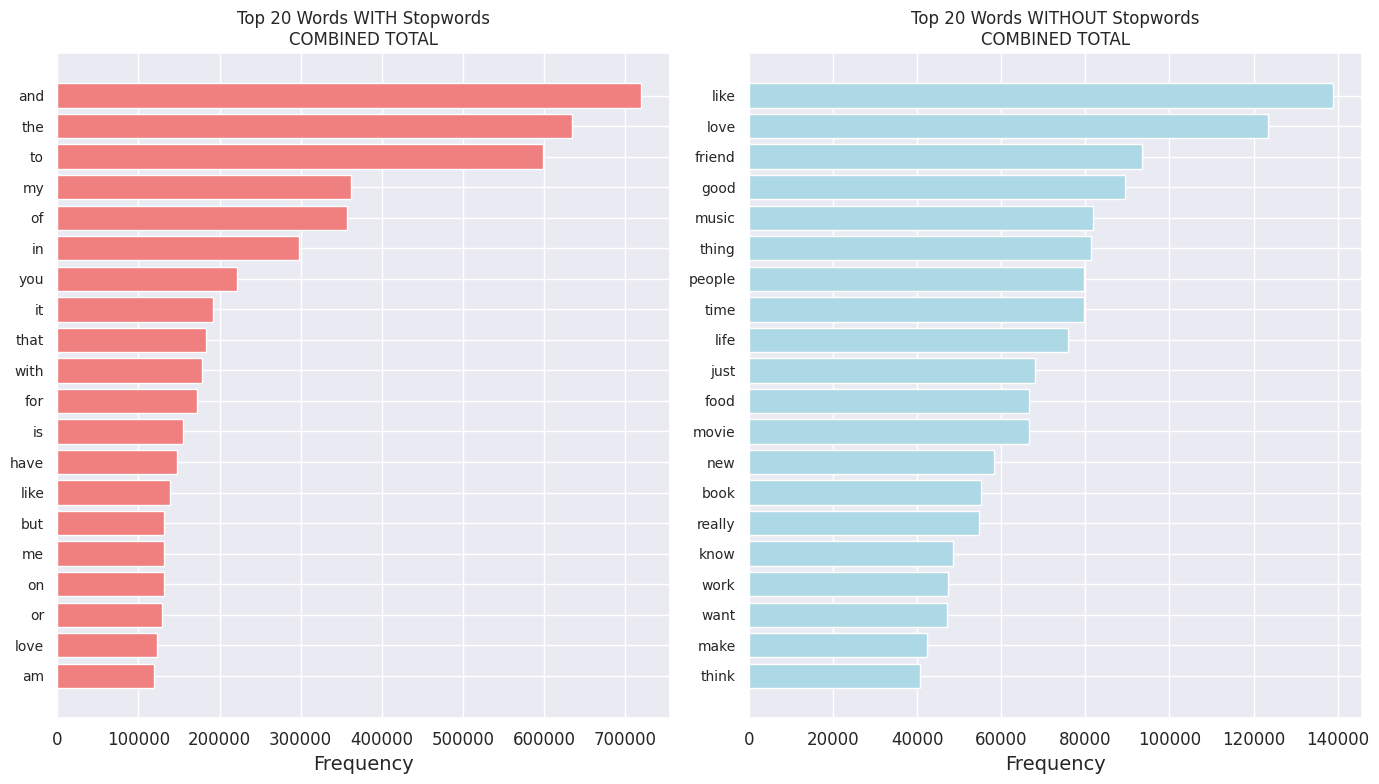

In [ ]:
#@title Top 20 Most Common Words (With & Without Stopwords)

# ==============================
# Run Total / Combined Analysis
# ==============================

okcupid_df['combined_essay_lemmatized_full'] = okcupid_df[essay_cols_lemmatized].agg(' '.join, axis=1)

print("\n" + "="*60)
print("TOTAL / COMBINED ANALYSIS")
print("="*60)

total_results = vocabulary_comparison_analysis(
    okcupid_df['combined_essay_lemmatized_full'],
    max_features=5000
)
create_comparison_plot(total_results, title="COMBINED TOTAL")

In the graph, we see top 20 most used words in total including stopwords on the left graph and without them on the right. We can see that only "love" and "like" are non-stopwords that got to the top 20 containing them (as expected from a dating app).

We can see that the non stopwords graph shows some words that refer to hobbies and possibly to the prompts the users were asked to answer.

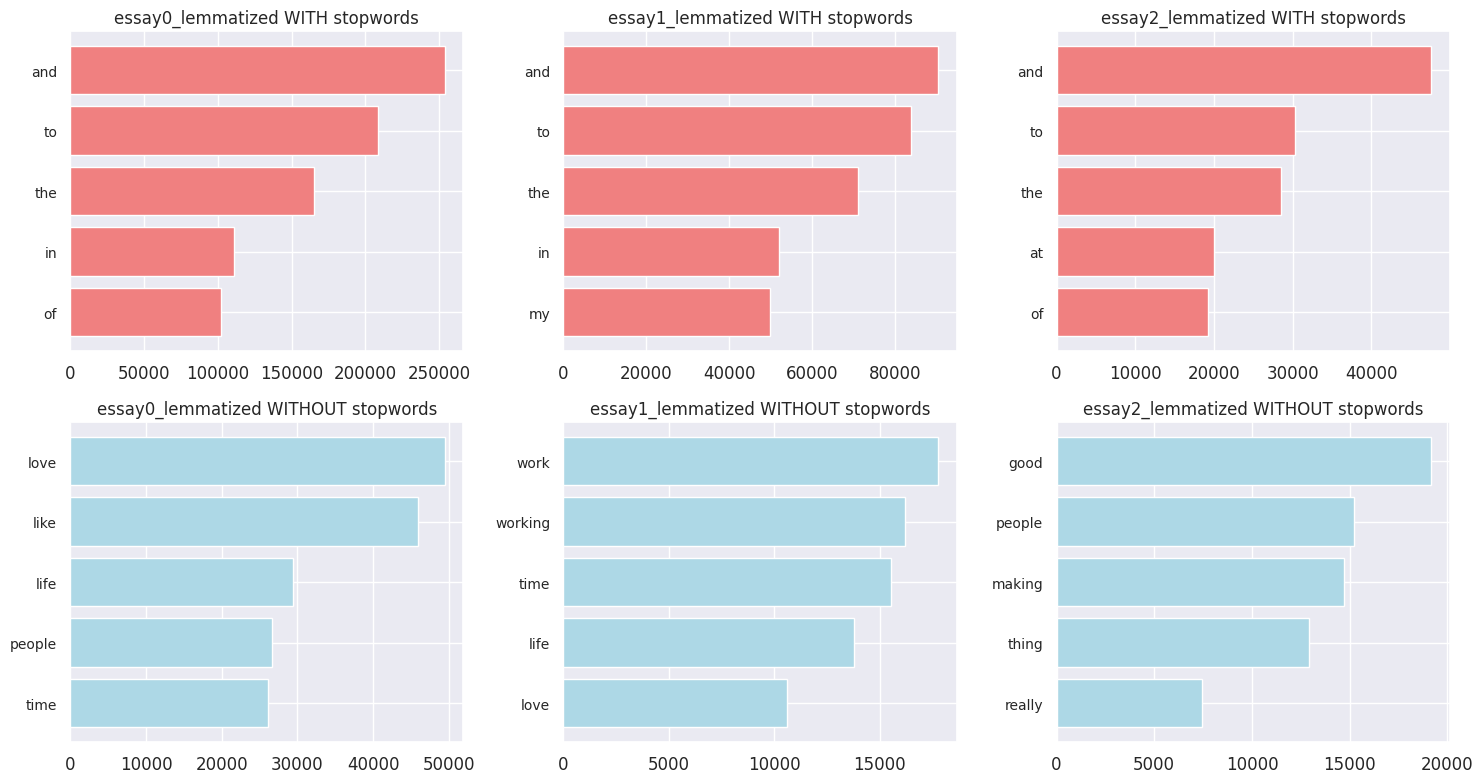

In [ ]:
#@title Most Common Words by Essay (With & Without Stopwords)

create_comparison_grid(results_per_essay, top_n=5, selected_essays=['essay0_lemmatized', 'essay1_lemmatized', 'essay2_lemmatized'])

We can also see the difference words used in each essay. While the stopwords graph remained unchanged, we can see different words used per essay. For example, essay1 ("What I'm doing with my life") - uses the words work, working, time as expected.

In [ ]:
#@title Essay Summary Table After Lemmatization

# ==============================
# Summary table
# ==============================
summary_stats = []

# Per essay
for col, res in results_per_essay.items():
    X_with = res['X_with']
    X_without = res['X_without']
    summary_stats.append({
        'essay': col,
        'avg_words_with_stopwords': X_with.sum() / X_with.shape[0],
        'avg_words_without_stopwords': X_without.sum() / X_without.shape[0]
    })

# Total / combined
X_with = total_results['X_with']
X_without = total_results['X_without']
summary_stats.append({
    'essay': 'combined_total',
    'avg_words_with_stopwords': X_with.sum() / X_with.shape[0],
    'avg_words_without_stopwords': X_without.sum() / X_without.shape[0]
})

# Convert to DataFrame
summary_df = pd.DataFrame(summary_stats)

summary_df[['avg_words_with_stopwords', 'avg_words_without_stopwords']] = \
    summary_df[['avg_words_with_stopwords', 'avg_words_without_stopwords']].round(2)

print("\nSUMMARY STATISTICS:")
print(summary_df)



SUMMARY STATISTICS:
                essay  avg_words_with_stopwords  avg_words_without_stopwords
0   essay0_lemmatized                     91.81                        44.43
1   essay1_lemmatized                     35.43                        18.07
2   essay2_lemmatized                     19.94                        11.32
3   essay3_lemmatized                     11.94                         5.75
4   essay4_lemmatized                     69.07                        42.73
5   essay5_lemmatized                     14.80                         9.25
6   essay6_lemmatized                     17.90                         8.14
7   essay7_lemmatized                     15.26                         7.77
8   essay8_lemmatized                     11.64                         5.33
9   essay9_lemmatized                     25.29                        11.00
10     combined_total                    306.97                       157.91


After lemmatization we can see the average totals shrunk to 307 on average (compared to 381.5). This happens from different reasons: Words like "didn't" or "wasn't" turn to "not", and numbers were dropped (this mostly affected essay5 - "The six things I could never do without", yet the meaning remains) which also dropped the amout of text.

Notice that even though we will be using essay\*_lemmatized as the word features in our model, we will also be using essay*_wc columns as features so the original volume of the data will still be present.

# Closed Questions Data Processing

At first, we'll remove unwanted columns:

The 'height' column, since our goal is to predict user gender without relying on specific physical attributes.

We decided to drop last_online, location, and speaks as we believe they should not differ a lot from males to females.

In [ ]:
#@title Drop Unwanted Columns

okcupid_df = okcupid_df.drop(columns=["height","last_online", "location", "speaks"])

Next, we focus on processing the age variable.

In [ ]:
#@title Age

# Age between 18-99 (like board games)
okcupid_df = okcupid_df[okcupid_df["age"] <= 99]


All users in the dataset are 18 years or older. We identified two rows with ages over 100 that contained uninformative information with missing values, and decided to remove them from the dataset. We will also use this row to further evaluate the model later.

Next, we will address the status variable. This variable contains users' relationship status. We will preprocess it to make it suitable for modeling.

In [ ]:
#@title Status

# Drop "unknown" values if present
okcupid_df = okcupid_df[okcupid_df["status"] != "unknown"]

# Ensure categorical
okcupid_df["status"] = pd.Categorical(okcupid_df["status"])

# Dummy encode
status_dummies = pd.get_dummies(okcupid_df["status"], prefix="status")

# Drop reference category ("single")
status_dummies = status_dummies.drop(columns=["status_single"], errors="ignore")

# Combine back
okcupid_df = pd.concat([okcupid_df, status_dummies], axis=1)

print(okcupid_df["status"].value_counts(), "\n")
# Drop original status
okcupid_df = okcupid_df.drop(columns=["status"], errors="ignore")

print(status_dummies.head())


status
single            53684
seeing someone     2014
available          1823
married             290
Name: count, dtype: int64 

   status_available  status_married  status_seeing someone
0             False           False                  False
1             False           False                  False
2              True           False                  False
3             False           False                  False
4             False           False                  False


We used dummy coding to transform the categories to dummy variables, using single as the reference.
There were 10 users with unknown status so we decided to remove them as they are a tiny fraction of the data and don't add information.

Next one, is sexual orientation:

In [ ]:
#@title Orientation

# Ensure categorical
okcupid_df["orientation"] = pd.Categorical(okcupid_df["orientation"])

# Dummy encode
orientation_dummies = pd.get_dummies(okcupid_df["orientation"], prefix="orient")

# Drop reference category ("straight")
orientation_dummies = orientation_dummies.drop(columns=["orient_straight"], errors="ignore")

# Combine back
okcupid_df = pd.concat([okcupid_df, orientation_dummies], axis=1)

print(okcupid_df["orientation"].value_counts(), "\n")
print(orientation_dummies.head())


orientation
straight    49697
gay          5404
bisexual     2710
Name: count, dtype: int64 

   orient_bisexual  orient_gay
0            False       False
1            False       False
2            False       False
3            False       False
4            False       False


We used dummy coding to transform the categories to dummy variables, using straight as the reference.

There were no empty values to handle.

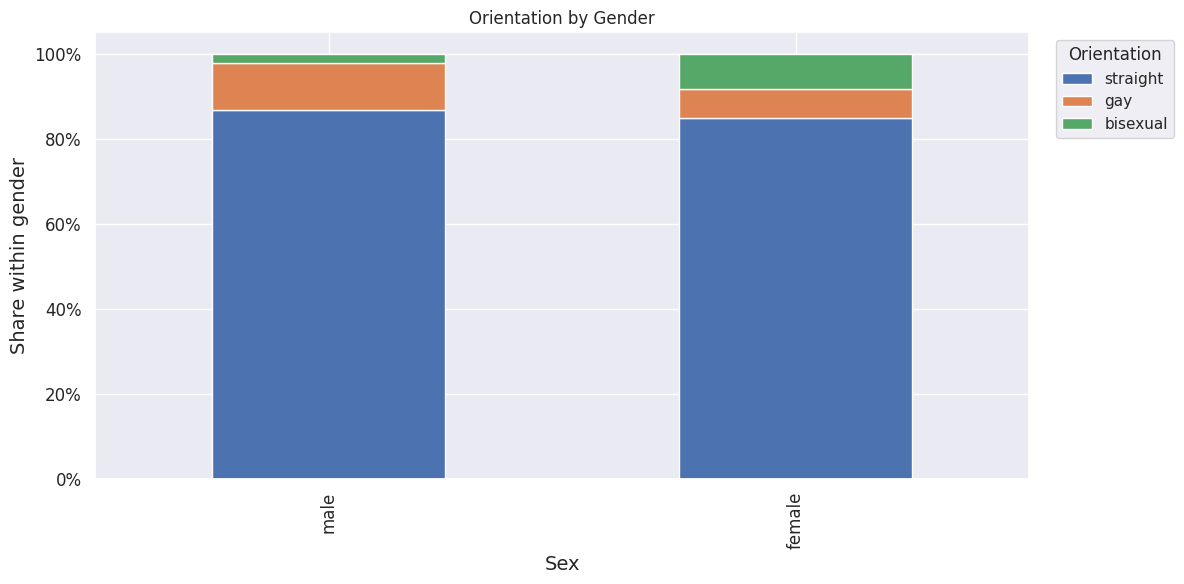

In [ ]:
#@title Sexual Orientation by Gender

orient_order = ["straight", "gay", "bisexual"] # Define the desired order

counts = (
    okcupid_df
    .groupby(["sex", "orientation"], observed=True)
    .size()
    .unstack("orientation", fill_value=0)
    .reindex(columns=orient_order, fill_value=0)  # keep chosen order
    .sort_index()
)

# Map sex codes to labels
sex_map = {0: "male", 1: "female"}
counts.index = counts.index.map(sex_map)

row_pct = counts.div(counts.sum(axis=1), axis=0).replace([np.inf, np.nan], 0)

ax = row_pct.plot(kind="bar", stacked=True, figsize=(12, 6))
ax.set_title("Orientation by Gender")
ax.set_xlabel("Sex")
ax.set_ylabel("Share within gender")
ax.legend(title="Orientation", bbox_to_anchor=(1.02, 1), loc="upper left")
# Show y-axis as percent
ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
plt.tight_layout()
plt.show()



We Can see that the Gay/Bisexual answers differs between genders. The gay pct. is higher in males, while the bisexual pct. is higher in females.

Next, we will process the body type variable. Notice that unlike the height feature, which we dropped due to its specificity, the body type categories are less precise and apply to both males and females, so we decided to keep them for analysis.

In [ ]:
#@title Body Type

print("is NA:", okcupid_df["body_type"].isna().sum())

# Fill missing values
okcupid_df["body_type"] = okcupid_df["body_type"].fillna("rather not say")

# Make it categorical
okcupid_df["body_type"] = pd.Categorical(okcupid_df["body_type"])

# Dummy encode
body_dummies = pd.get_dummies(okcupid_df["body_type"], prefix="body")

# Drop the reference category ("rather not say")
body_dummies = body_dummies.drop(columns=["body_rather not say"], errors="ignore")

# Combine back
okcupid_df = pd.concat([okcupid_df, body_dummies], axis=1)

print(okcupid_df["body_type"].value_counts(), "\n")
print(body_dummies.head())

is NA: 5085
body_type
average           14099
fit               12326
athletic          11379
rather not say     5271
thin               4556
curvy              3819
a little extra     2523
skinny             1703
full figured        963
overweight          421
jacked              406
used up             345
Name: count, dtype: int64 

   body_a little extra  body_athletic  body_average  body_curvy  body_fit  \
0                 True          False         False       False     False   
1                False          False          True       False     False   
2                False          False         False       False     False   
3                False          False         False       False     False   
4                False           True         False       False     False   

   body_full figured  body_jacked  body_overweight  body_skinny  body_thin  \
0              False        False            False        False      False   
1              False        False          

First, we filled missing (NA) values in the body type variable with "rather not say", based on the assumption that users who did not answer implicitly fit this category.

We then applied dummy coding to convert the categorical values into binary variables, using "rather not say" as the reference category.

Next, we handle the diet category:

In [ ]:
#@title Diet

print("Is NA:", okcupid_df["diet"].isna().sum())
okcupid_df["diet"].value_counts()

Is NA: 23377


,count
diet,
mostly anything,16035
anything,5904
strictly anything,5014
mostly vegetarian,3367
mostly other,968
strictly vegetarian,864
vegetarian,654
strictly other,444
mostly vegan,330


We can see that we have 2 different metrics to check inside each answer: diet type and strictness of the diet.

In [ ]:
#@title Splitting to Diet Type and Diet Strictness Level

# Parser for diet into type + strictness

def parse_diet(value: str):
    """
    Split raw diet string into (diet_type, strictness).
    Adds 'unknown' if missing.
    """
    if pd.isna(value):
        return pd.Series(["unknown_cat", "plain"])

    s = str(value).strip().lower()

    if s.startswith("mostly "):
        strictness = "mostly"
        diet = s[len("mostly "):]
    elif s.startswith("strictly "):
        strictness = "strictly"
        diet = s[len("strictly "):]
    else:
        strictness = "plain"
        diet = s

    return pd.Series([diet, strictness])


okcupid_df[["diet_type", "strictness"]] = okcupid_df["diet"].apply(parse_diet)

okcupid_df["diet_type"] = pd.Categorical(
    okcupid_df["diet_type"], ordered=False
)
okcupid_df["strictness"] = pd.Categorical(
    okcupid_df["strictness"], ordered=False
)

diet_dummies  = pd.get_dummies(okcupid_df["diet_type"],  prefix="diet")
strict_dummies = pd.get_dummies(okcupid_df["strictness"], prefix="strict")

# Drop base categories
diet_dummies = diet_dummies.drop(columns=["diet_unknown_cat"], errors="ignore")
strict_dummies = strict_dummies.drop(columns=["strict_plain"], errors="ignore")

# Concatenate back
okcupid_df = pd.concat([okcupid_df, diet_dummies, strict_dummies], axis=1)

# Checks
print("diet_type counts:\n", okcupid_df["diet_type"].value_counts(dropna=False), "\n")
print("strictness counts:\n", okcupid_df["strictness"].value_counts(dropna=False), "\n")
print(diet_dummies.head())
okcupid_df = okcupid_df.drop(columns=["diet_type", "strictness"], errors="ignore")


diet_type counts:
 diet_type
anything       26953
unknown_cat    23377
vegetarian      4885
other           1727
vegan            688
kosher           108
halal             73
Name: count, dtype: int64 

strictness counts:
 strictness
plain       30402
mostly      20828
strictly     6581
Name: count, dtype: int64 

   diet_anything  diet_halal  diet_kosher  diet_other  diet_vegan  \
0           True       False        False       False       False   
1          False       False        False        True       False   
2           True       False        False       False       False   
3          False       False        False       False       False   
4          False       False        False       False       False   

   diet_vegetarian  
0            False  
1            False  
2            False  
3             True  
4            False  


We filled missing (NA) values as it is a big chunk of the data (40%) that we believe that can still be informative.

We debated how to handle the diet variable, which contains many sub-categories. The options were to leave all sub-categories as they are, merge them based on food preferences, or merge them based on levels such as "strictly" or "mostly".

After discussion, we decided to create two new categorical variables: one reflecting the specific diet sub-categories and another capturing the strictness level. This approach keeps valuable information while making it easier to interpret the impact of each aspect.

We noticed that "vegan", "kosher", "halal" have a small amount of users, yet we decided to keep them for now, since we believe different diets can help predicting the gender of the user

Now, we'll handle the drinks category:

In [ ]:
#@title Drinks

print("Is NA:", okcupid_df["drinks"].isna().sum())

# Handle missing values
okcupid_df["drinks"] = okcupid_df["drinks"].fillna("unknown")

# Show counts before merge
print("Counts before merge:")
print(okcupid_df["drinks"].value_counts().loc[["very often", "desperately"]], "\n")

# Merge "desperately" into "very often"
okcupid_df["drinks"] = okcupid_df["drinks"].replace({
    "desperately": "very often"
})

okcupid_df["drinks"] = pd.Categorical(okcupid_df["drinks"])

# Dummy encode
drinks_dummies = pd.get_dummies(okcupid_df["drinks"], prefix="drinks")

# Drop the reference category ('unknown_drugs')
drinks_dummies = drinks_dummies.drop(columns=["drinks_unknown"], errors="ignore")

# Combine back
okcupid_df = pd.concat([okcupid_df, drinks_dummies], axis=1)

print(okcupid_df["drinks"].value_counts(), "\n")
print(drinks_dummies.head())

Is NA: 2722
Counts before merge:
drinks
very often     444
desperately    311
Name: count, dtype: int64 

drinks
socially      40440
rarely         5757
often          4993
not at all     3144
unknown        2722
very often      755
Name: count, dtype: int64 

   drinks_not at all  drinks_often  drinks_rarely  drinks_socially  \
0              False         False          False             True   
1              False          True          False            False   
2              False         False          False             True   
3              False         False          False             True   
4              False         False          False             True   

   drinks_very often  
0              False  
1              False  
2              False  
3              False  
4              False  


First, we filled missing (NA) values in the body type variable with "unknown".

Next, we applied dummy coding to convert the categorical values into binary variables, using "unknown" as the reference category.

We saw that 471 users answered "very often", and 322 answered "desperately" both answers refer to heavy drinking so we decided to combine both categories.  

For the drugs category we filled missing values and used dummy coding, using unknown as the reference:

In [ ]:
#@title Drugs

print("Is NA:", okcupid_df["drugs"].isna().sum())

# Handle missing values
okcupid_df["drugs"] = okcupid_df["drugs"].fillna("unknown")

# Make it categorical, with 'unknown_drugs' included
okcupid_df["drugs"] = pd.Categorical(okcupid_df["drugs"])

# Dummy encode
drugs_dummies = pd.get_dummies(okcupid_df["drugs"], prefix="drugs")

# 4. Drop the reference category ('unknown_drugs')
drugs_dummies = drugs_dummies.drop(columns=["drugs_unknown"], errors="ignore")

# 5. Combine back
okcupid_df = pd.concat([okcupid_df, drugs_dummies], axis=1)

# --- Check ---
print(okcupid_df["drugs"].value_counts(), "\n")
print(drugs_dummies.head())


Is NA: 13736
drugs
never        36168
unknown      13736
sometimes     7508
often          399
Name: count, dtype: int64 

   drugs_never  drugs_often  drugs_sometimes
0         True        False            False
1        False        False             True
2        False        False            False
3        False        False            False
4         True        False            False


For Education we debated what to do, the original dataframe had many different categories (33). After getting some help from the staff (thanks Oded!) we decided to do as follows:


In [ ]:
#@title Education

print("Is NA:", okcupid_df["education"].isna().sum())
okcupid_df["education"] = okcupid_df["education"].astype("string").fillna("unknown_edu")

def split_edu(stage):
    s = str(stage or "unknown_edu").strip().lower()
    if s.startswith("graduated from "):
        return pd.Series(["graduated", s.replace("graduated from ", "", 1)])
    if s.startswith("working on "):
        return pd.Series(["working", s.replace("working on ", "", 1)])
    if s.startswith("dropped out of "):
        return pd.Series(["dropped", s.replace("dropped out of ", "", 1)])
    return pd.Series(["plain", s])

okcupid_df[["edu_status", "edu_stage"]] = okcupid_df["education"].apply(split_edu)

# Anything that looks like grad/professional school (incl. law/med)
def is_advanced(stage: str) -> bool:
    if not isinstance(stage, str):
        return False
    s = stage.lower()
    patterns = [
        "masters",
        "ph.d",
        "law school",
        "med school"
    ]
    return any(p in s for p in patterns)

def map_interaction(row):
    status, stage = row["edu_status"], row["edu_stage"]

    # collapse space camp (fun easter egg from the dataset)
    if isinstance(stage, str) and "space camp" in stage:
        return "space camp"

    # dropped → previous stage
    if status == "dropped":
        mapping = {
            "college/university": "high school",
            "two-year college": "high school",
            "masters program": "college/university",
            "ph.d program": "masters program",
            "law school": "college/university",
            "med school": "college/university",
            "high school": "less than high school",
        }
        return mapping.get(stage, f"{stage} (unfinished)")

    # graduated / plain = finished
    if status in {"graduated", "plain"}:
        if is_advanced(stage):
            return "professional/graduate school"
        return stage

    # in-progress
    if status == "working":
        if is_advanced(stage):
            return "in-progress professional/graduate school"
        return f"in-progress {stage}"

    return "unknown_edu"

okcupid_df["edu_clean"] = okcupid_df.apply(map_interaction, axis=1)

education_dummies = pd.get_dummies(okcupid_df["edu_clean"], prefix="edu", dtype="uint8")

# Use 'unknown_edu' as the reference category
baseline_col = "edu_unknown_edu"
if baseline_col in education_dummies.columns:
    education_dummies = education_dummies.drop(columns=[baseline_col])

okcupid_df = pd.concat([okcupid_df, education_dummies], axis=1)

print(okcupid_df["edu_status"].value_counts(), "\n")
print(okcupid_df["edu_stage"].value_counts(), "\n")
print(okcupid_df["edu_clean"].value_counts(), "\n")


# Keep parsed columns for interpretability; just drop the raw text if you want
okcupid_df = okcupid_df.drop(columns=['edu_status', 'edu_stage', 'edu_clean'], errors="ignore")


Is NA: 6079
edu_status
graduated    38212
working      10198
plain         7360
dropped       2041
Name: count, dtype: int64 

edu_stage
college/university    30554
masters program       10641
unknown_edu            6079
two-year college       2880
ph.d program           2356
space camp             1657
high school            1607
law school             1382
med school              655
Name: count, dtype: int64 

edu_clean
college/university                          24189
professional/graduate school                11669
unknown_edu                                  6079
in-progress college/university               5560
in-progress professional/graduate school     3079
high school                                  2577
two-year college                             1661
space camp                                   1657
in-progress two-year college                 1038
masters program                               124
less than high school                          96
in-progress high school

We split each entry into two parts: a status (graduated, working, dropped, or plain) and education level (high school, college, masters).

By separating these, we can apply consistent rules: dropped out gets mapped down to the last fully completed level, graduated and plain labels are treated as finished, and working on entries are marked as in-progress. Special cases like "space camp" are collapsed into one category, and advanced degrees (masters, PhD, law, med) are grouped into a single "professional/graduate school" bucket.

This splitting and remapping ensures the categories better reflect highest completed education while reducing noise, making the data easier to analyze and model. By combining these two dimensions, to interaction variables we can interpret the education entry more intelligently.

Next, we'll handle with the ethnicity category:

In [ ]:
# @title Ethnicity

print("Is NA:", okcupid_df["ethnicity"].isna().sum())

# Normalize raw text
eth = (
    okcupid_df["ethnicity"]
    .astype("string")
    .fillna("unknown")
    .str.strip()
    .str.lower()
)

# Split into tokens, trim, remove empties
eth_list = (
    eth.str.split(",")
       .apply(lambda xs: [t.strip() for t in xs if t is not None and t.strip() != ""])
)


def collapse_tokens(tokens):
    toks = list(dict.fromkeys(tokens))
    if "unknown" in toks and len(toks) > 1:
        toks = [t for t in toks if t != "unknown"]
    if not toks:
        return ["unknown"]
    if len(toks) > 3:
        return ["other"]
    return toks

eth_list = eth_list.apply(collapse_tokens)

# Multi-hot encode
eth_dummies = (
    eth_list.apply(lambda xs: "|".join(xs))
            .str.get_dummies(sep="|")
)

# Clean column names
def clean_name(c: str) -> str:
    return f"ethnicity_{c.strip().replace(' ', '_').replace('/', '')}"

eth_dummies.columns = [clean_name(c) for c in eth_dummies.columns]
eth_dummies = eth_dummies.astype("uint8")

# Drop baseline dummies
if "ethnicity_unknown" in eth_dummies.columns:
    eth_dummies = eth_dummies.drop(columns=["ethnicity_unknown"])

# Concat to df
okcupid_df = pd.concat([okcupid_df, eth_dummies],axis=1)

# --- Check ---
print(okcupid_df["ethnicity"].value_counts(), "\n")
print(eth_dummies.head())


Is NA: 5313
ethnicity
white                                                                               31878
asian                                                                                5878
hispanic / latin                                                                     2675
black                                                                                1916
other                                                                                1652
                                                                                    ...  
asian, native american, indian, pacific islander, hispanic / latin, white, other        1
asian, middle eastern, black, pacific islander, hispanic / latin                        1
asian, black, pacific islander, white, other                                            1
asian, indian, hispanic / latin                                                         1
asian, black, indian                                                          

The ethnicity variable contained over 200 different subtypes, many of which were too sparse to analyze individually.

To address this, we filled missing values with "unknown" and collapsed entries listing more than three ethnicities into the "other" category.

We then split each entry into individual ethnicities and applied multi-hot encoding to create binary columns for each ethnicity.
Column names were cleaned for consistency, and we dropped the "unknown" category to serve as a reference.

This way each user is correctly represented across the relevant ethnicity columns while reducing the total number of columns.

Now, for the income category:

In [ ]:
#@title Income - Did Not Answer

#count how many incomes are -1
print(okcupid_df[okcupid_df["income"] == -1]["income"].count(), "users did not fill income")


46685 users did not fill income


As we can see 46685 users did not fill this category (80.7% of the users).

In [ ]:
# @title Income

# Inspect
print(okcupid_df["income"].value_counts(dropna=False), "\n")

# Treat -1
okcupid_df["income"] = okcupid_df["income"].astype("float").fillna(-1)

# Define bins & labels
bins = [-1, 0, 30_000, 60_000, 100_000, 250_000, np.inf]
labels = ["unknown", "low", "lower_mid", "upper_mid", "high", "very_high"]
income_dtype = pd.api.types.CategoricalDtype(categories=labels, ordered=True)

okcupid_df["income_cat"] = pd.cut(
    okcupid_df["income"],
    bins=bins,
    labels=labels,
    right=False,           # [a, b)
    include_lowest=True
).astype(income_dtype)

# Dummy coding
income_dummies = pd.get_dummies(okcupid_df["income_cat"], prefix="income", dtype="uint8")

# Drop baseline ("income_unknown") from the dummies
if "income_unknown" in income_dummies.columns:
    income_dummies = income_dummies.drop(columns=["income_unknown"])

# Concat back
okcupid_df = pd.concat([okcupid_df, income_dummies], axis=1)

# Drop inome_cat
okcupid_df = okcupid_df.drop(columns=["income_cat"], errors="ignore")

# 7) Sanity checks
assert "income_unknown" not in okcupid_df.columns, "Baseline still present!"
assert "income_cat" not in okcupid_df.columns, "income_cat wasn't dropped."
print(okcupid_df.filter(like="income_").head())


income
-1          46685
 20000       2871
 100000      1564
 80000       1073
 30000       1022
 40000        973
 50000        938
 60000        710
 70000        678
 150000       600
 1000000      512
 250000       138
 500000        47
Name: count, dtype: int64 

   income_low  income_lower_mid  income_upper_mid  income_high  \
0           0                 0                 0            0   
1           0                 0                 1            0   
2           0                 0                 0            0   
3           1                 0                 0            0   
4           0                 0                 0            0   

   income_very_high  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


To handle the high number of missing values in the income variable, we created income level bins. The numeric income values were categorized into six bins: "unknown", "low", "lower_mid", "upper_mid", "high", and "very_high". We then applied dummy coding to generate binary columns for each income category, using "unknown" as the reference.
This transformation allows us to include income information in the model while simplifying the variable and addressing missing values effectively.

Because of the large number of NAs we'll add another check after splitting to train and test to see if this feature is still informative.

Next, we'll handle the job category:

In [ ]:
#@title Job

print("Is NA:", okcupid_df["job"].isna().sum())

okcupid_df["job"].value_counts()

# Fill missing values
okcupid_df["job"] = okcupid_df["job"].fillna("rather not say")

okcupid_df["job_clean"] = okcupid_df["job"].str.replace(r"[ /]", "_", regex=True).str.lower()

# 3. Dummy coding
job_dummies = pd.get_dummies(okcupid_df["job_clean"], prefix="job")

# 4. Drop reference ("job_rather_not_say")
job_dummies = job_dummies.drop(columns=["job_rather_not_say"], errors="ignore")

# 5. Combine back
okcupid_df = pd.concat([okcupid_df, job_dummies], axis=1)

# --- Check ---
print(okcupid_df["job"].value_counts(), "\n")
print(job_dummies.head())

okcupid_df = okcupid_df.drop(columns=["job_clean"], errors="ignore")


Is NA: 7620
job
rather not say                       8031
other                                7368
student                              4746
science / tech / engineering         4716
computer / hardware / software       4573
artistic / musical / writer          4335
sales / marketing / biz dev          4247
medicine / health                    3551
education / academia                 3454
executive / management               2290
entertainment / media                2206
banking / financial / real estate    2168
law / legal services                 1331
hospitality / travel                 1316
construction / craftsmanship          972
clerical / administrative             776
political / government                692
transportation                        347
unemployed                            259
retired                               239
military                              194
Name: count, dtype: int64 

   job_artistic___musical___writer  job_banking___financial___real_estate 

Like we did in the body type category, we filled missing (NA) values in the body type variable with "rather not say".

Then, we applied dummy coding to convert the categorical values into binary variables, using "rather not say" as the reference category.

In [ ]:
#@title Offspring

print("Is NA:", okcupid_df["offspring"].isna().sum())

def parse_offspring(value):
    if pd.isna(value):
        return pd.Series(["unknown", "neutral"])

    s = str(value).lower().replace("doesn’t", "doesn't")  # normalize curly apostrophes

    # current kids
    if "has kid" in s or "has kids" in s or "has a kid" in s:
        kids = "has_kids"
    elif "doesn't have kids" in s or "doesnt have kids" in s:
        kids = "no_kids"
    else:
        kids = "unknown"

    # desire for kids
    if "wants more" in s or "wants them" in s or "wants kids" in s:
        desire = "wants"
    elif "might want" in s:
        desire = "might_want"
    elif "doesn't want" in s or "doesnt want" in s:
        desire = "doesnt_want"
    else:
        desire = "neutral"

    return pd.Series([kids, desire])

okcupid_df[["offspring_kids", "offspring_desire"]] = okcupid_df["offspring"].apply(parse_offspring)

kids_dummies   = pd.get_dummies(okcupid_df["offspring_kids"],   prefix="kids",   dtype="uint8")
desire_dummies = pd.get_dummies(okcupid_df["offspring_desire"], prefix="desire", dtype="uint8")

# Drop baselines
kids_dummies   = kids_dummies.drop(columns=["kids_unknown"], errors="ignore")
desire_dummies = desire_dummies.drop(columns=["desire_neutral"], errors="ignore")

okcupid_df = pd.concat([okcupid_df, kids_dummies, desire_dummies], axis=1)

print(okcupid_df["offspring_kids"].value_counts(), "\n")
print(okcupid_df["offspring_desire"].value_counts(), "\n")
print(kids_dummies.head())
print(desire_dummies.head())

okcupid_df = okcupid_df.drop(columns=["offspring_kids", "offspring_desire"], errors="ignore")

Is NA: 34258
offspring_kids
unknown     37491
no_kids     15611
has_kids     4709
Name: count, dtype: int64 

offspring_desire
neutral        45163
doesnt_want     4625
might_want      4272
wants           3751
Name: count, dtype: int64 

   kids_has_kids  kids_no_kids
0              0             1
1              0             1
2              0             0
3              0             0
4              0             0
   desire_doesnt_want  desire_might_want  desire_wants
0                   0                  1             0
1                   0                  1             0
2                   0                  0             0
3                   1                  0             0
4                   0                  0             0


The offspring variable contains information about current children and desire for children. To make this usable for modeling, we split it into two new categorical variables: offspring_kids (current children) and offspring_desire (desire for children).

Missing values were filled as "unknown" for 'has kids?' and "neutral" for desire.
The text responses were mapped to categories such as "has_kids", "no_kids", and "wants", "might_want" and "doesnt_want".

We then applied dummy coding to each new variable and dropped baseline categories ("unknown" for current kids and "neutral" for desire) to serve as references.

Next, we'll handle the pets category that tells about the attitude of the users toward cats and dogs.

In [ ]:
#@title Pets

print("Is NA:", okcupid_df["pets"].isna().sum())
def parse_pets(pet_str):
    s = str(pet_str).lower()

    # Dogs
    if "has dogs" in s:
        dogs = "has"
    elif "dislikes dogs" in s:
        dogs = "dislikes"
    elif "likes dogs" in s:
        dogs = "likes"
    else:
        dogs = "none"

    # Cats
    if "has cats" in s:
        cats = "has"
    elif "dislikes cats" in s:
        cats = "dislikes"
    elif "likes cats" in s:
        cats = "likes"
    else:
        cats = "none"

    return pd.Series([dogs, cats])

okcupid_df[["dogs_attitude", "cats_attitude"]] = okcupid_df["pets"].apply(parse_pets)
dogs_dummies = pd.get_dummies(okcupid_df["dogs_attitude"], prefix="dogs")
cats_dummies = pd.get_dummies(okcupid_df["cats_attitude"], prefix="cats")

# Drop baselines
dogs_dummies = dogs_dummies.drop(columns=["dogs_none"], errors="ignore")
cats_dummies = cats_dummies.drop(columns=["cats_none"], errors="ignore")

# Combine back
okcupid_df = pd.concat([okcupid_df, dogs_dummies, cats_dummies], axis=1)

print(okcupid_df["pets"].value_counts(), "\n")
print(cats_dummies.head())
print(dogs_dummies.head())



Is NA: 18847
pets
likes dogs and likes cats          14489
likes dogs                          7007
likes dogs and has cats             4228
has dogs                            3963
has dogs and likes cats             2273
likes dogs and dislikes cats        1964
has dogs and has cats               1437
has cats                            1364
likes cats                          1046
has dogs and dislikes cats           530
dislikes dogs and likes cats         235
dislikes dogs and dislikes cats      187
dislikes cats                        120
dislikes dogs and has cats            81
dislikes dogs                         40
Name: count, dtype: int64 

   cats_dislikes  cats_has  cats_likes
0          False     False        True
1          False     False        True
2          False      True       False
3          False     False        True
4          False     False        True
   dogs_dislikes  dogs_has  dogs_likes
0          False     False        True
1          False     False 

To make this information usable for modeling, we split it into two separate categorical variables: dogs_attitude and cats_attitude.

Each was mapped to categories such as "has", "likes", "dislikes", with missing values filled as "unknown".

We then applied dummy coding to both variables and dropped the baseline categories ("none") to serve as references.

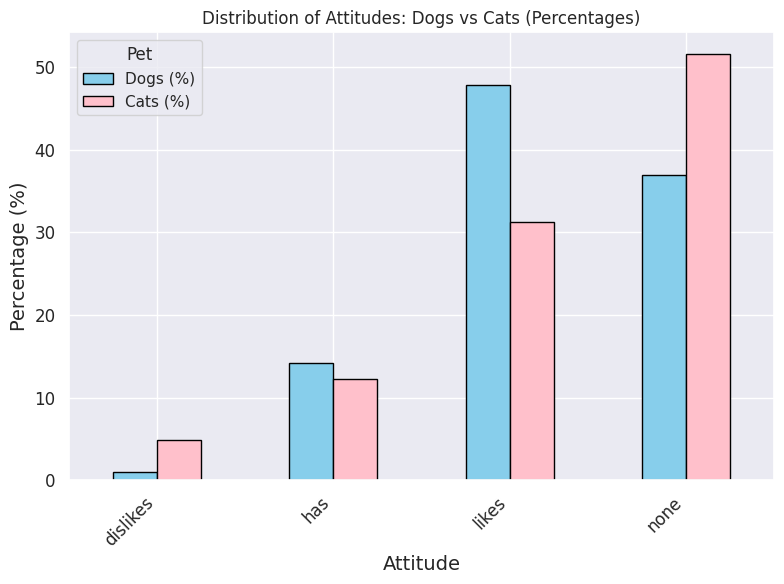

In [ ]:
#@title Attitudes Toward Dogs and Cats

# Replace NAs with "neutral"
okcupid_df['dogs_attitude'] = okcupid_df['dogs_attitude'].fillna("neutral")
okcupid_df['cats_attitude'] = okcupid_df['cats_attitude'].fillna("neutral")

# Count values for both, then normalize to %
dogs_counts = okcupid_df['dogs_attitude'].value_counts(normalize=True) * 100
cats_counts = okcupid_df['cats_attitude'].value_counts(normalize=True) * 100

# Combine into one DataFrame for plotting
counts_df = pd.DataFrame({
    "Dogs (%)": dogs_counts,
    "Cats (%)": cats_counts
}).fillna(0)

# Plot grouped bar chart (percentages)
ax = counts_df.plot(kind="bar", figsize=(8, 6), color=["skyblue", "pink"], edgecolor="black")

plt.title("Distribution of Attitudes: Dogs vs Cats (Percentages)")
plt.xlabel("Attitude")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Pet")
plt.tight_layout()
plt.show()

okcupid_df = okcupid_df.drop(columns=["dogs_attitude", "cats_attitude"], errors="ignore")

It's clear that dogs are more popular, the "none" (NAs) may be caused by neutral people or people who don't want to admit they don't like pets.

Next is religion:
We were debating whether to keep the full category or just the attitude towards religion. The issue was that even though the amount of males and females should be around the same for the different religions, different societies may have different approaches towards using dating apps. This can change the ratios of males and females.

For better understanding, while analyzing the train set, we'll check the percentages in each religion to decide whether to keep this feature.

In [ ]:
#@title Religion

# Religion parsing function
def parse_religion(value):
    if pd.isna(value):
        return pd.Series(["unknown_religion", "plain"])

    s = str(value).lower()

    # default seriousness = plain
    seriousness = "plain"

    if "not too serious" in s:
        seriousness = "not_too_serious"
    elif "somewhat serious" in s:
        seriousness = "somewhat_serious"
    elif "very serious" in s:
        seriousness = "very_serious"
    elif "laughing" in s:
        seriousness = "laughing"

    # strip seriousness phrases find religion type
    rel = (
        s.replace("but not too serious about it", "")
         .replace("and somewhat serious about it", "")
         .replace("and very serious about it", "")
         .replace("and laughing about it", "")
         .strip()
    )

    return pd.Series([rel, seriousness])

# Apply parser
okcupid_df[["religion_type", "religion_seriousness"]] = okcupid_df["religion"].apply(parse_religion)
print("Is NA:", okcupid_df["religion"].isna().sum())

# Religion type dummies
religion_dummies = pd.get_dummies(okcupid_df["religion_type"], prefix="religion")
religion_dummies = religion_dummies.drop(columns=["religion_unknown_religion"], errors="ignore")

# Seriousness dummies
seriousness_dummies = pd.get_dummies(okcupid_df["religion_seriousness"], prefix="serious")
seriousness_dummies = seriousness_dummies.drop(columns=["serious_plain"], errors="ignore")

# Combine back
okcupid_df = pd.concat([okcupid_df, religion_dummies, seriousness_dummies], axis=1)
okcupid_df = okcupid_df.drop(columns=['religion_seriousness'], errors="ignore")

print(okcupid_df["religion"].value_counts(), "\n")
print(religion_dummies.head())
print(seriousness_dummies.head())

Is NA: 19218
religion
agnosticism                                   2657
other                                         2604
agnosticism but not too serious about it      2579
agnosticism and laughing about it             2453
catholicism but not too serious about it      2236
atheism                                       2120
other and laughing about it                   2084
atheism and laughing about it                 2040
christianity but not too serious about it     1886
christianity                                  1859
other but not too serious about it            1510
judaism but not too serious about it          1490
atheism but not too serious about it          1283
catholicism                                    994
christianity and somewhat serious about it     886
atheism and somewhat serious about it          834
other and somewhat serious about it            828
catholicism and laughing about it              708
judaism and laughing about it                  668
buddhism 

We added both the type of religion and the degree of seriousness for now, and to test whether to keep them on the train set.

To make this usable for modeling, we split it into two categorical variables: religion_type and religion_seriousness. Missing values were filled as "unknown", and the seriousness was extracted from phrases such as "not too serious", "somewhat serious", "very serious", and "laughing about it", with "plain" as the default if no qualifier was present.

We then applied dummy coding to both variables and dropped baseline categories ("other" for religion type and "plain" for seriousness) to serve as references.

We are also worried about multicollinearity between this category and the diet category, later we'll check if it is an issue.

Next, we'll handle the astrological sign category:

In [ ]:
#@title Astrological Sign

print("Is NA:", okcupid_df["sign"].isna().sum())

def normalize_text(s: str) -> str:
    s = s.lower()
    s = s.replace("&rsquo;", "'").replace("&apos;", "'").replace("&quot;", '"')
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_sign(value):
    if pd.isna(value):
        return "unknown"
    s = normalize_text(str(value))

    # Importance only
    if "fun to think about" in s:
        return "fun"
    # Match doesn't / doesn’t / doesnt
    if re.search(r"doesn[’']?t matter", s):
        return "not_matters"
    if "matters a lot" in s:
        return "matters"
    return "plain"

okcupid_df["sign_importance"] = okcupid_df["sign"].apply(parse_sign)

cats = ["plain", "fun", "not_matters", "matters", "unknown"]
okcupid_df["sign_importance"] = pd.Categorical(okcupid_df["sign_importance"], categories=cats, ordered=False)

# Build dummies
sign_dummies = pd.get_dummies(okcupid_df["sign_importance"], prefix="sign")

# Drop the reference group ("unknown")
if "sign_unknown" in sign_dummies.columns:
    sign_dummies = sign_dummies.drop(columns=["sign_unknown"])

# Make sure columns exist in a consistent order
expected_cols = [f"sign_{c}" for c in cats if c != "unknown"]
for col in expected_cols:
    if col not in sign_dummies.columns:
        sign_dummies[col] = 0
sign_dummies = sign_dummies[expected_cols]

# Combine back
okcupid_df = pd.concat([okcupid_df, sign_dummies], axis=1)

# Sanity check
print(okcupid_df["sign_importance"].value_counts(dropna=False))
print(sign_dummies.head())
okcupid_df = okcupid_df.drop(columns=["sign_importance"], errors="ignore")

Is NA: 10400
sign_importance
fun            18862
not_matters    16322
plain          11580
unknown        10400
matters          647
Name: count, dtype: int64
   sign_plain  sign_fun  sign_not_matters  sign_matters
0        True     False             False         False
1        True     False             False         False
2       False     False              True         False
3        True     False             False         False
4        True     False             False         False


The specific astrological sign itself is not expected to be different between males and females, so it is not informative for gender prediction. We believe that we can learn more from how seriously a user considers their sign and whether they mention it at all, which is why we focus only on the sign_importance variable and not the sign itself.

Next is the "smokes" category, whether the user smokes or not:

In [ ]:
#@title Smoking

print("Is NA:", okcupid_df["sign"].isna().sum())

# Fill missing values with 'unknown_smokes'
okcupid_df["smokes"] = okcupid_df["smokes"].fillna("unknown_smokes")

# Make it categorical
okcupid_df["smokes"] = pd.Categorical(okcupid_df["smokes"])

# Dummy encode
smokes_dummies = pd.get_dummies(okcupid_df["smokes"], prefix="smokes")

# Drop the reference category ("unknown_smokes")
smokes_dummies = smokes_dummies.drop(columns=["smokes_unknown_smokes"], errors="ignore")

# Combine back
okcupid_df = pd.concat([okcupid_df, smokes_dummies], axis=1)

# Check
print(okcupid_df["smokes"].value_counts(), "\n")
print(smokes_dummies.head())


Is NA: 10400
smokes
no                42527
unknown_smokes     5164
sometimes          3609
when drinking      2941
yes                2143
trying to quit     1427
Name: count, dtype: int64 

   smokes_no  smokes_sometimes  smokes_trying to quit  smokes_when drinking  \
0      False              True                  False                 False   
1       True             False                  False                 False   
2       True             False                  False                 False   
3       True             False                  False                 False   
4       True             False                  False                 False   

   smokes_yes  
0       False  
1       False  
2       False  
3       False  
4       False  


We filled missing (NA) values in variable with "unknown", and applied dummy coding to convert the categorical values into binary variables, using "unknown" as the reference category.

In [ ]:
len(okcupid_df)

57811

After the entire process we were left with 57811 rows.

# Further Analysis After Train-Test Split

In the next section we'll split the dataframe to train and test set, and check interesting things about the data.

In addition, we'll use the train set to find the importance of the religion and income feature, as well as multicollinearity handling, and outliers analysis.

In [ ]:
#@title Splitting the Data - Train vs. Test

from sklearn.model_selection import train_test_split

target_col = "sex"

# Split into train and test
okcupid_train, okcupid_test = train_test_split(
    okcupid_df,
    test_size=0.2,        # 20% for test, 80% for train
    random_state=42,      # for reproducibility
    stratify=okcupid_df[target_col]  # preserves the proportion of target classes
)

# Check the shapes
print(okcupid_train.shape, okcupid_test.shape)

(46248, 174) (11563, 174)


Now, we'll check the ratio of males and females users by religion in our train set:

In [ ]:
#@title Religion Analysis - on Train

# Count by gender & religion
counts = okcupid_train.groupby(["religion_type", "sex"]).size().unstack(fill_value=0)

# Convert to percentages per religion
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Overall gender balance
overall_counts = okcupid_train["sex"].value_counts()
total_all = overall_counts.sum()
p_male = overall_counts[0] / total_all
p_female = overall_counts[1] / total_all

print("=== Overall gender balance in dataset ===")
print(f"Males: {overall_counts[0]} ({p_male:.2%}), Females: {overall_counts[1]} ({p_female:.2%})\n")

print("=== Percentages of M/F per religion ===")
print(percentages, "\n")

=== Overall gender balance in dataset ===
Males: 27546 (59.56%), Females: 18702 (40.44%)

=== Percentages of M/F per religion ===
sex                       0          1
religion_type                         
agnosticism       62.554301  37.445699
atheism           72.293343  27.706657
buddhism          58.051948  41.948052
catholicism       55.561614  44.438386
christianity      53.752809  46.247191
hinduism          67.705382  32.294618
islam             70.192308  29.807692
judaism           50.602911  49.397089
other             56.041002  43.958998
unknown_religion  58.982016  41.017984 



Using the total percenages of the train set for reference, we can see that our data contains about 60% males (0) and 40% females (1).

The male ratio for atheists and Muslims is higher than in the total data, with 72.3%, and 70.2% accordingly. While Jewish and non-Catholic Christian users have a relatively higher proportion of female users compared to the dataset average.

Since we are statistics students, we wanted to perform a Chi-square test of independence to examine thoroughly whether religion is associated with gender.

In [ ]:
#@title Chi-square Test of Independence for Religion

from scipy.stats import chi2 as chi2_dist
from scipy.stats import chi2_contingency

# Overall chi-square test across all religions
chi2_overall, p_overall, dof_overall, exp_overall = chi2_contingency(counts)

print("Overall chi-square test")
print(f"chi2={chi2_overall:.3f}, dof={dof_overall}, p={p_overall:.4f}")

Overall chi-square test
chi2=609.351, dof=9, p=0.0000


The p-value is essentially 0, which means we can reject the null hypothesis. In other words, there is a statistically significant association between religion and gender in the data.

These findings suggest that religion interacts with gender representation in meaningful ways, which justifies including religion as a predictor in our regression analysis.

We'll check the representation of M/F for income as well:

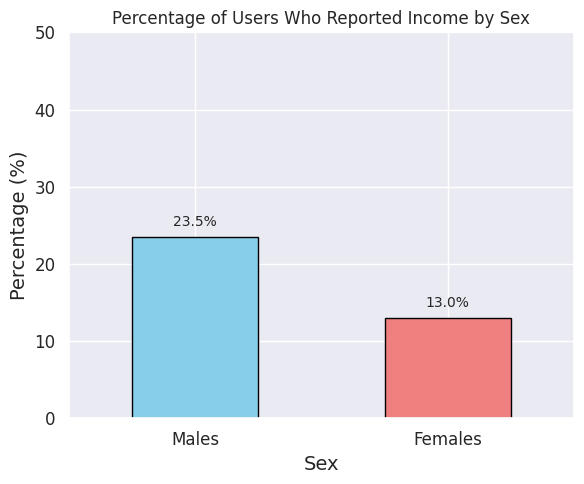

In [ ]:
#@title Income Analysis On Train

# Map 0:males, 1: females
sex_labels = {0: "Males", 1: "Females"}

# Create a new column: 1 if income filled, 0 if -1
okcupid_train['income_filled'] = (okcupid_train['income'] != -1).astype(int)

# Group by sex, compute % with filled income
percent_income_filled = (
    okcupid_train.groupby('sex')['income_filled']
    .mean() * 100
).rename(index=sex_labels)

# Plot
plt.figure(figsize=(6, 5))
percent_income_filled.plot(kind='bar', color=['skyblue', 'lightcoral'], edgecolor='black')

plt.title("Percentage of Users Who Reported Income by Sex")
plt.ylabel("Percentage (%)")
plt.xlabel("Sex")
plt.xticks(rotation=0)
plt.ylim(0, 50)

# Add percentages as labels on top of bars
for i, val in enumerate(percent_income_filled):
    plt.text(i, val + 1, f"{val:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Clean up
okcupid_train = okcupid_train.drop(columns=["income_filled"], errors="ignore")


We see that there is a larger % of females who didn't share their income than men, meaning it can provide some informative data, so we decided to keep it.

Another thing we want to check is the standard deviation in the total word count.

For this, at first, we'll check how are the users distributed in a matter of word amount groups.

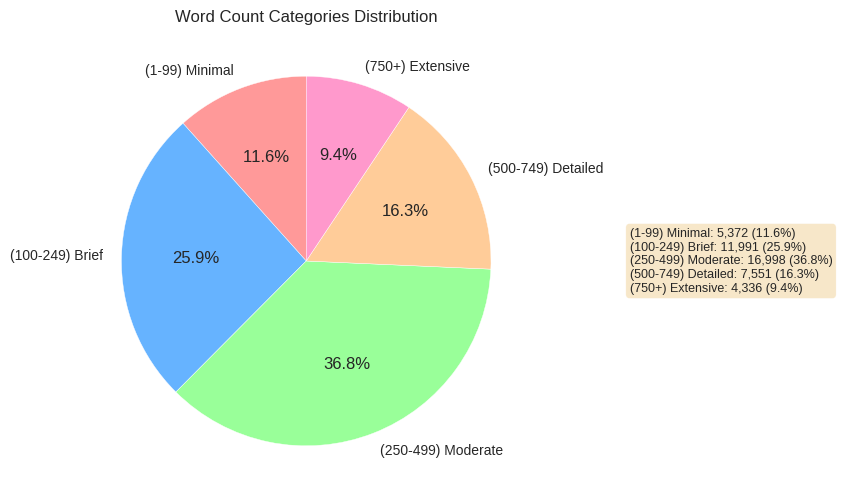

In [ ]:
#@title Word Count Categories Distribution

from scipy import stats

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

okcupid_train['total_words_filled'] = okcupid_train[[f"essay{i}_wc" for i in range(10)]].sum(axis=1)

# Get the word count data
word_counts = okcupid_train["total_words_filled"]

def categorize_word_count(count):
    if count < 100:
        return '(1-99) Minimal'
    elif count < 250:
        return '(100-249) Brief'
    elif count < 500:
        return '(250-499) Moderate'
    elif count < 750:
        return '(500-749) Detailed'
    else:
        return '(750+) Extensive'

# Define order
category_order = [
        '(1-99) Minimal',
        '(100-249) Brief',
        '(250-499) Moderate',
        '(500-749) Detailed',
        '(750+) Extensive'
]

# Apply function and assign to DataFrame
okcupid_train["categorize_word_count"] = word_counts.apply(categorize_word_count)

# Convert to categorical with order
okcupid_train["categorize_word_count"] = pd.Categorical(
    okcupid_train["categorize_word_count"],
    categories=category_order,
    ordered=True
)

# Get counts
category_counts = okcupid_train["categorize_word_count"].value_counts().sort_index()

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']

fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
       colors=colors, startangle=90)

# Build category breakdown text
stats_text = "\n".join([f"{cat}: {count:,} ({count/len(word_counts)*100:.1f}%)"
                        for cat, count in category_counts.items()])

ax.set_title('Word Count Categories Distribution')

# Stats box to the right
ax.text(1.2, 0.5, stats_text, transform=ax.transAxes,
        ha='left', va='center', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.show()

The most interesting groups for our model we'll be the minimal (under 100 words) and extensive (750+) groups. It will be interesting to check how the model handles these 2 groups.

Now, let's go even further to see how the word count is distributed.

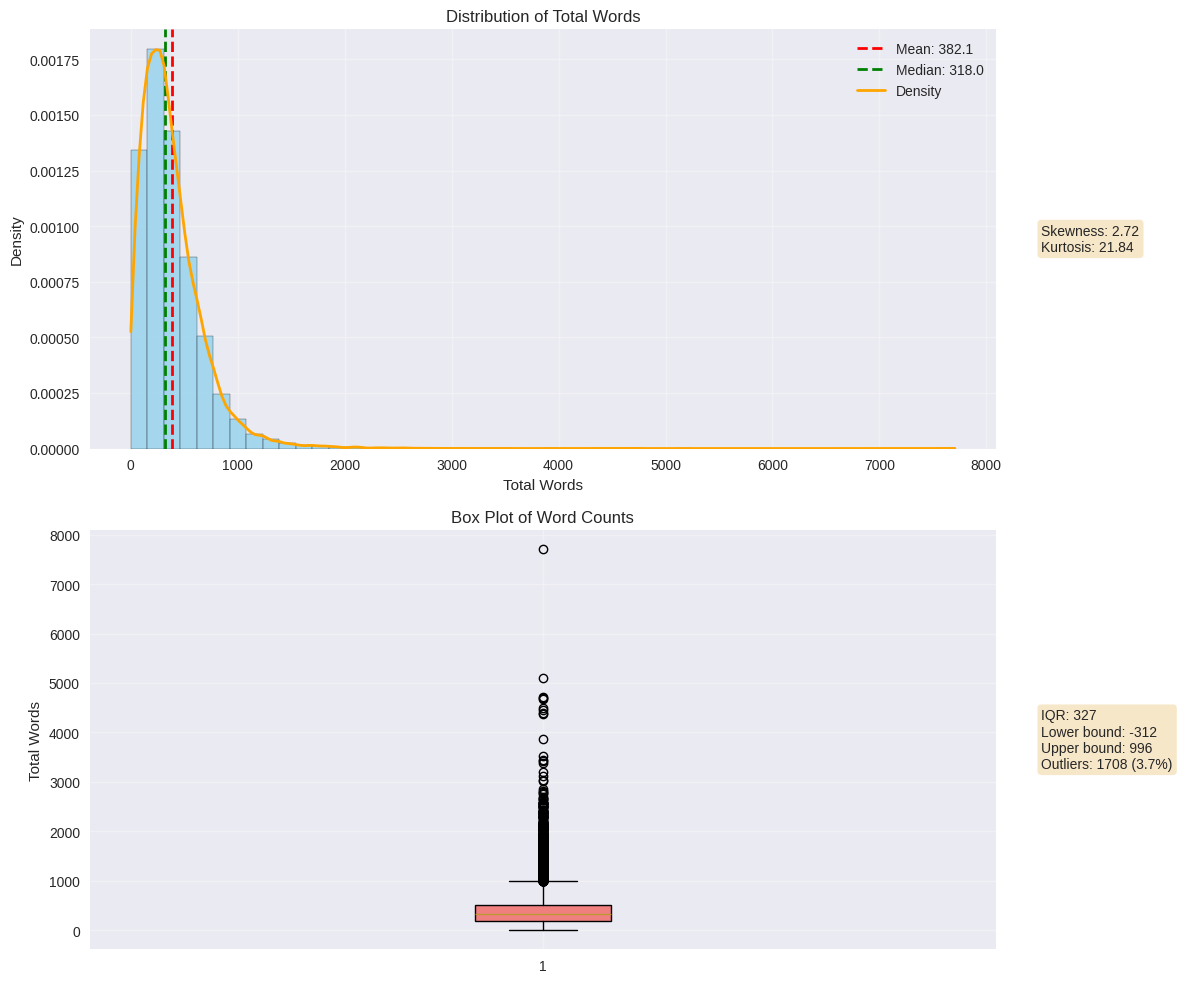

In [ ]:
#@title Word Count Distribution

# Create figure with 2 rows (hist + boxplot)
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# ===================================================
# Histogram with density curve + distribution stats
# ===================================================
axes[0].hist(word_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
axes[0].axvline(word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {word_counts.mean():.1f}')
axes[0].axvline(word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {word_counts.median():.1f}')

# Density curve
x_range = np.linspace(word_counts.min(), word_counts.max(), 200)
density = stats.gaussian_kde(word_counts)
axes[0].plot(x_range, density(x_range), 'orange', linewidth=2, label='Density')

# Stats: skewness + kurtosis
skewness = stats.skew(word_counts)
kurtosis_val = stats.kurtosis(word_counts)
stats_text = f"""Skewness: {skewness:.2f}
Kurtosis: {kurtosis_val:.2f}"""

axes[0].set_title('Distribution of Total Words')
axes[0].set_xlabel('Total Words')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Stats box to the right
axes[0].text(1.05, 0.5, stats_text, transform=axes[0].transAxes,
             ha='left', va='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# ===================================================
# Box plot + IQR / outliers
# ===================================================
box_plot = axes[1].boxplot(word_counts, patch_artist=True, vert=True)
box_plot['boxes'][0].set_facecolor('lightcoral')

# Compute IQR and bounds
Q1, Q3 = np.percentile(word_counts, [25, 75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = word_counts[(word_counts < lower_bound) | (word_counts > upper_bound)]

stats_text = f"""IQR: {IQR:.0f}
Lower bound: {lower_bound:.0f}
Upper bound: {upper_bound:.0f}
Outliers: {len(outliers)} ({len(outliers)/len(word_counts)*100:.1f}%)"""

axes[1].set_title('Box Plot of Word Counts')
axes[1].set_ylabel('Total Words')
axes[1].grid(True, alpha=0.3)

# Stats box to the right
axes[1].text(1.05, 0.5, stats_text, transform=axes[1].transAxes,
             ha='left', va='center', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Final layout for hist + boxplot
plt.tight_layout()


The word count distribution has a right-tail as expected, but we can see some extreme outliers.

The most extreme case is a user who wrote nearly 8,000 words, with few more that wrote over 4000 words.

/tmp/ipython-input-3823803635.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1].boxplot([male_counts, female_counts],


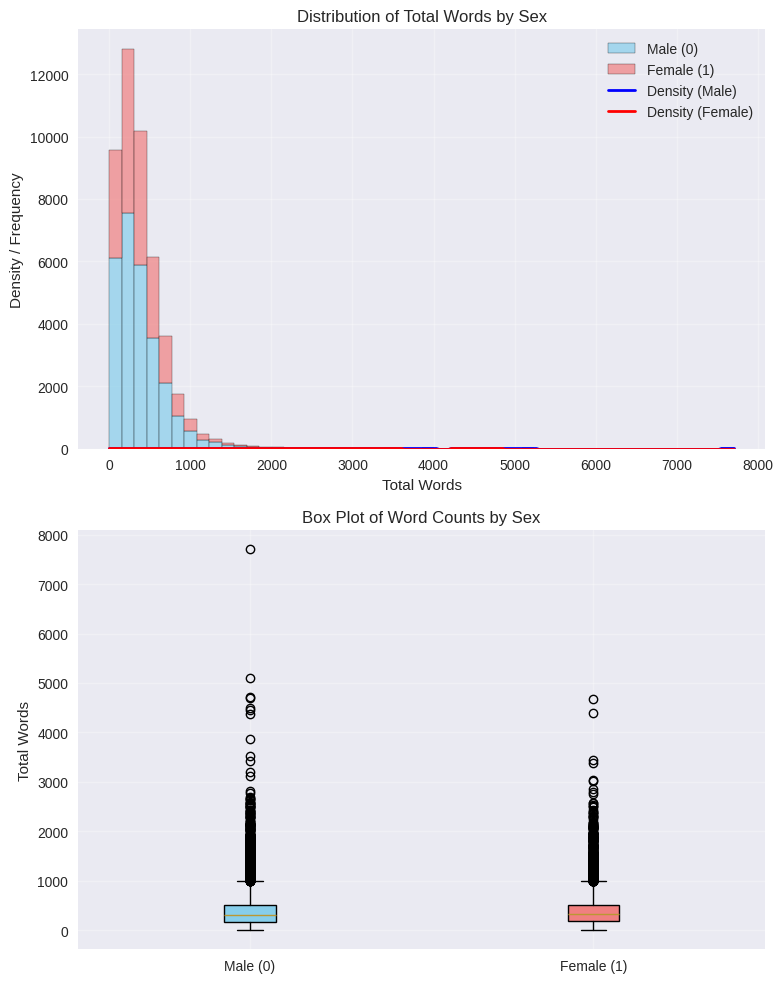

In [ ]:
#@title Word Count Distribution by Sex

fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Split by sex
male_counts = okcupid_train.loc[okcupid_train["sex"] == 0, "total_words_filled"]
female_counts = okcupid_train.loc[okcupid_train["sex"] == 1, "total_words_filled"]

# ===================================================
# Histogram with density curves by sex
# ===================================================
bins = 50
axes[0].hist([male_counts, female_counts],
             bins=bins,
             stacked=True,
             alpha=0.7,
             label=['Male (0)', 'Female (1)'],
             color=['skyblue', 'lightcoral'],
             edgecolor='black')

# Density curves for each group
x_range = np.linspace(word_counts.min(), word_counts.max(), 200)
density_m = stats.gaussian_kde(male_counts)
density_f = stats.gaussian_kde(female_counts)
axes[0].plot(x_range, density_m(x_range), color='blue', linewidth=2, label='Density (Male)')
axes[0].plot(x_range, density_f(x_range), color='red', linewidth=2, label='Density (Female)')

axes[0].set_title('Distribution of Total Words by Sex')
axes[0].set_xlabel('Total Words')
axes[0].set_ylabel('Density / Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ===================================================
# Box plot grouped by sex
# ===================================================
box_plot = axes[1].boxplot([male_counts, female_counts],
                           patch_artist=True,
                           labels=['Male (0)', 'Female (1)'])

colors = ['skyblue', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

axes[1].set_title('Box Plot of Word Counts by Sex')
axes[1].set_ylabel('Total Words')
axes[1].grid(True, alpha=0.3)

# Final layout
plt.tight_layout()
plt.show()


We can't really see a noticeable difference between males and females tendencies from these graphs. We can see that the 8000 words user is a male.

Now will checl the differences between males and females per essay:

In [ ]:
#@title Essay Length Differences by Males and Females

essay_wc_cols = [f'essay{i}_wc' for i in range(10)]

avg_table = okcupid_train.groupby('sex')[essay_wc_cols].mean()

avg_table.index = ['Male', 'Female']

avg_table = avg_table.round(2)

print(avg_table)

        essay0_wc  essay1_wc  essay2_wc  essay3_wc  essay4_wc  essay5_wc  \
Male       110.77      43.26      24.33      14.83      84.40      17.97   
Female     117.62      43.45      23.28      14.28      87.23      18.43   

        essay6_wc  essay7_wc  essay8_wc  essay9_wc  
Male        21.05      17.37      15.15      28.49  
Female      20.86      18.09      14.23      31.14  


We see that in the "My self summary" essay women tend to write a bit more, and also in "You should message me if..."

Now we'll analyze the age distributions:

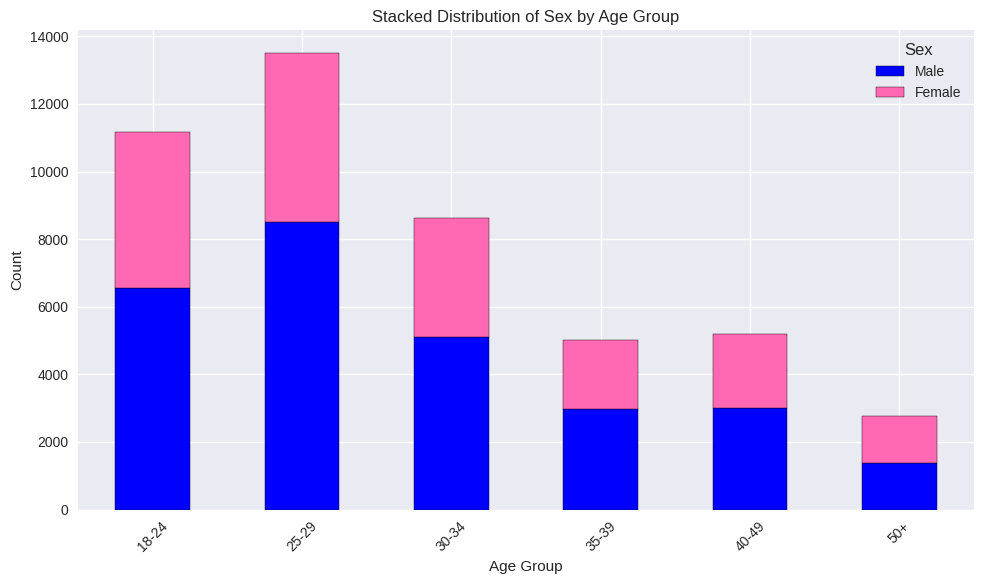

In [ ]:
#@title Age Distributions Analysis

def create_age_groups(age_series, bins=None):
    """
    Create age groups for analysis
    """
    if bins is None:
        bins = [0, 25, 30, 35, 40, 50, 100]
        labels = ['18-24', '25-29', '30-34', '35-39', '40-49', '50+']
    else:
        labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]
    return pd.cut(age_series, bins=bins, labels=labels, include_lowest=True)

def plot_stacked_gender_age_distribution(age_groups, gender, group_name="Age Group"):
    """
    Plot stacked male/female distribution across age groups
    """
    dist = pd.crosstab(age_groups, gender)

    # Reorder columns to ensure male=0, female=1
    dist = dist[[0, 1]]

    # Stacked bar plot
    dist.plot(
        kind="bar",
        stacked=True,
        figsize=(10,6),
        color=["blue", "hotpink"],
        edgecolor="black"
    )

    plt.xlabel(group_name)
    plt.ylabel("Count")
    plt.title(f"Stacked Distribution of Sex by {group_name}")
    plt.xticks(rotation=45)
    plt.legend(["Male", "Female"], title="Sex")
    plt.tight_layout()
    plt.show()

# Usage
gender = okcupid_train['sex'].reset_index(drop=True)  # assumes 0=male, 1=female
age = okcupid_train['age'].reset_index(drop=True)

age_groups = create_age_groups(age)
plot_stacked_gender_age_distribution(age_groups, gender)

As expected most users are under 35. But there's still a significant amount of older users.

We see that the 25-29 group has a higher males ratio than the rest of the groups, and that the 50+ group is pretty much evenly distributed between males and females.

Let's check if there's difference in the words a user write by age:

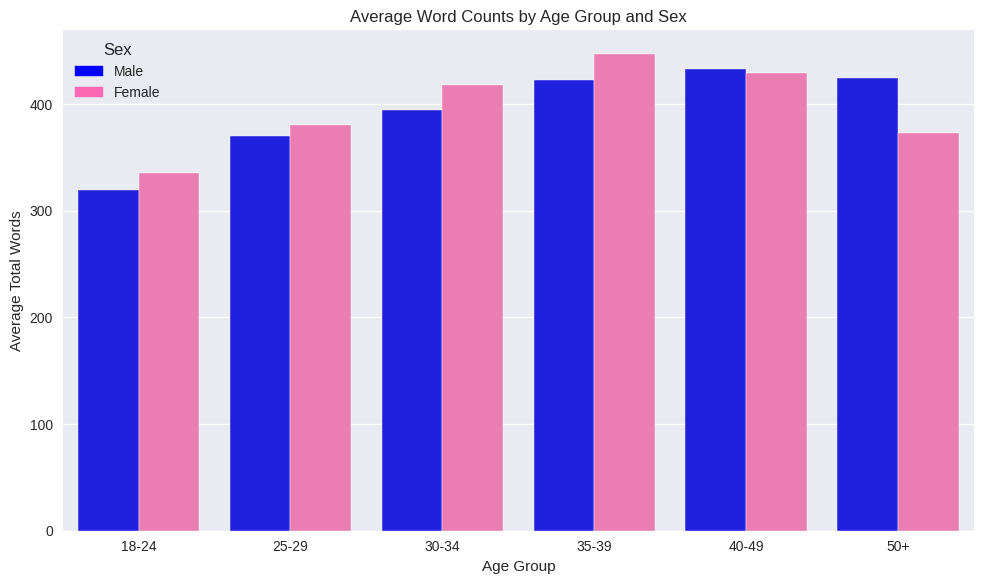

In [ ]:
#@title Word Count Analysis by Age Group and Sex

import matplotlib.patches as mpatches

# Define colors for sex
sex_palette = {0: "blue", 1: "hotpink"}

# Barplot
plt.figure(figsize=(10,6))
sns.barplot(
    x=pd.cut(
        okcupid_train["age"],
        bins=[0, 25, 30, 35, 40, 50, 100],
        labels=['18-24', '25-29', '30-34', '35-39', '40-49', '50+']
    ),
    y="total_words_filled",
    hue="sex",
    data=okcupid_train,
    estimator="mean",
    errorbar=None,
    palette=sex_palette
)

plt.title("Average Word Counts by Age Group and Sex")
plt.xlabel("Age Group")
plt.ylabel("Average Total Words")

# Custom legend
male_patch = mpatches.Patch(color="blue", label="Male")
female_patch = mpatches.Patch(color="hotpink", label="Female")
plt.legend(handles=[male_patch, female_patch], title="Sex")

plt.tight_layout()
plt.show()

We can see that females aged 35-39 have the highest word count in the data, while for males it is the 40-49 age group.

The youngest age group have the lowest word counts for both males and females.

# Outliers

In the next part we'll check outliers in the data.

Let's look at users that wrote 3000+ words:

USERS WITH MORE THAN 3000 WORDS
Total users above 3000 words: 18
Percentage of all users: 0.04%
Percentage of 3000+ word users by sex:
  Male: 66.7%
  Female: 33.3%

Word count stats (>3000 words):
  Max: 7,706
  Avg: 4144
  Avg prompts filled: 10.0/10


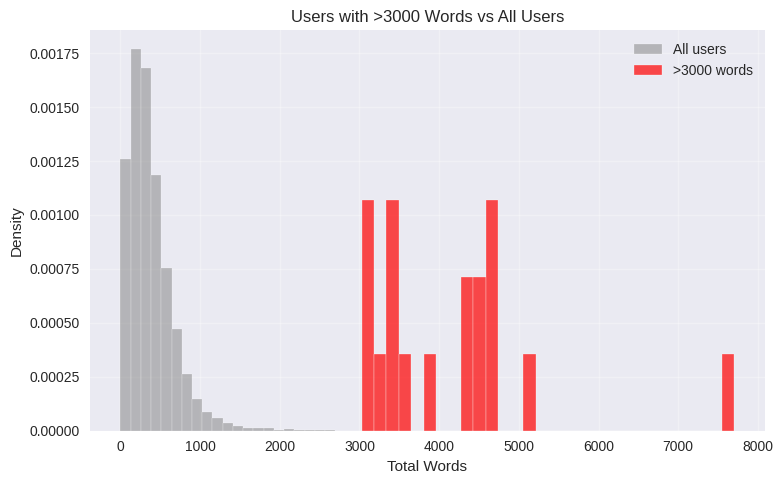

In [ ]:
#@title Users With 3000+ Stats

# Find users with more than 3000 words
threshold = 3000
high_word_users = okcupid_train[okcupid_train["total_words_filled"] > threshold].copy()

print("=" * 60)
print(f"USERS WITH MORE THAN {threshold} WORDS")
print("=" * 60)

print(f"Total users above {threshold} words: {len(high_word_users)}")
print(f"Percentage of all users: {len(high_word_users) / len(okcupid_train) * 100:.2f}%")


# Count by sex
sex_counts = high_word_users["sex"].value_counts()
sex_percent = (sex_counts / len(high_word_users)) * 100

# Display percentages
print("Percentage of 3000+ word users by sex:")
for sex in [0, 1]:  # 0: male, 1: female
    pct = sex_percent.get(sex, 0)
    label = "Male" if sex == 0 else "Female"
    print(f"  {label}: {pct:.1f}%")


if len(high_word_users) > 0:
    print(f"\nWord count stats (>{threshold} words):")
    print(f"  Max: {high_word_users['total_words_filled'].max():,}")
    print(f"  Avg: {high_word_users['total_words_filled'].mean():.0f}")

    # Sort by word count
    high_word_users_sorted = high_word_users.sort_values('total_words_filled', ascending=False)

    print(f"  Avg prompts filled: {high_word_users['prompts_filled'].mean():.1f}/10")

    # Histogram comparison
    plt.figure(figsize=(8,5))
    plt.hist(okcupid_train['total_words_filled'], bins=60, alpha=0.5, color='gray',
             label='All users', density=True)
    plt.hist(high_word_users['total_words_filled'], bins=30, alpha=0.7, color='red',
             label=f'>{threshold} words', density=True)
    plt.title(f'Users with >{threshold} Words vs All Users')
    plt.xlabel('Total Words')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In the training set we have 18 users with 3000+ words.

In [ ]:
#@title Checking The Top Outliers

from collections import Counter

def analyze_text_quality(text):
    """Analyze text for spam/quality indicators"""
    if pd.isna(text) or not text:
        return {}

    text = str(text)

    # Basic metrics
    word_count = len(text.split())
    char_count = len(text)
    sentence_count = len(re.findall(r'[.!?]+', text))

    # Quality indicators
    avg_word_length = np.mean([len(word) for word in text.split()])
    avg_sentence_length = word_count / max(sentence_count, 1)

    # Repetition detection
    words = text.lower().split()
    word_freq = Counter(words)
    most_common_word = word_freq.most_common(1)[0] if words else ('', 0)
    repetition_ratio = most_common_word[1] / len(words) if words else 0

    # Detect repeated phrases
    phrases = []
    for i in range(len(words) - 2):
        phrases.append(' '.join(words[i:i+3]))
    phrase_freq = Counter(phrases)
    repeated_phrases = [phrase for phrase, count in phrase_freq.items() if count > 2]

    return {
        'word_count': word_count,
        'char_count': char_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'repetition_ratio': repetition_ratio,
        'most_common_word': most_common_word,
        'repeated_phrases': repeated_phrases[:3]  # Top 3
    }

# Get top outliers
top_outliers = okcupid_train[okcupid_train["total_words_filled"] > 4000].nlargest(3, 'total_words_filled')

essay_cols = [f"essay{i}" for i in range(10)]

for rank, (idx, user) in enumerate(top_outliers.iterrows(), 1):
    print(f"\n{'='*20} USER #{rank} (Index: {idx}) {'='*20}")
    print(f"Total words: {user['total_words_filled']:,}")
    print(f"Prompts filled: {user['prompts_filled']}/10")
    print(f"Avg per prompt: {user['avg_wordcount']:.0f} words")

    # Analyze each essay
    total_repetition = 0
    total_essays = 0
    all_repeated_phrases = []

    for i, essay_col in enumerate(essay_cols):
        if essay_col in okcupid_train.columns:
            essay_text = okcupid_train.loc[idx, essay_col]
            if pd.notna(essay_text) and str(essay_text).strip():
                analysis = analyze_text_quality(essay_text)
                total_repetition += analysis['repetition_ratio']
                total_essays += 1
                all_repeated_phrases.extend(analysis['repeated_phrases'])

                print(f"\n  Essay {i}:")
                print(f"    Words: {analysis['word_count']}")
                print(f"    Avg word length: {analysis['avg_word_length']:.1f}")
                print(f"    Avg sentence length: {analysis['avg_sentence_length']:.1f}")
                print(f"    Most common word: '{analysis['most_common_word'][0]}' ({analysis['most_common_word'][1]}x)")
                print(f"    Repetition ratio: {analysis['repetition_ratio']:.3f}")

                if analysis['repeated_phrases']:
                    print(f"    Repeated phrases: {analysis['repeated_phrases']}")

                # Show preview
                preview = str(essay_text)[:200] + "..." if len(str(essay_text)) > 200 else str(essay_text)
                print(f"    Preview: {preview}")

    avg_repetition = total_repetition / max(total_essays, 1)
    print(f"\n  OVERALL QUALITY SCORE:")
    print(f"    Average repetition ratio: {avg_repetition:.3f}")

    # Quality assessment
    if avg_repetition > 0.15:
        quality = "Very repetitive, likely SPAM"
    elif avg_repetition > 0.08:
        quality = "Some repetitiveness"
    elif user['avg_wordcount'] > 1500:
        quality = "Extremely Verbose"
    else:
        quality = "Probably Legitimate"

    print(f"    Assessment: {quality}")


==================== USER #1 (Index: 19921) ====================
Total words: 7,706
Prompts filled: 10/10
Avg per prompt: 771 words

  Essay 0:
    Words: 2975
    Avg word length: 4.9
    Avg sentence length: 16.9
    Most common word: 'i' (121x)
    Repetition ratio: 0.041
    Repeated phrases: ['that i can', 'i do not', 'one of the']
    Preview: update: new moon on august 28, 2011: i am presently just seeking friends/penpals for the immediate future.  the original profile is out of date and substantial parts no longer make sense.  my last ori...

  Essay 1:
    Words: 1241
    Avg word length: 4.5
    Avg sentence length: 14.8
    Most common word: 'to' (61x)
    Repetition ratio: 0.049
    Repeated phrases: ['be able to']
    Preview: after almost 20 years of working a swing shift and being a night owl, i reported to work at 6am, january 24, 2009. 6 bloody am!! sometimes i would go to sleep @ 6am!! being at work then? ouch!!  the g...

  Essay 2:
    Words: 1026
    Avg word leng

In this section, we checked the quality of their texts and found them to be legitimate. Some answers were repetitive, but this was expected, as the questions themselves asked for repetitive responses ("The six things I could never do without", "You should message me if...").

We also checked the outlier's essays with our own eyes (Uncomment to see):

In [ ]:
# user_essays = okcupid_df.loc[19921, essay_cols]
# for i, essay in enumerate(user_essays, start=0):
#     print(f"Essay {i}:\n{essay}\n{'-'*50}")


After inspecting the texts, we believe the users genuinely answered the prompts and did not write gibberish.

We debated whether to keep, remove, or cap the outliers. In the end, we decided not to cap the texts themselves because doing so might alter their meaning, even in longer responses.

Since one of our goals is to ensure the model can handle users who write extensively, we chose to keep these long texts.

Another motivation for this choice is that the words in these long answers may still contain valuable and informative signals for prediction, and when predicting for users with short text every word can help.

Even though we decided to keep the outliers, we still wanted to take a closer look at them. We used the Median Absolute Deviation (MAD) to analyze how many outliers there were.

Unlike z-scores based on the mean and standard deviation, MAD is more robust to skewness, non-normal data and extreme values, since it relies on the median. It also provides a more lenient detection criterion, making it suitable for our context.

In [ ]:
#@title MAD Outlier Analysis

from scipy.stats import percentileofscore

print("=" * 80)
print("MAD BOUNDARIES ANALYSIS FOR YOUR OKCUPID DATA")
print("=" * 80)

# Word count data
word_counts = okcupid_train["total_words_filled"].values

# Calculate median and MAD
median_words = np.median(word_counts)
mad = np.median(np.abs(word_counts - median_words))

print(f"Raw Statistics:")
print(f"  Median word count: {median_words:.1f}")
print(f"  MAD (Median Absolute Deviation): {mad:.1f}")

# Standard MAD threshold
threshold = 3.5
modified_z_scores = 0.6745 * (word_counts - median_words) / mad

# Identify outliers and non-outliers
outliers = word_counts[np.abs(modified_z_scores) > threshold]
non_outliers = word_counts[np.abs(modified_z_scores) <= threshold]

# MAD boundaries
lower_bound = median_words - threshold * mad / 0.6745
upper_bound = median_words + threshold * mad / 0.6745

print(f"\nBoundaries for outliers:")
print(f"  Lower boundary: {lower_bound:.1f} words")
print(f"  Upper boundary: {upper_bound:.1f} words")
print(f"  Acceptable range: {lower_bound:.1f} to {upper_bound:.1f} words")

# Percentile analysis
lower_percentile = percentileofscore(word_counts, lower_bound)
upper_percentile = percentileofscore(word_counts, upper_bound)

print(f"\nMAD boundaries correspond to:")
print(f"  Lower: {lower_bound:.1f} words ({lower_percentile:.2f}th percentile)")
print(f"  Upper: {upper_bound:.1f} words ({upper_percentile:.2f}th percentile)")

print("=" * 80)
print(f"\nSUMMARY")
print("=" * 80)
print(f"MAD threshold {threshold} removes {len(outliers)} users ({len(outliers)/len(word_counts)*100:.1f}%)")
print(f"Preserves {len(non_outliers)} users ({len(non_outliers)/len(word_counts)*100:.1f}%)")
print(f"Remaining users range from {non_outliers.min():.0f} to {non_outliers.max():.0f} words")


MAD BOUNDARIES ANALYSIS FOR YOUR OKCUPID DATA
Raw Statistics:
  Median word count: 318.0
  MAD (Median Absolute Deviation): 157.0

Boundaries for outliers:
  Lower boundary: -496.7 words
  Upper boundary: 1132.7 words
  Acceptable range: -496.7 to 1132.7 words

MAD boundaries correspond to:
  Lower: -496.7 words (0.00th percentile)
  Upper: 1132.7 words (97.64th percentile)

SUMMARY
MAD threshold 3.5 removes 1093 users (2.4%)
Preserves 45155 users (97.6%)
Remaining users range from 0 to 1132 words


Users with 1133 words and more are considered outliers according to MAD (threshold of 3.5 MADs) in this model (2.4% of our set).

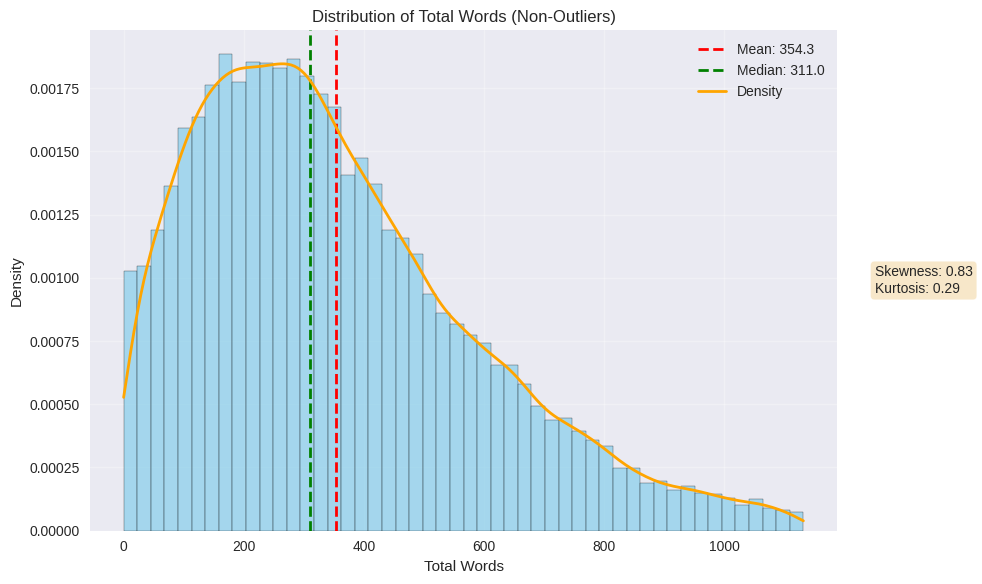

In [ ]:
#@title Distribution of Total Words (No Outliers)

from scipy import stats

# Filter non-outliers
non_outliers = word_counts[(word_counts >= lower_bound) & (word_counts <= upper_bound)]

# Create figure
fig, ax = plt.subplots(figsize=(10,6))

# Histogram
ax.hist(non_outliers, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)

# Mean & Median lines
ax.axvline(non_outliers.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {non_outliers.mean():.1f}')
ax.axvline(np.median(non_outliers), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(non_outliers):.1f}')

# Density curve
x_range = np.linspace(non_outliers.min(), non_outliers.max(), 200)
density = stats.gaussian_kde(non_outliers)
ax.plot(x_range, density(x_range), 'orange', linewidth=2, label='Density')

# Skewness and kurtosis
skewness = stats.skew(non_outliers)
kurtosis_val = stats.kurtosis(non_outliers)
stats_text = f"""Skewness: {skewness:.2f}
Kurtosis: {kurtosis_val:.2f}"""

# Title, labels, legend
ax.set_title('Distribution of Total Words (Non-Outliers)')
ax.set_xlabel('Total Words')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

# Stats box to the right
ax.text(1.05, 0.5, stats_text, transform=ax.transAxes,
        ha='left', va='center', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()

Here we can see the distribution of word count without outliers, still skewed to the right a bit (0.83) as expected. The mean and median got closer to each other.

In [ ]:
#@title Removing Columns

okcupid_df = okcupid_df.drop(columns=["orientation", "body_type", "diet", "drinks","drugs","education", "ethnicity", "income", "job", "offspring","pets","religion", "religion_type", "sign", "smokes"], errors="ignore")
okcupid_train = okcupid_train.drop(columns=["orientation", "body_type", "diet", "drinks","drugs","education", "ethnicity", "income", "job", "offspring","pets","religion", "religion_type", "sign", "smokes"], errors="ignore")
okcupid_test = okcupid_test.drop(columns=["orientation", "body_type", "diet", "drinks","drugs","education", "ethnicity", "income", "job", "offspring","pets","religion", "religion_type", "sign", "smokes"], errors="ignore")

okcupid_df = okcupid_df.drop(columns=["total_words_filled", "avg_wordcount", "total_punct_filled", "avg_punct", "combined_essay_lemmatized_full", 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9'])
okcupid_train = okcupid_train.drop(columns=["total_words_filled", "avg_wordcount", "total_punct_filled", "avg_punct", "combined_essay_lemmatized_full", 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9'])
okcupid_test = okcupid_test.drop(columns=["total_words_filled", "avg_wordcount", "total_punct_filled", "avg_punct", "combined_essay_lemmatized_full", 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9'])

print("Remaining columns:\n", okcupid_train.columns.tolist())

Remaining columns:
 ['age', 'sex', 'essay0_wc', 'essay1_wc', 'essay2_wc', 'essay3_wc', 'essay4_wc', 'essay5_wc', 'essay6_wc', 'essay7_wc', 'essay8_wc', 'essay9_wc', 'prompts_filled', 'essay0_punct', 'essay1_punct', 'essay2_punct', 'essay3_punct', 'essay4_punct', 'essay5_punct', 'essay6_punct', 'essay7_punct', 'essay8_punct', 'essay9_punct', 'total_smileys_count', 'essay0_lemmatized', 'essay1_lemmatized', 'essay2_lemmatized', 'essay3_lemmatized', 'essay4_lemmatized', 'essay5_lemmatized', 'essay6_lemmatized', 'essay7_lemmatized', 'essay8_lemmatized', 'essay9_lemmatized', 'status_available', 'status_married', 'status_seeing someone', 'orient_bisexual', 'orient_gay', 'body_a little extra', 'body_athletic', 'body_average', 'body_curvy', 'body_fit', 'body_full figured', 'body_jacked', 'body_overweight', 'body_skinny', 'body_thin', 'body_used up', 'diet_anything', 'diet_halal', 'diet_kosher', 'diet_other', 'diet_vegan', 'diet_vegetarian', 'strict_mostly', 'strict_strictly', 'drinks_not at all

# Multicollinearity Test

We started by checking collinearity between our columns. We wanted to see the high-ish connections to we make a table for any pairs with correlation higher than 0.4.


In [ ]:
#@title Collinearity Check For Closed Data

feature_cols = [
    col for col in okcupid_train.columns
    if not (col == "sex" or col == "age")
]

X = okcupid_train[feature_cols].copy()

corr = X.corr(numeric_only=True)

# Flatten correlation matrix
high_corr = corr.where(~np.eye(corr.shape[0], dtype=bool)).stack().reset_index()
high_corr.columns = ["Feature1", "Feature2", "Correlation"]

# Filter only high correlations
high_corr = high_corr.loc[high_corr["Correlation"].abs() > 0.4]

# Drop duplicate pairs
high_corr["Pair"] = high_corr.apply(
    lambda row: tuple(sorted([row["Feature1"], row["Feature2"]])), axis=1
)

high_corr = high_corr.drop_duplicates(subset="Pair").drop(columns="Pair")

# Sort
high_corr = high_corr.sort_values("Correlation", key=np.abs, ascending=False)

# Top 20
print("=== Top 20 Unique Correlated Feature Pairs (|r| > 0.4) ===")
display(high_corr.head(20).style.background_gradient(cmap="coolwarm", subset=["Correlation"]))


=== Top 20 Unique Correlated Feature Pairs (|r| > 0.4) ===


,Feature1,Feature2,Correlation
538,essay4_wc,essay4_punct,0.883588
10,essay0_wc,essay0_punct,0.829894
142,essay1_wc,essay1_punct,0.806845
1066,essay8_wc,essay8_punct,0.780192
934,essay7_wc,essay7_punct,0.773892
1719,essay2_punct,essay6_punct,0.655717
1198,essay9_wc,essay9_punct,0.593214
274,essay2_wc,essay2_punct,0.556275
802,essay6_wc,essay6_punct,0.540385
1584,essay1_punct,essay2_punct,0.518050


The table shows pairs of features that are moderately to strongly correlated (|r| > 0.4).

We can see high collinearity of the essay\*_punct columns between themselves and also between them and the essay\*_wc columns.

Other mid-correlations are between dummies for the same category:
education dummies (college/university vs. graduate school), drinking habits (drinks_rarely vs. drinks_socially), or natural associations (ethnicity_indian with religion_hinduism). Those are not too high and we'll check their VIF in order to decide whether to address them.

For models like logistic regression, such collinearity can make coefficients unstable and hard to interpret.



We decided to drop the essay\*_punct columns and to create puctuation ratio feature instead (total punct/total words):

In [ ]:
#@title Creating Punctuation Ratio

# Compute total punct and total words for train
total_punct_train = okcupid_train[[f"essay{i}_punct" for i in range(10)]].sum(axis=1)

total_words_train = okcupid_train[[f"essay{i}_lemmatized" for i in range(10)]].apply(
    lambda row: sum(len(str(x).split()) if pd.notnull(x) else 0 for x in row),
    axis=1
)

okcupid_train["punct_ratio"] = total_punct_train / (total_words_train + 1)

# Compute total punct and total words for test
total_punct_test = okcupid_test[[f"essay{i}_punct" for i in range(10)]].sum(axis=1)

total_words_test = okcupid_test[[f"essay{i}_lemmatized" for i in range(10)]].apply(
    lambda row: sum(len(str(x).split()) if pd.notnull(x) else 0 for x in row),
    axis=1
)

okcupid_test["punct_ratio"] = total_punct_test / (total_words_test + 1)

# Drop original punct columns
punct_cols = [f"essay{i}_punct" for i in range(10)]

okcupid_train = okcupid_train.drop(columns=punct_cols)
okcupid_test = okcupid_test.drop(columns=punct_cols)


In [ ]:
#@title Collinearity Check - After Punctuation Ratio

feature_cols = [
    col for col in okcupid_train.columns
    if not (col == "sex" or col == "age")
]

X = okcupid_train[feature_cols].copy()

corr = X.corr(numeric_only=True)

# Flatten correlation matrix
high_corr = corr.where(~np.eye(corr.shape[0], dtype=bool)).stack().reset_index()
high_corr.columns = ["Feature1", "Feature2", "Correlation"]

# Filter only high correlations
high_corr = high_corr.loc[high_corr["Correlation"].abs() > 0.4]

# Drop duplicate pairs
high_corr["Pair"] = high_corr.apply(
    lambda row: tuple(sorted([row["Feature1"], row["Feature2"]])), axis=1
)

high_corr = high_corr.drop_duplicates(subset="Pair").drop(columns="Pair")

# Sort
high_corr = high_corr.sort_values("Correlation", key=np.abs, ascending=False)

# Top 20
print("=== Top 20 Unique Correlated Feature Pairs (|r| > 0.4) ===")
display(high_corr.head(20).style.background_gradient(cmap="coolwarm", subset=["Correlation"]))


=== Top 20 Unique Correlated Feature Pairs (|r| > 0.4) ===


,Feature1,Feature2,Correlation
4674,drinks_rarely,drinks_socially,-0.507294
5044,drugs_never,drugs_sometimes,-0.500127
7180,ethnicity_indian,religion_hinduism,0.479348
4552,drinks_often,drinks_socially,-0.469716
3449,diet_anything,strict_mostly,0.456141
11810,dogs_likes,cats_likes,0.440814
14022,sign_fun,sign_not_matters,-0.435511
14391,smokes_no,smokes_sometimes,-0.430191
5419,edu_college/university,edu_professional/graduate school,-0.425773
6772,ethnicity_asian,ethnicity_white,-0.404359


We can see the main problem of collinearity was solved.

We also decided to test VIF (Variance Inflation Factor). Because simple correlation tables only show pairwise relationships, while multicollinearity can also come from combinations of multiple features.  VIF captures this by measuring how well each predictor can be explained by all the others, flagging variables that contribute little unique information.

In [ ]:
#@title VIF Calculating

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X.copy()

bool_cols = X_vif.select_dtypes(include='bool').columns
X_vif[bool_cols] = X_vif[bool_cols].astype(int)

X_numeric = X_vif.select_dtypes(include=['number'])

X_numeric = X_numeric.astype(float)

# Add constant for calc
X_const = sm.add_constant(X_numeric)

# Compute VIF
vif_data = pd.DataFrame({
    "Feature": X_const.columns,
    "VIF": [
        variance_inflation_factor(X_const.values, i)
        for i in range(X_const.shape[1])
    ]
})

# Drop constant
vif_data = vif_data[vif_data["Feature"] != "const"].reset_index(drop=True)

# Sort descending
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print("VIFs:\n", vif_data)


VIFs:
                          Feature       VIF
39               drinks_socially  6.189772
38                 drinks_rarely  3.511547
44        edu_college/university  3.425607
117                    smokes_no  3.236324
37                  drinks_often  3.192697
..                           ...       ...
59      ethnicity_middle_eastern  1.035774
51           edu_masters program  1.032497
47   edu_in-progress high school  1.025989
13                status_married  1.016317
122                  punct_ratio  1.001694

[123 rows x 2 columns]


We can see that drinks_socially has a relatively high VIF (6.19) yet we decided to keep it since we believe it can get us some important information, and usually VIF is considered a problem when it is higher than 6.5.

A few other variables, such as drinks_rarely, edu_college/university, smokes_no, and drinks_often (VIFs around 3-3.5), show moderate overlap with related categories.

# Training The Model and Finding Hyperparameters

In this section we'll train the models.

As we mentioned before, there are going to be 2 models (LR, GBT) for each scenario (Closed Answers, Open Text).

In addition, we wanted to evaluate a logistic regression model without regularization for the closed answers.

We did this in order to get a base we can later compare the two regularized models to:

In [ ]:
#@title Model Training - Full Logistic Regression

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# -----------------------------
# Prepare Data
# -----------------------------
target = "sex"
essay_cols_lemmatized = [f"essay{i}_lemmatized" for i in range(10)]
essay_wc = [f"essay{i}_wc" for i in range(10)]
essay_punct = [f"essay{i}_punct" for i in range(10)]
additional_columns = ['punct_ratio', 'prompts_filled', 'total_smileys_count']

exclude = [target, "age", "combined_essay_lemmatized_full", "total_punct_filled", 'categorize_word_count'] + essay_wc + additional_columns + essay_cols_lemmatized + essay_punct


feature_cols = [c for c in okcupid_train.columns if c not in exclude]
X = okcupid_train[feature_cols].copy()
y = okcupid_train[target].copy()

# Encode target
if y.dtype == "object" or str(y.dtype).startswith("category"):
    y = LabelEncoder().fit_transform(y)

# -----------------------------
# Explicitly Separate Categorical & Numeric Columns
# -----------------------------
possible_categoricals = [
    "diet", "drinks", "drugs", "ethnicity", "income", "orientation", "religion",
    "sex", "smokes", "body_type", "status", "kids", "edu", "desire"
]
categorical_cols = [c for c in feature_cols if c in possible_categoricals]

# -----------------------------
# Scaling
# -----------------------------
numerical_cols = [c for c in feature_cols if c not in categorical_cols]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="drop"
)

# -----------------------------
# Build Logistic Regression Pipeline
# -----------------------------
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        penalty=None,  # No regularization
        solver="lbfgs"
    ))
])

# -----------------------------
# 5-Fold Stratified Cross-Validation
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Out-of-fold predictions for evaluation
y_pred = cross_val_predict(log_reg_pipeline, X, y, cv=cv, method="predict")
y_proba = cross_val_predict(log_reg_pipeline, X, y, cv=cv, method="predict_proba")[:, 1]

# -----------------------------
# Evaluate Model Performance
# -----------------------------
print("=== Logistic Regression with 5-Fold Stratified CV ===")
print("Accuracy:", round(accuracy_score(y, y_pred), 3))
print("F1 Score:", round(f1_score(y, y_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y, y_proba), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred, digits=3))

# -----------------------------
# Fit Final Model on All Data for Feature Importances
# -----------------------------
log_reg_pipeline.fit(X, y)
pre = log_reg_pipeline.named_steps["preprocessor"]
feature_names = pre.get_feature_names_out()
coef = log_reg_pipeline.named_steps["classifier"].coef_.ravel()
coefs = pd.Series(coef, index=feature_names).sort_values(ascending=False)


=== Logistic Regression with 5-Fold Stratified CV ===
Accuracy: 0.758
F1 Score: 0.671
ROC-AUC: 0.823

Confusion Matrix:
 [[23589  3957]
 [ 7254 11448]]

Classification Report:
               precision    recall  f1-score   support

           0      0.765     0.856     0.808     27546
           1      0.743     0.612     0.671     18702

    accuracy                          0.758     46248
   macro avg      0.754     0.734     0.740     46248
weighted avg      0.756     0.758     0.753     46248



The model performs well overall (75.8% accuracy, 0.82 AUC) but is biased toward males. It identifies males accurately within group (86% recall, F1 = 0.81), while having low success for females (61% recall, F1 = 0.67), reflecting weaker prediction for females likely due to class imbalance and feature differences.

In [ ]:
#@title Top 25 Features (M/F) - Full Logistic Regression

print("\nTop 15 features predicting females:")
print(coefs.head(15))
print("\nTop 15 features predicting males:")
print(coefs.tail(15).sort_values(ascending=True))


Top 15 features predicting females:
num__body_curvy                          0.859524
num__orient_bisexual                     0.300925
num__cats_has                            0.285495
num__sign_fun                            0.283008
num__edu_professional/graduate school    0.261820
num__body_full figured                   0.245612
num__edu_college/university              0.208520
num__diet_vegetarian                     0.190673
num__dogs_has                            0.187666
num__kids_has_kids                       0.142995
num__drugs_never                         0.115016
num__kids_no_kids                        0.104962
num__religion_christianity               0.101619
num__job_clerical___administrative       0.095813
num__sign_matters                        0.094498
dtype: float64

Top 15 features predicting males:
num__body_athletic                        -0.627847
num__job_computer___hardware___software   -0.476232
num__job_science___tech___engineering     -0.324876
num__bo

Looking at coefficients, features like "body_curvy", "bisexual orientation", "cats_has", "fun sign", and "professional/graduate school" are positively associated with predicting female, while traits such as "athletic/fit body", tech/engineering/computer jobs, and higher income levels are strongly associated with predicting male.

These coefficients reflect how lifestyle, body type, education, religion, and pets contribute differently to sex prediction in this dataset.

## Training Ridge and GBT Models for Closed Data

After creating a baseline, we trained two models: Ridge (L2-regularized logistic regression) and Gradient Boosting Trees.

For Ridge, we trained and evaluated the model on the OkCupid dataset using grid search with cross-validation to tune the regularization strength C, looking for the C that gives the best ROC-AUC.

With the optimal parameter, we computed predicted probabilities, chose the threshold that maximized F1, and reported Accuracy, F1, and ROC-AUC.

Grid search works well here since Ridge has only one key hyperparameter, making exhaustive search practical, while K-fold cross-validation ensures a stable and unbiased performance estimate by using every sample for both training and validation.

### Ridge for Closed Data

Dataset: 46248 rows, 110 features (all numeric/bool)

===== RIDGE: Hyperparameter Tuning =====
Best Ridge C: 0.01, CV AUC: 0.8227

===== RIDGE: Threshold Optimization & Final Evaluation =====
Evaluating Ridge...
Ridge - Threshold: 0.4625, AUC: 0.8230, F1: 0.6997, Acc: 0.7348

===== RIDGE: FINAL RESULTS =====

Summary Table:
         Model Threshold ROC-AUC F1-Score Accuracy
Ridge (C=0.01)    0.4625  0.8230   0.6997   0.7348


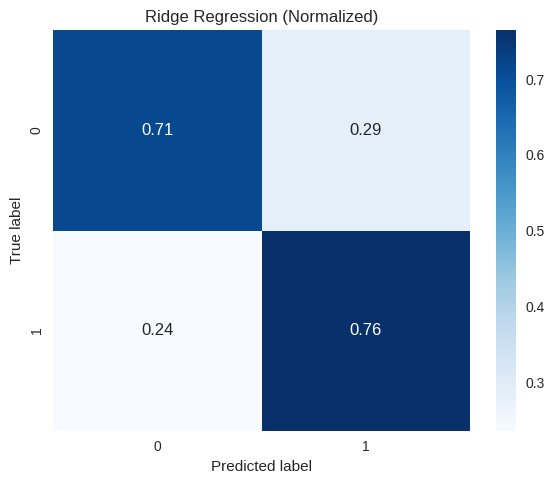


===== Classification Report (Ridge) =====
              precision    recall  f1-score   support

           0      0.817     0.715     0.762     27546
           1      0.645     0.764     0.700     18702

    accuracy                          0.735     46248
   macro avg      0.731     0.740     0.731     46248
weighted avg      0.748     0.735     0.737     46248



In [ ]:
#@title Model Training - Ridge Closed Data

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# Helpers
# -------------------------
def find_best_threshold(y_true, y_proba, objective="f1_class1", pos_label=1):
    y_true = np.asarray(y_true)
    scores = np.asarray(y_proba)

    thresholds = np.percentile(scores, np.linspace(10, 90, 20))
    thresholds = np.unique(np.concatenate([[0], thresholds, [1]]))

    best_f1 = 0
    best_thresh = 0.5
    for thresh in thresholds:
        y_pred = (scores >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=pos_label)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return float(best_thresh), float(best_f1)

def plot_normalized_confusion_matrix(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title + ' (Normalized)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# -------------------------
# Config
# -------------------------
RANDOM_STATE = 42

# -------------------------
# Data prep
# -------------------------
feature_cols = [c for c in okcupid_train.columns if c not in exclude]
X = okcupid_train[feature_cols].copy()
y = okcupid_train[target].copy()

if y.dtype == "object" or str(y.dtype).startswith("category"):
    le = LabelEncoder().fit(y)
    print("y mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
    y = pd.Series(le.transform(y))
else:
    y = pd.Series(y)

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

print(f"Dataset: {X.shape[0]} rows, {X.shape[1]} features (all numeric/bool)")

# -------------------------
# Preprocessor
# -------------------------
pre_linear = StandardScaler(with_mean=False)

# -------------------------
# STEP 1: Ridge Hyperparameter Tuning
# -------------------------
print("\n===== RIDGE: Hyperparameter Tuning =====")
ridge_base = Pipeline([
    ("pre", pre_linear),
    ("clf", LogisticRegression(
        penalty="l2", solver="lbfgs", max_iter=1000,
        class_weight="balanced", random_state=RANDOM_STATE
    ))
])

cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
ridge_search = GridSearchCV(
    ridge_base,
    param_grid={"clf__C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 25.0]},
    scoring="roc_auc",
    cv=cv_fast,
    n_jobs=-1,
    verbose=0
).fit(X, y)

best_ridge_C = ridge_search.best_params_["clf__C"]
print(f"Best Ridge C: {best_ridge_C}, CV AUC: {ridge_search.best_score_:.4f}")

# -------------------------
# STEP 2: Build Final Ridge Model
# -------------------------
ridge_final = Pipeline([
    ("pre", pre_linear),
    ("clf", LogisticRegression(
        penalty="l2", solver="lbfgs", max_iter=1000,
        C=best_ridge_C, class_weight="balanced", random_state=RANDOM_STATE
    ))
])

# -------------------------
# STEP 3: Threshold Optimization & Final Evaluation (CV)
# -------------------------
print("\n===== RIDGE: Threshold Optimization & Final Evaluation =====")
cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Evaluating Ridge...")
ridge_proba = cross_val_predict(ridge_final, X, y, cv=cv_final, method="predict_proba", n_jobs=-1)[:, 1]
ridge_threshold, _ = find_best_threshold(y, ridge_proba)
ridge_pred = (ridge_proba >= ridge_threshold).astype(int)

ridge_auc = roc_auc_score(y, ridge_proba)
ridge_f1 = f1_score(y, ridge_pred)
ridge_acc = accuracy_score(y, ridge_pred)

print(f"Ridge - Threshold: {ridge_threshold:.4f}, AUC: {ridge_auc:.4f}, F1: {ridge_f1:.4f}, Acc: {ridge_acc:.4f}")

# -------------------------
# STEP 4: Results Summary & Plots
# -------------------------
print("\n===== RIDGE: FINAL RESULTS =====")
summary_df = pd.DataFrame([{
    "Model": f"Ridge (C={best_ridge_C})",
    "Threshold": f"{ridge_threshold:.4f}",
    "ROC-AUC": f"{ridge_auc:.4f}",
    "F1-Score": f"{ridge_f1:.4f}",
    "Accuracy": f"{ridge_acc:.4f}"
}])

print("\nSummary Table:")
print(summary_df.to_string(index=False))

classes = ['0', '1']
plot_normalized_confusion_matrix(y, ridge_pred, 'Ridge Regression', classes)

print("\n===== Classification Report (Ridge) =====")
print(classification_report(y, ridge_pred, digits=3))


The model selected a regularization strength of C=0.01, achieving a strong ROC-AUC of 0.823. That means the model perform a high regularization that restricts the weights of the features.

At the optimized decision threshold (app. 0.46), it reached an overall accuracy of 73.5% and an F1-score of 0.70.

The accuracy dropped a bit as we were looking at ROC-AUC as the metric we want to maximize.

The model has imbalanced precision for males and females but pretty balanced recall (In contrast to the full model). It means that this model is pretty balanced with its capabilities to identify M/F within their own group. But the cost is more FP for females.

In [ ]:
#@title Top 15 Features (M/F) in Ridge - Open Text

# Fit final model on all data
ridge_final.fit(X, y)

# Access classifier
clf = ridge_final.named_steps["clf"]

# Use original column names
feature_names = X.columns
coef = clf.coef_.ravel()

coefs = pd.Series(coef, index=feature_names).sort_values(ascending=False)

print("Top 15 features predicting females:")
print(coefs.head(15))

print("\nTop 15 features predicting males:")
print(coefs.tail(15).sort_values(ascending=True))


Top 15 features predicting females:
body_curvy                          0.792833
orient_bisexual                     0.299825
cats_has                            0.281639
sign_fun                            0.266779
edu_professional/graduate school    0.241801
body_full figured                   0.240184
edu_college/university              0.186307
dogs_has                            0.182569
diet_vegetarian                     0.181838
kids_has_kids                       0.139227
drugs_never                         0.107039
kids_no_kids                        0.102522
job_medicine___health               0.100931
job_clerical___administrative       0.098107
religion_christianity               0.094810
dtype: float64

Top 15 features predicting males:
body_athletic                        -0.602665
job_computer___hardware___software   -0.453415
job_science___tech___engineering     -0.304923
body_fit                             -0.290597
job_construction___craftsmanship     -0.256828
inco

Comparing the full logistic regression coefficients to the Ridge model, we see that the key predictive features remain the same.

For females, "body_curvy", bisexual orientation, cats/dogs ownership, "fun" for astrological sign, and higher education continue to be strong positive predictors, along with vegetarian diet and having or not having kids.

For males, features such as athletic/fit body types, tech/engineering jobs, higher income, and construction or executive roles remain the main predictors.

We can see the model captured the difference in sexual orientation between male and female users, as "gay" helps predicting males and "bisexual" helps predicting female   

The main difference is that in the Ridge model, coefficients are slightly smaller, showing the effect of regularization, which handles extreme weights and reduces overfitting.

Overall, we see that both models find similar relationships between preferences, body type, education, occupation, and sex prediction.

After examining the features that the model found most influential we presented them in a word cloud: The larger the feature appears, the stronger its influence on predicting the gender.

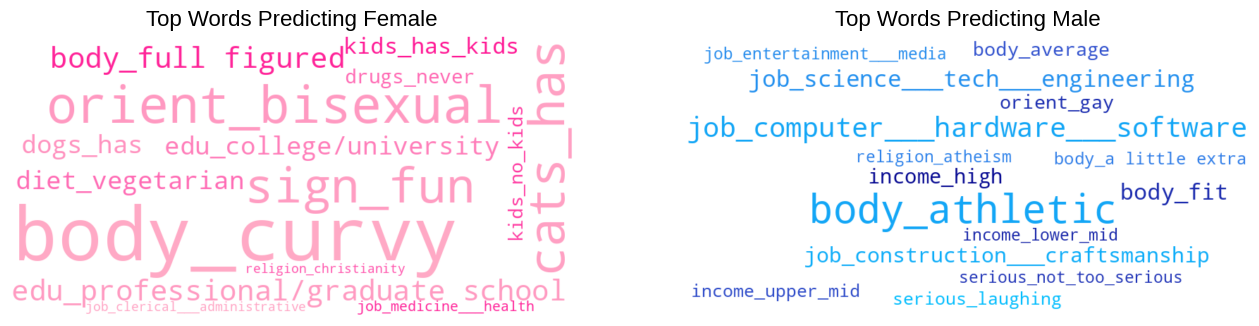

In [ ]:
#@title Word Cloud - Ridge Closed Data

from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap

# Custom strong pink and blue colormaps
pink_cmap = LinearSegmentedColormap.from_list("pink_cmap", ["deeppink", "hotpink", "pink"])
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["darkblue", "royalblue", "deepskyblue"])

# Separate female vs male predictors
top_female = coefs.head(15)
top_male   = coefs.tail(15)

# Word clouds with stronger colors
wc_female = WordCloud(width=800, height=400, background_color="white",
                      colormap=pink_cmap).generate_from_frequencies(top_female.to_dict())

wc_male = WordCloud(width=800, height=400, background_color="white",
                    colormap=blue_cmap).generate_from_frequencies(top_male.abs().to_dict())

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(wc_female, interpolation="bilinear")
axes[0].set_title("Top Words Predicting Female", fontsize=16, color="Black")
axes[0].axis("off")

axes[1].imshow(wc_male, interpolation="bilinear")
axes[1].set_title("Top Words Predicting Male", fontsize=16, color="Black")
axes[1].axis("off")

plt.show()

### GBT for Closed Data

Next we moved on to train and evaluate a Gradient Boosting classifier on the dataset.

We used a randomized search with cross-validation to tune key hyperparameters (e.g., depth, learning rate, regularization).

With the best settings, we built a final model and analyzed its classification success.


===== GBT: Hyperparameter Tuning (regularized) =====
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best GBT params: {'min_samples_leaf': 100, 'max_leaf_nodes': 31, 'max_iter': 300, 'max_depth': 8, 'learning_rate': 0.05, 'l2_regularization': 0.5}
Best GBT CV AUC: 0.8289

===== GBT: Threshold Optimization & Final Evaluation =====
Evaluating GBT...
GBT - Threshold: 0.3711, AUC: 0.8300, F1: 0.7068, Acc: 0.7410

===== GBT: FINAL RESULTS =====

Summary Table:
      Model Threshold ROC-AUC F1-Score Accuracy
GBT (tuned)    0.3711  0.8300   0.7068   0.7410


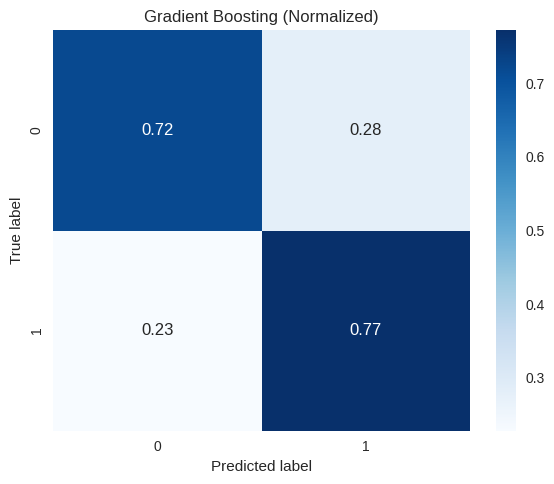


===== Classification Report (GBT) =====
              precision    recall  f1-score   support

           0      0.823     0.720     0.768     27546
           1      0.652     0.772     0.707     18702

    accuracy                          0.741     46248
   macro avg      0.737     0.746     0.737     46248
weighted avg      0.754     0.741     0.743     46248


Best GBT Parameters: {'min_samples_leaf': 100, 'max_leaf_nodes': 31, 'max_iter': 300, 'max_depth': 8, 'learning_rate': 0.05, 'l2_regularization': 0.5}


In [ ]:
#@title Model Training - GBT Closed Data

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# Helpers
# -------------------------
def find_best_threshold(y_true, y_proba, pos_label=1):
    """Fast threshold optimization for F1"""
    y_true = np.asarray(y_true)
    scores = np.asarray(y_proba)

    thresholds = np.percentile(scores, np.linspace(10, 90, 20))
    thresholds = np.unique(np.concatenate([[0], thresholds, [1]]))

    best_f1 = 0
    best_thresh = 0.5
    for thresh in thresholds:
        y_pred = (scores >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, pos_label=pos_label)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return float(best_thresh), float(best_f1)


def plot_normalized_confusion_matrix(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title + ' (Normalized)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# -------------------------
# Config
# -------------------------
RANDOM_STATE = 42

# -------------------------
# Data prep
# -------------------------
feature_cols = [c for c in okcupid_train.columns if c not in exclude]
X = okcupid_train[feature_cols].copy()
y = okcupid_train[target].copy()

if y.dtype == "object" or str(y.dtype).startswith("category"):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder().fit(y)
    print("y mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
    y = pd.Series(le.transform(y))
else:
    y = pd.Series(y)

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

numeric_cols = X.columns.tolist()  # all features are numeric or bool

# -------------------------
# Preprocessor
# -------------------------
from sklearn.compose import ColumnTransformer
pre_tree = ColumnTransformer([
    ("num", "passthrough", numeric_cols)
], remainder="drop")


# -------------------------
# STEP 1: GBT Hyperparameter Tuning
# -------------------------
print("\n===== GBT: Hyperparameter Tuning (regularized) =====")

gbt_base = Pipeline([
    ("pre", pre_tree),
    ("clf", HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1,
        max_bins=255,
        scoring='loss'
    ))
])

gbt_param_dist = {
    "clf__max_iter": [150, 200, 300],
    "clf__learning_rate": [0.03, 0.05, 0.08],
    "clf__max_depth": [2, 3, 5, 8],
    "clf__min_samples_leaf": [20, 50, 100],
    "clf__l2_regularization": [0.0, 0.1, 0.5, 1.0],
    "clf__max_leaf_nodes": [16, 31, 63],
}

cv_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
gbt_search = RandomizedSearchCV(
    gbt_base,
    param_distributions=gbt_param_dist,
    n_iter=12,
    scoring="roc_auc",
    cv=cv_fast,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
).fit(X, y)

best_gbt_params = {k.replace("clf__", ""): v for k, v in gbt_search.best_params_.items()}
print(f"Best GBT params: {best_gbt_params}")
print(f"Best GBT CV AUC: {gbt_search.best_score_:.4f}")

# -------------------------
# STEP 2: Build Final GBT Model
# -------------------------
gbt_final = Pipeline([
    ("pre", pre_tree),
    ("clf", HistGradientBoostingClassifier(
        **best_gbt_params,
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1,
        scoring='loss'
    ))
])

# -------------------------
# STEP 3: Threshold Optimization & Final Evaluation (CV)
# -------------------------
print("\n===== GBT: Threshold Optimization & Final Evaluation =====")
cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Evaluating GBT...")
gbt_proba = cross_val_predict(gbt_final, X, y, cv=cv_final, method="predict_proba", n_jobs=-1)[:, 1]

gbt_threshold, _ = find_best_threshold(y, gbt_proba)
gbt_pred = (gbt_proba >= gbt_threshold).astype(int)

gbt_auc = roc_auc_score(y, gbt_proba)
gbt_f1 = f1_score(y, gbt_pred)
gbt_acc = accuracy_score(y, gbt_pred)

print(f"GBT - Threshold: {gbt_threshold:.4f}, AUC: {gbt_auc:.4f}, F1: {gbt_f1:.4f}, Acc: {gbt_acc:.4f}")

# -------------------------
# STEP 4: Results Summary & Plots
# -------------------------
print("\n===== GBT: FINAL RESULTS =====")
summary_df = pd.DataFrame([{
    "Model": "GBT (tuned)",
    "Threshold": f"{gbt_threshold:.4f}",
    "ROC-AUC": f"{gbt_auc:.4f}",
    "F1-Score": f"{gbt_f1:.4f}",
    "Accuracy": f"{gbt_acc:.4f}"
}])

print("\nSummary Table:")
print(summary_df.to_string(index=False))

classes = ['0', '1']
plot_normalized_confusion_matrix(y, gbt_pred, 'Gradient Boosting', classes)

print("\n===== Classification Report (GBT) =====")
print(classification_report(y, gbt_pred, digits=3))

print(f"\nBest GBT Parameters: {best_gbt_params}")


The GBT model has very similar results to the Ridge model, with a (0.05 - 0.1) improvement in each of the metrics, achieving a strong ROC-AUC of 0.829, accuracy of 0.741 and F1 of 0.707. With the same imrovements for precision and recall.

Now will analyze the top features for the GBT model.

Notice that finding the important features for GBT is not as easy as in Logistic Regression.

The way to do that is by using permutations: Finding features by shuffling each feature individually and measuring how much the model's performance drops. Features that cause a bigger drop are considered more important. (This way is computationally expensive so we took a 10000 user sample to calculate it).

In [ ]:
#@title Top 25 features by GBT - Closed Data

from sklearn.inspection import permutation_importance

# Fit final model on all data
gbt_final.fit(X, y)

# Take a sample of the data for faster computation
sample_size = min(10000, X.shape[0])  # use up to 10000 rows
X_sample = X.sample(sample_size, random_state=42)
y_sample = y.loc[X_sample.index]

# Approximate permutation importance
result = permutation_importance(
    gbt_final, X_sample, y_sample,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'feature': numeric_cols,
    'importance': result.importances_mean
})

# Top 25
top25 = feat_imp_df.sort_values(by='importance', ascending=False).head(25)

# Display as list
print("Top 25 Features by Approximate Permutation Importance:")
for i, row in enumerate(top25.itertuples(), 1):
    print(f"{i}. {row.feature} (importance: {row.importance:.4f})")


Top 25 Features by Approximate Permutation Importance:
1. body_curvy (importance: 0.0399)
2. body_athletic (importance: 0.0342)
3. orient_gay (importance: 0.0171)
4. cats_has (importance: 0.0142)
5. sign_fun (importance: 0.0136)
6. orient_bisexual (importance: 0.0130)
7. job_computer___hardware___software (importance: 0.0130)
8. job_science___tech___engineering (importance: 0.0094)
9. edu_professional/graduate school (importance: 0.0087)
10. body_fit (importance: 0.0075)
11. body_full figured (importance: 0.0074)
12. edu_college/university (importance: 0.0073)
13. drugs_never (importance: 0.0057)
14. serious_laughing (importance: 0.0052)
15. dogs_has (importance: 0.0048)
16. religion_atheism (importance: 0.0046)
17. income_high (importance: 0.0043)
18. diet_vegetarian (importance: 0.0043)
19. job_medicine___health (importance: 0.0036)
20. job_construction___craftsmanship (importance: 0.0036)
21. kids_has_kids (importance: 0.0035)
22. income_upper_mid (importance: 0.0034)
23. income_low

We can see that the features found in the Ridge model, are presented in here as well. That mean that both model identify the same traits for distincting between males and females.

The interpretability benefits of logistic regression help in understanding how the features in GBT contribute to distinction.

 Since both LR and GBT pick the same top features, it means these features are clearly important and strongly linked to the outcome, and certain categories stand out as especially predictive, no matter the model.

We then wanted to make sure the train-validation scores for both models.

In [ ]:
#@title Train-Validation Diagnostics for Closed Data Models

from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, make_scorer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- small fix: OHE_sparse fallback had a typo earlier ---
def OHE_sparse(sparse_out=True):
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=sparse_out)
    except TypeError:
        # older sklearn uses 'sparse' instead of 'sparse_output'
        return OneHotEncoder(handle_unknown="ignore", sparse=sparse_out)

def _proba_for_binary(est, X_):
    if hasattr(est, "predict_proba"):
        p = est.predict_proba(X_)
        return p[:, 1] if p.shape[1] == 2 else p[:, -1]
    elif hasattr(est, "decision_function"):
        d = est.decision_function(X_)
        # scale to [0,1] so AUC works
        return (d - d.min()) / (d.max() - d.min() + 1e-12)
    else:
        # worst case fallback
        return est.predict(X_).astype(float)

def evaluate_overfitting(estimator, X, y, threshold, n_splits=5, random_state=42, name="model"):
    """Return per-fold train/val metrics & plots to assess overfitting."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    rows = []
    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        est = clone(estimator)
        est.fit(X_tr, y_tr)

        # probabilities
        p_tr = _proba_for_binary(est, X_tr)
        p_va = _proba_for_binary(est, X_va)

        # thresholded predictions for F1/Acc
        yhat_tr = (p_tr >= threshold).astype(int)
        yhat_va = (p_va >= threshold).astype(int)

        # metrics
        auc_tr = roc_auc_score(y_tr, p_tr)
        auc_va = roc_auc_score(y_va, p_va)
        f1_tr  = f1_score(y_tr, yhat_tr)
        f1_va  = f1_score(y_va, yhat_va)
        acc_tr = accuracy_score(y_tr, yhat_tr)
        acc_va = accuracy_score(y_va, yhat_va)

        rows.append({
            "fold": fold,
            "train_auc": auc_tr, "val_auc": auc_va, "gap_auc": auc_tr - auc_va,
            "train_f1": f1_tr,  "val_f1":  f1_va,  "gap_f1":  f1_tr - f1_va,
            "train_acc": acc_tr,"val_acc": acc_va,"gap_acc": acc_tr - acc_va,
        })

    df = pd.DataFrame(rows)

    # Summary table with mean ± 95% CI (t-approx with n_folds)
    def mean_ci(x):
        m = np.mean(x)
        s = np.std(x, ddof=1)
        n = len(x)
        # 95% t critical for small n; use scipy? keep simple with 1.96
        ci = 1.96 * s / np.sqrt(n) if n > 1 else 0.0
        return f"{m:.4f} ± {ci:.4f}"

    summary = pd.DataFrame({
        "metric": ["AUC", "F1", "Accuracy"],
        "train (mean±95%CI)": [mean_ci(df["train_auc"]), mean_ci(df["train_f1"]), mean_ci(df["train_acc"])],
        "val (mean±95%CI)":   [mean_ci(df["val_auc"]),   mean_ci(df["val_f1"]),   mean_ci(df["val_acc"])],
        "gap train−val":      [f"{df['gap_auc'].mean():.4f}", f"{df['gap_f1'].mean():.4f}", f"{df['gap_acc'].mean():.4f}"]
    })

    print(f"\n======== {name}: Train vs. Validation by Fold ========")
    print(df.round(4).to_string(index=False))
    print(f"\n======== {name}: Summary (mean across {n_splits} folds) ========")
    print(summary.to_string(index=False))

    # --- Plot: per-fold AUC train vs. val + gap ---
    plt.figure(figsize=(7.5, 5.5))
    idx = np.arange(len(df))
    width = 0.35
    plt.bar(idx - width/2, df["train_auc"], width, label="Train AUC")
    plt.bar(idx + width/2, df["val_auc"],   width, label="Validation AUC")
    for i, g in enumerate(df["gap_auc"]):
        plt.text(i, max(df["train_auc"][i], df["val_auc"][i]) + 0.01, f"Δ={g:.3f}", ha="center", va="bottom", fontsize=9)
    plt.xticks(idx, [f"Fold {i}" for i in df["fold"]])
    plt.ylim(0.0, 1.08)
    plt.title(f"{name}: Train vs. Validation AUC by Fold")
    plt.ylabel("AUC")
    plt.legend(loc="lower right")
    plt.show()

    return df, summary

from sklearn.base import clone

# Define N_FOLDS and threshold values
N_FOLDS = 5
RIDGE_THRESHOLD = ridge_threshold
GBT_THRESHOLD = gbt_threshold

def quick_check(df, name):
    mean_gap_auc = df["gap_auc"].mean()
    max_gap_auc  = df["gap_auc"].max()
    print(f"\n{name} — AUC gaps: mean Δ={mean_gap_auc:.4f}, max Δ={max_gap_auc:.4f}")


======== Ridge (C=0.01): Train vs. Validation by Fold ========
 fold  train_auc  val_auc  gap_auc  train_f1  val_f1  gap_f1  train_acc  val_acc  gap_acc
    1     0.8251   0.8254  -0.0003    0.7000  0.7025 -0.0025     0.7348   0.7364  -0.0016
    2     0.8282   0.8127   0.0155    0.7040  0.6913  0.0127     0.7388   0.7299   0.0089
    3     0.8229   0.8334  -0.0105    0.6988  0.7092 -0.0104     0.7336   0.7431  -0.0095
    4     0.8264   0.8198   0.0065    0.7022  0.6968  0.0054     0.7370   0.7318   0.0052
    5     0.8253   0.8236   0.0017    0.7033  0.6988  0.0045     0.7377   0.7326   0.0051

======== Ridge (C=0.01): Summary (mean across 5 folds) ========
  metric train (mean±95%CI) val (mean±95%CI) gap train−val
     AUC    0.8256 ± 0.0017  0.8230 ± 0.0066        0.0026
      F1    0.7017 ± 0.0019  0.6997 ± 0.0058        0.0019
Accuracy    0.7364 ± 0.0019  0.7348 ± 0.0046        0.0016


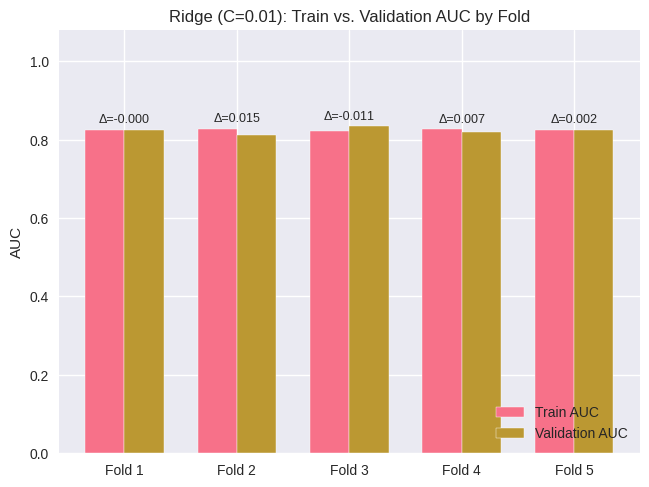


Ridge — AUC gaps: mean Δ=0.0026, max Δ=0.0155


In [ ]:
#@title Ridge Test Diagnostics for Closed Data

ridge_df, ridge_summary = evaluate_overfitting(ridge_final, X, y, threshold=RIDGE_THRESHOLD, n_splits=N_FOLDS, random_state=RANDOM_STATE, name=f"Ridge (C={best_ridge_C})")
quick_check(ridge_df, "Ridge")

The Ridge model with shows very consistent performance across folds, with training and validation scores nearly identical (AUC = 0.826 vs. 0.823, F1 of about 0.70, Accuracy = 0.735).

The small gaps (all less than 0.02). Indicate the model generalizes well, with no meaningful overfitting.


======== Gradient Boosting: Train vs. Validation by Fold ========
 fold  train_auc  val_auc  gap_auc  train_f1  val_f1  gap_f1  train_acc  val_acc  gap_acc
    1     0.8583   0.8333   0.0250    0.7329  0.7109  0.0220     0.7643   0.7450   0.0193
    2     0.8579   0.8220   0.0359    0.7319  0.6988  0.0331     0.7636   0.7352   0.0284
    3     0.8549   0.8390   0.0159    0.7274  0.7147  0.0127     0.7594   0.7486   0.0107
    4     0.8586   0.8257   0.0329    0.7331  0.7051  0.0281     0.7646   0.7382   0.0263
    5     0.8589   0.8297   0.0292    0.7342  0.7048  0.0294     0.7652   0.7381   0.0270

======== Gradient Boosting: Summary (mean across 5 folds) ========
  metric train (mean±95%CI) val (mean±95%CI) gap train−val
     AUC    0.8577 ± 0.0014  0.8300 ± 0.0058        0.0278
      F1    0.7319 ± 0.0023  0.7068 ± 0.0054        0.0250
Accuracy    0.7634 ± 0.0020  0.7410 ± 0.0049        0.0224


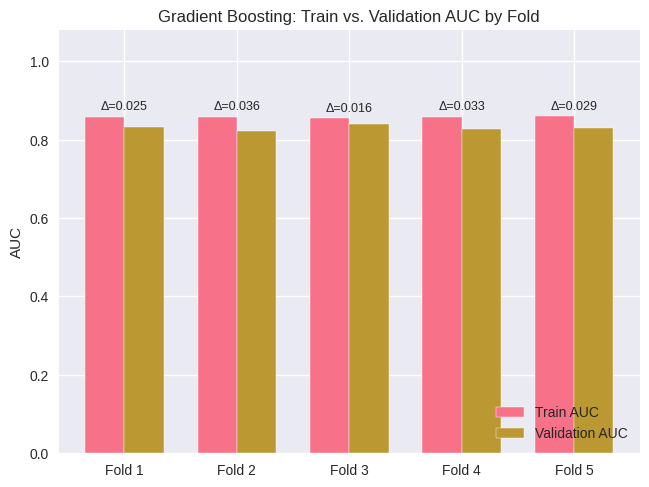


Gradient Boosting — AUC gaps: mean Δ=0.0278, max Δ=0.0359


In [ ]:
#@title GBT Test Diagnostics for Closed Data

gbt_df, gbt_summary = evaluate_overfitting(gbt_final, X, y, threshold=GBT_THRESHOLD, n_splits=N_FOLDS, random_state=RANDOM_STATE, name="Gradient Boosting")
quick_check(gbt_df, "Gradient Boosting")

The GBT model achieves strong validation results (AUC = 0.83, F1 = 0.71, Accuracy = 0.74), but its training scores are consistently a bit higher, with an average gap of about 0.028 in AUC across folds.

This indicates the model is slightly more tuned to the training data than Ridge, but still generalizes well and delivers solid performance on unseen data.

We tried to address this issue by limiting the tree depth, but we saw that the model performance dropped. This happened probably because shallower trees have less capacity to capture complex patterns in the data.

## Training Ridge and GBT Models for Open Text

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.0 MB/s eta 0:00:00


While working with the two models, we had to make decisions on several preprocessing choices, including whether to include stopwords and how to handle n-grams.

We decided to use 3-grams for the text, which allows the model to capture meaningful sequences of three consecutive words, such as "I love you" or "looking for". These phrases carry more context and meaning than single words alone, that will help our model achieve better results.

Because many of phrases include common words like "I" or "for", we also chose to include stopwords in the model. To keep important multi-word expressions during feature extraction.

Another important aspect was feature selection. We applied statistical tests to reduce the dimensionality: a chi-squared test for text features and an ANOVA F-test for numeric features. We kept only predictors with a significance level of alpha = 0.2, which resulted in 7,990 features.

While this is still a relatively large number, it is much smaller than the initial 50,000 features generated by the TF-IDF representation. In the context of textual data, keeping more features can be beneficial, since even words with weaker associations may still contribute useful signals when combined, while using regularization helps prevent overfitting.

### Ridge for Open Text

Here we build a logistic regression (L2-regularized) classifier using open-text essay responses and numeric features from the dataset.

First, we create features by applying TF-IDF vectorization to the essay text and scaling numeric variables (word counts, punctuation ratio, etc.).

For model tuning, we use Bayesian optimization with cross-validation, this is ideal here because it efficiently searches a large, continuous hyperparameter space while maintaining robust performance estimates. This is very helpful for text-based models with thousands of features.

We chose TF-IDF because it converts raw text into meaningful numeric features, getting both the frequency of a word in a user's essays (term frequency) and how distinctive that word is across the entire dataset (inverse document frequency), making it more effective than plain Bag-of-Words.

-> Building features...
-> Selected 7990 features.
-> Starting Bayesian optimization with k-fold CV (Logistic Regression, L2)...
-> Bayesian optimization complete.
Best params from Bayesian optimization: OrderedDict({'C': 1.5783879853890563})

===== Fold 1 =====
Accuracy: 0.8332, F1: 0.7844, ROC AUC: 0.9111
Confusion Matrix:
 [[8169 1013]
 [1558 4676]]

===== Fold 2 =====
Accuracy: 0.8371, F1: 0.7896, ROC AUC: 0.9109
Confusion Matrix:
 [[8190  992]
 [1520 4714]]

===== Fold 3 =====
Accuracy: 0.8333, F1: 0.7848, ROC AUC: 0.9112
Confusion Matrix:
 [[8159 1023]
 [1547 4687]]

===== Average Metrics Across Folds =====
fold         2.000000
accuracy     0.834523
f1           0.786270
roc_auc      0.911082
precision    0.822975
recall       0.752700
dtype: float64
-> Final model trained on full dataset.

===== LR-TEXT: FINAL RESULTS =====
             Model ROC-AUC F1-Score Accuracy
LR-TEXT (C=1.5784)  0.9140   0.8382   0.8395


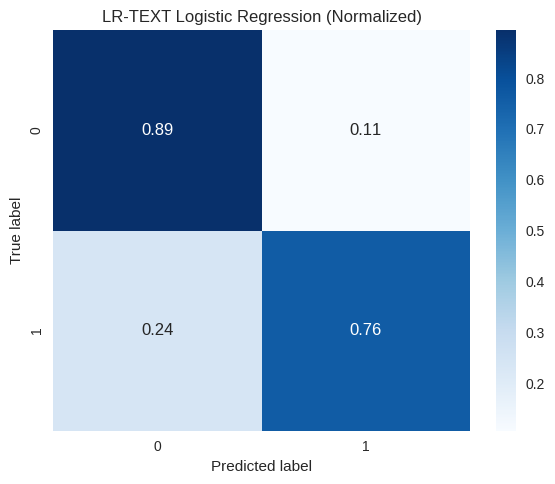


===== Classification Report (LR-TEXT) =====
              precision    recall  f1-score   support

           0      0.846     0.894     0.869     27546
           1      0.829     0.759     0.793     18702

    accuracy                          0.839     46248
   macro avg      0.837     0.827     0.831     46248
weighted avg      0.839     0.839     0.838     46248



In [ ]:
#@title Model Training - Ridge Open Text

# =========================
# LIBRARIES
# =========================
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, f_classif
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack, csr_matrix
from skopt import BayesSearchCV
from skopt.space import Real

# =========================
# CONFIG
# =========================
essay_cols = [f"essay{i}_lemmatized" for i in range(10)]
numeric_cols = [f"essay{i}_wc" for i in range(10)] + ['punct_ratio', 'prompts_filled', 'total_smileys_count']
target_col = 'sex'
RANDOM_STATE = 42

# =========================
# HELPERS
# =========================
def plot_normalized_confusion_matrix(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title + ' (Normalized)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# =========================
# FEATURE BUILDING
# =========================
def build_features(df, ngram_range=(1,3), vectorizers=None, fit=True,
                   feature_selector=None, alpha=0.2, scaler=None):
    print("-> Building features...")
    tfidf_vectors = []
    new_vectorizers = []

    # ---- Text features ----
    for i, col in enumerate(essay_cols):
        if fit or vectorizers is None:
            vec = TfidfVectorizer(ngram_range=ngram_range, stop_words=None, max_features=5000)
            X_col = vec.fit_transform(df[col].fillna(''))
            new_vectorizers.append(vec)
        else:
            vec = vectorizers[i]
            X_col = vec.transform(df[col].fillna(''))
            new_vectorizers.append(vec)
        tfidf_vectors.append(X_col)

    X_text = hstack(tfidf_vectors)

    # ---- Numeric features ----
    if fit or scaler is None:
        scaler = StandardScaler()
        X_numeric = scaler.fit_transform(df[numeric_cols])
    else:
        X_numeric = scaler.transform(df[numeric_cols])

    X_combined = hstack([X_text, csr_matrix(X_numeric)])

    # ---- Feature selection ----
    if fit:
        chi2_scores, chi2_p = chi2(X_text, df[target_col])
        f_scores, f_p = f_classif(X_numeric, df[target_col])
        combined_p = np.concatenate([chi2_p, f_p])
        combined_scores = np.concatenate([chi2_scores, f_scores])

        significant_mask = combined_p < alpha
        if significant_mask.sum() == 0:
            # fallback: keep top 1000 features by score
            top_indices = np.argsort(combined_scores)[-1000:]
        else:
            top_indices = np.where(significant_mask)[0]

        class PValueSelector:
            def __init__(self, indices, p_values):
                self.indices = indices
                self.p_values = p_values[indices]
            def transform(self, X):
                return X[:, self.indices]
            def fit_transform(self, X, y=None):
                return self.transform(X)

        selector = PValueSelector(top_indices, combined_p)
        X_final = selector.transform(X_combined)
        print(f"-> Selected {X_final.shape[1]} features.")
        return X_final, new_vectorizers, scaler, selector
    elif feature_selector is not None:
        X_final = feature_selector.transform(X_combined)
        return X_final, new_vectorizers, scaler, feature_selector
    else:
        return X_combined, new_vectorizers, scaler, None

# =========================
# BAYESIAN OPTIMIZATION WITH K-FOLD CV (LogReg, L2 only)
# =========================
def bayes_opt_lr_cv(X, y, n_iter=15, cv=3):
    print("-> Starting Bayesian optimization with k-fold CV (Logistic Regression, L2)...")
    lr_model = LogisticRegression(
        penalty='l2',
        solver="lbfgs",
        max_iter=5000,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    search_spaces = {
        'C': Real(1e-3, 10, prior='log-uniform')
    }

    opt = BayesSearchCV(
        estimator=lr_model,
        search_spaces=search_spaces,
        n_iter=n_iter,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    opt.fit(X, y)
    print("-> Bayesian optimization complete.")
    return opt.best_estimator_, opt.best_params_

# =========================
# K-FOLD CROSS-VALIDATION (per-fold reporting)
# =========================
def kfold_lr(df, n_splits=3, ngram_range=(1,3), bayes_iter=15, alpha=0.2):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    metrics = []

    # Build features on full dataset for Bayesian optimization
    X_full, vectorizers, scaler, selector = build_features(
        df,
        ngram_range=ngram_range,
        fit=True,
        alpha=alpha,
        scaler=None
    )
    y_full = df[target_col].values

    # Single Bayesian optimization
    best_model, best_params = bayes_opt_lr_cv(X_full, y_full, n_iter=bayes_iter, cv=n_splits)
    print(f"Best params from Bayesian optimization: {best_params}")

    # Train & evaluate folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, y_full)):
        print(f"\n===== Fold {fold+1} =====")
        X_train, X_val = X_full[train_idx], X_full[val_idx]
        y_train, y_val = y_full[train_idx], y_full[val_idx]

        model = LogisticRegression(
            penalty='l2',
            C=best_params['C'],
            solver="lbfgs",
            max_iter=5000,
            n_jobs=-1,
            random_state=RANDOM_STATE
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:,1]

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc = roc_auc_score(y_val, y_proba)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        cm = confusion_matrix(y_val, y_pred)

        print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {roc:.4f}")
        print("Confusion Matrix:\n", cm)
        metrics.append({'fold': fold+1, 'accuracy': acc, 'f1': f1, 'roc_auc': roc, 'precision': prec, 'recall': rec})

    metrics_df = pd.DataFrame(metrics)
    print("\n===== Average Metrics Across Folds =====")
    print(metrics_df.mean())

    # Train final model on full dataset
    final_model = LogisticRegression(
        penalty='l2',
        C=best_params['C'],
        solver="lbfgs",
        max_iter=5000,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    final_model.fit(X_full, y_full)
    print("-> Final model trained on full dataset.")

    cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    y_proba_cv = cross_val_predict(final_model, X_full, y_full, cv=cv_final, method="predict_proba", n_jobs=-1)[:, 1]
    y_pred_cv  = (y_proba_cv >= 0.5).astype(int)  # fixed threshold 0.5

    auc_cv = roc_auc_score(y_full, y_proba_cv)
    f1_cv  = f1_score(y_full, y_pred_cv, average='weighted') # notice if not woking the drop average='weighted'
    acc_cv = accuracy_score(y_full, y_pred_cv)

    print("\n===== LR-TEXT: FINAL RESULTS =====")
    summary_df = pd.DataFrame([{
        "Model": f"LR-TEXT (C={best_params['C']:.4f})",
        "ROC-AUC": f"{auc_cv:.4f}",
        "F1-Score": f"{f1_cv:.4f}",
        "Accuracy": f"{acc_cv:.4f}"
    }])
    print(summary_df.to_string(index=False))

    classes = ['0', '1']
    plot_normalized_confusion_matrix(y_full, y_pred_cv, 'LR-TEXT Logistic Regression', classes)

    print("\n===== Classification Report (LR-TEXT) =====")
    print(classification_report(y_full, y_pred_cv, digits=3))

    return metrics_df, final_model, vectorizers, scaler, selector, summary_df

# =========================
# RUN
# =========================
lr_metrics_df, lr_final_model, lr_vectorizers, lr_scaler, lr_selector, lr_summary = kfold_lr(
    okcupid_train,
    n_splits=3,
    ngram_range=(1,3),
    bayes_iter=15
)


These L2 regularization in the open text model returned a C = 1.578 which is pretty moderate, and not as harsh as it was in the closed data one.

We can see that the model performs very strongly across folds. It consistently achieves about 83.5% accuracy, 0.83 avg F1-score, and 0.914 ROC-AUC indicating the model's high effectiveness at distinguishing between males and females.

The precision (0.84) balanced, when recall at females (0.759) is lower than the rest, means that the model struggles a bit to classify females within category.

The small variation between folds indicates stable generalization, meaning the model is reliably capturing useful linguistic and numeric signals from the essays and related features.

In [ ]:
#@title Top 25 Features (M/F) in Ridge - Open Text

def get_top_features_lr(final_model, vectorizers, scaler, selector, top_n=15):
    # Collect feature names for text
    feature_names = []
    for i, vec in enumerate(vectorizers):
        essay_feats = [f"essay{i}_tfidf:{t}" for t in vec.get_feature_names_out()]
        feature_names.extend(essay_feats)

    # Add numeric feature names
    feature_names.extend(numeric_cols)

    # Apply same feature selection mask
    feature_names = np.array(feature_names)[selector.indices]

    # Get coefficients
    coefs = final_model.coef_[0]  # shape: (n_features,)

    # Sort features by coefficient magnitude
    top_pos_idx = np.argsort(coefs)[-top_n:]        # strongest positive (female)
    top_neg_idx = np.argsort(coefs)[:top_n]         # strongest negative (male)

    top_pos = [(feature_names[i], coefs[i]) for i in reversed(top_pos_idx)]
    top_neg = [(feature_names[i], coefs[i]) for i in top_neg_idx]

    print("\nTop features for FEMALE (positive coefficients):")
    for f, c in top_pos:
        print(f"{f:30s} {c:.4f}")

    print("\nTop features for MALE (negative coefficients):")
    for f, c in top_neg:
        print(f"{f:30s} {c:.4f}")

    return top_pos, top_neg

top_female, top_male = get_top_features_lr(lr_final_model, lr_vectorizers, lr_scaler, lr_selector, top_n=25)



Top features for FEMALE (positive coefficients):
essay0_tfidf:girl              6.7029
essay0_tfidf:gal               4.8291
essay3_tfidf:girl              4.6195
essay3_tfidf:heel              4.5962
essay3_tfidf:boob              4.1164
essay4_tfidf:girl              4.0688
essay0_tfidf:heel              3.9814
essay0_tfidf:sassy             3.9658
essay0_tfidf:chick             3.9572
essay0_tfidf:men               3.9276
essay2_tfidf:baking            3.7979
essay3_tfidf:petite            3.6245
essay5_tfidf:lipstick          3.4812
essay7_tfidf:girl              3.4148
essay4_tfidf:cheese            3.3653
essay4_tfidf:amelie            3.2708
essay5_tfidf:makeup            3.2630
essay0_tfidf:dress             3.2182
essay4_tfidf:bone              3.2069
essay3_tfidf:small             3.0836
essay3_tfidf:short             3.0833
essay0_tfidf:please            3.0828
essay5_tfidf:heel              3.0225
essay4_tfidf:twilight          2.8995
essay0_tfidf:mother            2.8890


These results show the words most strongly associated with predicting female vs. male in the logistic regression text model.

Positive coefficients (female predictors) highlight terms linked to stereotypically feminine language or topics (e.g., girl, heel, sassy, lipstick, makeup, baking), while negative coefficients (male predictors) emphasize words tied to masculine identity or hobbies (e.g., guy, beard, handsome, guitar, motorcycle, dude).

An interesting phenomenon we found is that most important words come from specific essays (0 - My self summary, 3 - The first thing people usually notice about me).

Usually when people present themselves (about me) or their looks (The first thing people usually notice about me) we can get some gender reveiling words as guy, girl, woman (description), or beard, heel, short (looks).

For males, we can see 5 is more revealing - "The six things I could never do without" - talking about masculine hobbies gives their gender as well (woman, guitar, motorcycle, sport).

While for females, it is 4 - "Favorite books, movies, show, music, and food" - we can see girly like movies as Twighlight and Amelie (which is also a name).

Another thing to pay attention to is the essays that are not on the list (6 - I spend a lot of time thinking about, 8 - The most private thing I am willing to admit). These provide more unique answers, which makes it less likely to find common phrases for males or females.

After examining the words that the model found most influential we presented them in a word cloud: The larger the word appears, the stronger its influence on predicting the gender.

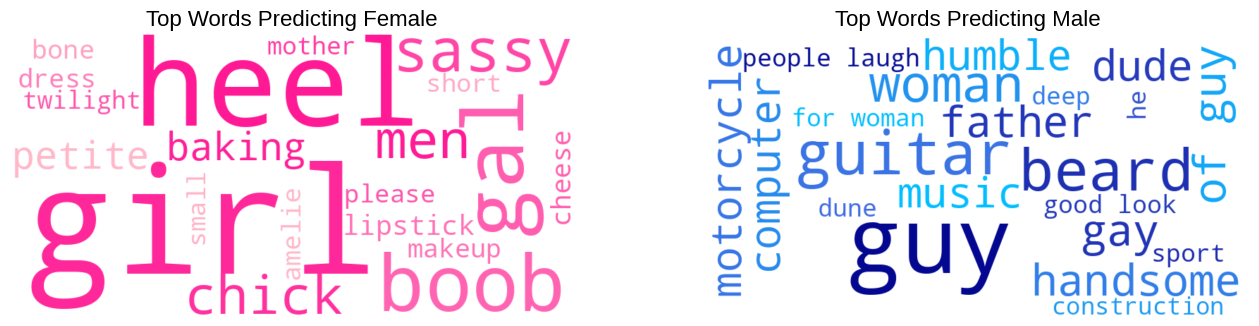

In [ ]:
#@title Word Cloud - Ridge Open Text

def make_wordcloud_from_coefs_dict(top_features_dict, cmap):
    """
    top_features_dict: dict {word: coef, ...}
    cmap: colormap to use for word cloud
    """
    wc = WordCloud(width=800, height=400, background_color='white', colormap=cmap)
    wc.generate_from_frequencies(top_features_dict)
    return wc

# Convert top features lists to dictionaries
def features_to_dict(top_features, gender='female'):
    word_weights = {}
    for feat, coef in top_features:
        # Extract word
        if "tfidf:" in feat:
            word = feat.split("tfidf:")[1]
        else:
            word = feat
        # Sum coefficients, use abs for male
        weight = abs(coef) if gender == 'male' else coef
        if word in word_weights:
            word_weights[word] += weight
        else:
            word_weights[word] = weight
    return word_weights

# Prepare dictionaries
female_dict = features_to_dict(top_female, gender='female')
male_dict   = features_to_dict(top_male, gender='male')

# Generate word clouds
wc_female = make_wordcloud_from_coefs_dict(female_dict, pink_cmap)
wc_male   = make_wordcloud_from_coefs_dict(male_dict, blue_cmap)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(wc_female, interpolation='bilinear')
axes[0].set_title("Top Words Predicting Female", fontsize=16, color='black')
axes[0].axis('off')

axes[1].imshow(wc_male, interpolation='bilinear')
axes[1].set_title("Top Words Predicting Male", fontsize=16, color='black')
axes[1].axis('off')

plt.show()


### GBT for Open Text

Next we train a GBT classifier on the essays and numeric features, using TF-IDF vectorization, scaling, and the same statistical feature selection as before.

We apply Bayesian optimization with k-fold cross-validation to tune hyperparameters and evaluate performance, where k-fold ensures each sample is used for both training and validation.

Since TF-IDF produces thousands of features and optimization requires fitting many models across folds. The process is slower than LR but allows GBT to capture richer non-linear patterns in the data.


-> Building features...
-> Starting Bayesian optimization with k-fold CV...
[LightGBM] [Info] Number of positive: 18702, number of negative: 27546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 8.803961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759028
[LightGBM] [Info] Number of data points in the train set: 46248, number of used features: 7989
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.404385 -> initscore=-0.387227
[LightGBM] [Info] Start training from score -0.387227
-> Bayesian optimization complete.
Best params from Bayesian optimization: OrderedDict({'colsample_bytree': 0.7717015338451563, 'learning_rate': 0.22854155758290642, 'max_depth': 11, 'n_estimators': 427, 'num_leaves': 16, 'subsample': 0.5255672768385259})

===== Fold 1 =====
[LightGBM] [Info] Number of positive: 12468, number of negative: 18364
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testi

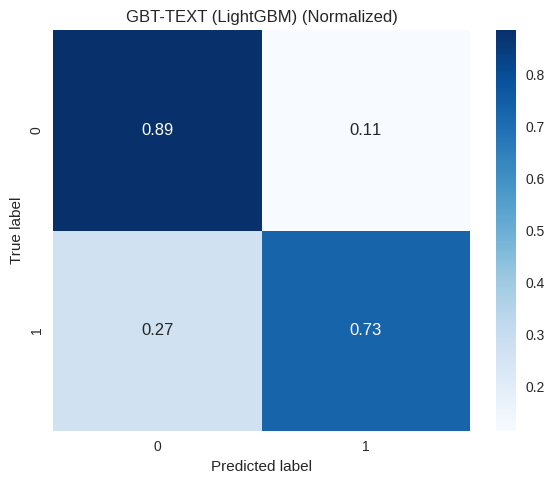


===== Classification Report (GBT-TEXT) =====
              precision    recall  f1-score   support

           0      0.828     0.885     0.856     27546
           1      0.812     0.729     0.768     18702

    accuracy                          0.822     46248
   macro avg      0.820     0.807     0.812     46248
weighted avg      0.821     0.822     0.820     46248



In [ ]:
# @title Model Training With Bayesian Opt. - GBT Open Text
# # =========================
# # LIBRARIES
# # =========================
# from sklearn.model_selection import StratifiedKFold, cross_val_predict
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import chi2, f_classif
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, classification_report
# from scipy.sparse import hstack, csr_matrix
# import lightgbm as lgb
# from skopt import BayesSearchCV
# from skopt.space import Real, Integer


# # =========================
# # CONFIG
# # =========================
# essay_cols = [f"essay{i}_lemmatized" for i in range(10)]
# numeric_cols = [f"essay{i}_wc" for i in range(10)] + ['punct_ratio', 'prompts_filled', 'total_smileys_count']
# target_col = 'sex'
# RANDOM_STATE = 42

# # =========================
# # HELPERS
# # =========================
# def plot_normalized_confusion_matrix(y_true, y_pred, title, classes):
#     cm = confusion_matrix(y_true, y_pred)
#     cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
#                 xticklabels=classes, yticklabels=classes)
#     plt.title(title + ' (Normalized)')
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()
#     plt.show()

# # =========================
# # FEATURE BUILDING
# # =========================
# def build_features(df, ngram_range=(1,3), vectorizers=None, fit=True,
#                    feature_selector=None, alpha=0.2, scaler=None):
#     print("-> Building features...")
#     tfidf_vectors = []
#     new_vectorizers = []

#     # ---- Text features ----
#     for i, col in enumerate(essay_cols):
#         if fit or vectorizers is None:
#             vec = TfidfVectorizer(ngram_range=ngram_range, stop_words=None, max_features=5000)
#             X_col = vec.fit_transform(df[col].fillna(''))
#             new_vectorizers.append(vec)
#         else:
#             vec = vectorizers[i]
#             X_col = vec.transform(df[col].fillna(''))
#             new_vectorizers.append(vec)
#         tfidf_vectors.append(X_col)

#     X_text = hstack(tfidf_vectors)

#     # ---- Numeric features ----
#     if fit or scaler is None:
#         scaler = StandardScaler()
#         X_numeric = scaler.fit_transform(df[numeric_cols])
#     else:
#         X_numeric = scaler.transform(df[numeric_cols])

#     X_combined = hstack([X_text, csr_matrix(X_numeric)])

#     # ---- Feature selection ----
#     if fit:
#         chi2_scores, chi2_p = chi2(X_text, df[target_col])
#         f_scores, f_p = f_classif(X_numeric, df[target_col])
#         combined_p = np.concatenate([chi2_p, f_p])
#         combined_scores = np.concatenate([chi2_scores, f_scores])

#         significant_mask = combined_p < alpha
#         if significant_mask.sum() == 0:
#             top_indices = np.argsort(combined_scores)[-1000:]
#         else:
#             top_indices = np.where(significant_mask)[0]

#         class PValueSelector:
#             def __init__(self, indices, p_values):
#                 self.indices = indices
#                 self.p_values = p_values[indices]
#             def transform(self, X):
#                 return X[:, self.indices]
#             def fit_transform(self, X, y=None):
#                 return self.transform(X)

#         selector = PValueSelector(top_indices, combined_p)
#         X_final = selector.transform(X_combined)
#         return X_final, new_vectorizers, scaler, selector
#     elif feature_selector is not None:
#         X_final = feature_selector.transform(X_combined)
#         return X_final, new_vectorizers, scaler, feature_selector
#     else:
#         return X_combined, new_vectorizers, scaler, None

# # =========================
# # BAYESIAN OPTIMIZATION WITH K-FOLD CV
# # =========================
# def bayes_opt_lgb_cv(X, y, n_iter=15, cv=3):
#     print("-> Starting Bayesian optimization with k-fold CV...")
#     lgb_model = lgb.LGBMClassifier(objective='binary', n_jobs=-1, random_state=RANDOM_STATE)
#     search_spaces = {
#         'num_leaves': Integer(5, 40),
#         'max_depth': Integer(3, 20),
#         'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
#         'n_estimators': Integer(50, 500),
#         'subsample': Real(0.5, 1.0),
#         'colsample_bytree': Real(0.5, 1.0)
#     }

#     opt = BayesSearchCV(
#         estimator=lgb_model,
#         search_spaces=search_spaces,
#         n_iter=n_iter,
#         scoring='roc_auc',
#         cv=cv,
#         n_jobs=-1,
#         verbose=0,
#         random_state=RANDOM_STATE
#     )
#     opt.fit(X, y)
#     print("-> Bayesian optimization complete.")
#     return opt.best_estimator_, opt.best_params_

# # =========================
# # K-FOLD CROSS-VALIDATION + RIDGE-STYLE OUTPUTS
# # =========================
# def kfold_lgb(df, n_splits=3, ngram_range=(1,3), bayes_iter=15, alpha=0.2):
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
#     metrics = []

#     # Build features on full dataset for Bayesian optimization
#     X_full, vectorizers, scaler, selector = build_features(df, ngram_range, fit=True, alpha=alpha, scaler=None)
#     y_full = df[target_col].values

#     # Single Bayesian optimization
#     best_model, best_params = bayes_opt_lgb_cv(X_full, y_full, n_iter=bayes_iter, cv=n_splits)
#     print(f"Best params from Bayesian optimization: {best_params}")

#     # Train & evaluate folds with same features & params
#     for fold, (train_idx, val_idx) in enumerate(skf.split(df, y_full)):
#         print(f"\n===== Fold {fold+1} =====")
#         X_train, X_val = X_full[train_idx], X_full[val_idx]
#         y_train, y_val = y_full[train_idx], y_full[val_idx]

#         model = lgb.LGBMClassifier(**best_params, objective='binary', n_jobs=-1, random_state=RANDOM_STATE)
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_val)
#         y_proba = model.predict_proba(X_val)[:, 1]

#         acc = accuracy_score(y_val, y_pred)
#         f1 = f1_score(y_val, y_pred)
#         roc = roc_auc_score(y_val, y_proba)
#         prec = precision_score(y_val, y_pred)
#         rec = recall_score(y_val, y_pred)
#         cm = confusion_matrix(y_val, y_pred)

#         print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {roc:.4f}")
#         print("Confusion Matrix:\n", cm)
#         metrics.append({'fold': fold+1, 'accuracy': acc, 'f1': f1, 'roc_auc': roc, 'precision': prec, 'recall': rec})

#     metrics_df = pd.DataFrame(metrics)
#     print("\n===== Average Metrics Across Folds =====")
#     print(metrics_df.mean())

#     # Train final model on full dataset
#     final_model = lgb.LGBMClassifier(**best_params, objective='binary', n_jobs=-1, random_state=RANDOM_STATE)
#     final_model.fit(X_full, y_full)
#     print("-> Final model trained on full dataset.")

#     cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
#     y_proba_cv = cross_val_predict(final_model, X_full, y_full, cv=cv_final, method="predict_proba", n_jobs=-1)[:, 1]
#     y_pred_cv  = (y_proba_cv >= 0.5).astype(int)

#     auc_cv = roc_auc_score(y_full, y_proba_cv)
#     f1_cv  = f1_score(y_full, y_pred_cv)
#     acc_cv = accuracy_score(y_full, y_pred_cv)

#     print("\n===== GBT-TEXT: FINAL RESULTS =====")
#     summary_df = pd.DataFrame([{
#         "Model": "GBT-TEXT (LightGBM)",
#         "ROC-AUC": f"{auc_cv:.4f}",
#         "F1-Score": f"{f1_cv:.4f}",
#         "Accuracy": f"{acc_cv:.4f}"
#     }])
#     print(summary_df.to_string(index=False))

#     classes = ['0', '1']
#     plot_normalized_confusion_matrix(y_full, y_pred_cv, 'GBT-TEXT (LightGBM)', classes)

#     print("\n===== Classification Report (GBT-TEXT) =====")
#     print(classification_report(y_full, y_pred_cv, digits=3))

#     return metrics_df, final_model, vectorizers, scaler, selector, summary_df

# # =========================
# # RUN
# # =========================
# gbt_metrics_df, gbt_final_model, gbt_vectorizers, gbt_scaler, gbt_selector, gbt_summary = kfold_lgb(
#     okcupid_train,
#     n_splits=3,
#     ngram_range=(1,3),
#     bayes_iter=15
# )


-> Building features on full dataset...
-> Building features...
-> Selected 7990 features.
-> Training final LightGBM model...
[LightGBM] [Info] Number of positive: 18702, number of negative: 27546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.179736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759028
[LightGBM] [Info] Number of data points in the train set: 46248, number of used features: 7989
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.404385 -> initscore=-0.387227
[LightGBM] [Info] Start training from score -0.387227

===== GBT-TEXT: FINAL RESULTS =====
              Model ROC-AUC F1-Score Accuracy
GBT-TEXT (LightGBM)  0.8999   0.7681   0.8220


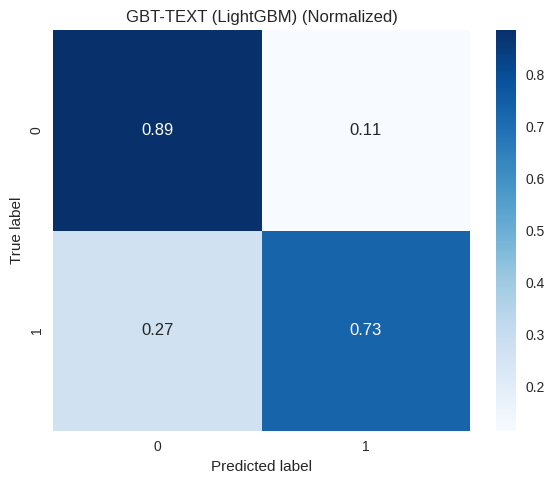


===== Classification Report (GBT-TEXT) =====
              precision    recall  f1-score   support

           0      0.828     0.885     0.856     27546
           1      0.812     0.729     0.768     18702

    accuracy                          0.822     46248
   macro avg      0.820     0.807     0.812     46248
weighted avg      0.821     0.822     0.820     46248



In [ ]:
#@title Final Model Training (Without Bayesian Opt.) for GBT - Open Text

# =========================
# FINAL MODEL TRAINING (WITH KNOWN BAYESIAN OPT. PARAMS)
# =========================
import lightgbm as lgb

# =========================
# CONFIG
# =========================
essay_cols = [f"essay{i}_lemmatized" for i in range(10)]
numeric_cols = [f"essay{i}_wc" for i in range(10)] + ['punct_ratio', 'prompts_filled', 'total_smileys_count']
target_col = 'sex'
RANDOM_STATE = 42

def train_final_lgb(df, best_params, ngram_range=(1,3), alpha=0.2):
    print("-> Building features on full dataset...")
    X_full, vectorizers, scaler, selector = build_features(
        df, ngram_range=ngram_range, fit=True, alpha=alpha, scaler=None
    )
    y_full = df[target_col].values

    print("-> Training final LightGBM model...")
    final_model = lgb.LGBMClassifier(
        **best_params,
        objective='binary',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    final_model.fit(X_full, y_full)

    cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    y_proba_cv = cross_val_predict(final_model, X_full, y_full, cv=cv_final, method="predict_proba", n_jobs=-1)[:, 1]
    y_pred_cv  = (y_proba_cv >= 0.5).astype(int)

    auc_cv = roc_auc_score(y_full, y_proba_cv)
    f1_cv  = f1_score(y_full, y_pred_cv)
    acc_cv = accuracy_score(y_full, y_pred_cv)

    print("\n===== GBT-TEXT: FINAL RESULTS =====")
    summary_df = pd.DataFrame([{
        "Model": "GBT-TEXT (LightGBM)",
        "ROC-AUC": f"{auc_cv:.4f}",
        "F1-Score": f"{f1_cv:.4f}",
        "Accuracy": f"{acc_cv:.4f}"
    }])
    print(summary_df.to_string(index=False))

    classes = ['0', '1']
    plot_normalized_confusion_matrix(y_full, y_pred_cv, 'GBT-TEXT (LightGBM)', classes)

    print("\n===== Classification Report (GBT-TEXT) =====")
    print(classification_report(y_full, y_pred_cv, digits=3))

    return final_model, vectorizers, scaler, selector, summary_df

# =========================
# RUN FINAL MODEL
# =========================
# best_params found in bayesian opt.
best_params = {
    'num_leaves': 16,
    'max_depth': 11,
    'learning_rate': 0.22854155758290642,
    'n_estimators': 427,
    'subsample': 0.5255672768385259,
    'colsample_bytree': 0.7717015338451563
}

gbt_final_model, gbt_vectorizers, gbt_scaler, gbt_selector, gbt_summary = train_final_lgb(
    okcupid_train, best_params, ngram_range=(1,3), alpha=0.2
)


In contrast to the Closed Data models, GBT performs a bit worse than the LR (with L2) model. Its accuracy is 0.822, and the weighted F1, precision and accuracy are about this number as well. Its ROC-AUC is also very high with 0.9.

This model shares the same issues as the LR model, struggling to identify females within their group (recall = 0.729), with an even larger recall gap between males and females.

In [ ]:
#@title Top 25 Features in GBT - Open Text

def get_top_features_gbt(final_model, vectorizers, selector, top_n=15):
    # Collect feature names for text
    feature_names = []
    for i, vec in enumerate(vectorizers):
        essay_feats = [f"essay{i}_tfidf:{t}" for t in vec.get_feature_names_out()]
        feature_names.extend(essay_feats)

    # Add numeric feature names
    feature_names.extend(numeric_cols)

    # Apply selector mask (keep only chosen features)
    feature_names = np.array(feature_names)[selector.indices]

    # Get feature importances
    importances = final_model.feature_importances_

    # Sort by importance
    top_idx = np.argsort(importances)[-top_n:]
    top_feats = [(feature_names[i], importances[i]) for i in reversed(top_idx)]

    print("\nTop features by importance (GBT):")
    for f, imp in top_feats:
        print(f"{f:30s} {imp:.4f}")

    return top_feats

top_gbt = get_top_features_gbt(gbt_final_model, gbt_vectorizers, gbt_selector, top_n=25)



Top features by importance (GBT):
essay0_wc                      41.0000
essay9_wc                      31.0000
essay4_wc                      30.0000
essay7_wc                      24.0000
essay0_tfidf:love              24.0000
essay5_wc                      23.0000
essay8_wc                      22.0000
essay4_tfidf:love              21.0000
essay2_wc                      21.0000
essay3_tfidf:my                21.0000
essay0_tfidf:guy               20.0000
essay1_tfidf:and               20.0000
essay5_tfidf:my                20.0000
essay4_tfidf:and               19.0000
essay0_tfidf:but               19.0000
essay0_tfidf:girl              19.0000
essay0_tfidf:and               18.0000
essay0_tfidf:am                18.0000
essay0_tfidf:me                16.0000
essay1_tfidf:the               15.0000
essay4_tfidf:my                15.0000
essay4_tfidf:to                15.0000
total_smileys_count            15.0000
essay3_tfidf:beard             14.0000
essay4_tfidf:girl            

We can see that predictive words in the LR model appear here as well, where most words came from the "My self summary" prompt (guy, girl). It is not easy to explain the apearance of some of the words shown here (the, and, but, my).

In addition, we see that in this model word counts in some essays and total_smileys_count also make impact, suggesting that both writing style (length, frequency of certain words) and content (mentions of relationships, appearance, or personal traits) are crucial signals for the GBT classification.



In [ ]:
#@title Overfitting Diagnostics for Open Text

# =========================
# OVERFITTING DIAGNOSTICS
# =========================
def _proba_for_binary(est, X_):
    if hasattr(est, "predict_proba"):
        p = est.predict_proba(X_)
        return p[:, 1] if p.shape[1] == 2 else p[:, -1]
    elif hasattr(est, "decision_function"):
        d = est.decision_function(X_)
        return (d - d.min()) / (d.max() - d.min() + 1e-12)
    else:
        return est.predict(X_).astype(float)

def evaluate_overfitting(estimator, X, y, threshold=0.5, n_splits=5, random_state=42, name="model"):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rows = []

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        if hasattr(X, 'iloc'):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y.iloc[tr], y.iloc[va]
        else:
            X_tr, X_va = X[tr], X[va]
            y_tr, y_va = y[tr], y[va]

        est = clone(estimator)
        est.fit(X_tr, y_tr)

        p_tr = _proba_for_binary(est, X_tr)
        p_va = _proba_for_binary(est, X_va)
        yhat_tr = (p_tr >= threshold).astype(int)
        yhat_va = (p_va >= threshold).astype(int)

        auc_tr = roc_auc_score(y_tr, p_tr)
        auc_va = roc_auc_score(y_va, p_va)
        f1_tr  = f1_score(y_tr, yhat_tr)
        f1_va  = f1_score(y_va, yhat_va)
        acc_tr = accuracy_score(y_tr, yhat_tr)
        acc_va = accuracy_score(y_va, yhat_va)

        rows.append({
            "fold": fold,
            "train_auc": auc_tr, "val_auc": auc_va, "gap_auc": auc_tr - auc_va,
            "train_f1": f1_tr,  "val_f1":  f1_va,  "gap_f1":  f1_tr - f1_va,
            "train_acc": acc_tr,"val_acc": acc_va,"gap_acc": acc_tr - acc_va,
        })

    df = pd.DataFrame(rows)

    def mean_ci(x):
        m = np.mean(x)
        s = np.std(x, ddof=1)
        n = len(x)
        ci = 1.96 * s / np.sqrt(n) if n > 1 else 0.0
        return f"{m:.4f} ± {ci:.4f}"

    summary = pd.DataFrame({
        "metric": ["AUC", "F1", "Accuracy"],
        "train (mean±95%CI)": [mean_ci(df["train_auc"]), mean_ci(df["train_f1"]), mean_ci(df["train_acc"])],
        "val (mean±95%CI)":   [mean_ci(df["val_auc"]),   mean_ci(df["val_f1"]),   mean_ci(df["val_acc"])],
        "gap train−val":      [f"{df['gap_auc'].mean():.4f}", f"{df['gap_f1'].mean():.4f}", f"{df['gap_acc'].mean():.4f}"]
    })

    print(f"\n======== {name}: Train vs. Validation by Fold ========")
    print(df.round(4).to_string(index=False))
    print(f"\n======== {name}: Summary (mean across {n_splits} folds) ========")
    print(summary.to_string(index=False))

    # Plot per-fold AUC
    plt.figure(figsize=(7.5, 5.5))
    idx = np.arange(len(df))
    width = 0.35
    plt.bar(idx - width/2, df["train_auc"], width, label="Train AUC")
    plt.bar(idx + width/2, df["val_auc"],   width, label="Validation AUC")
    for i, g in enumerate(df["gap_auc"]):
        plt.text(i, max(df["train_auc"][i], df["val_auc"][i]) + 0.01, f"Δ={g:.3f}", ha="center", va="bottom", fontsize=9)
    plt.xticks(idx, [f"Fold {i}" for i in df["fold"]])
    plt.ylim(0.0, 1.08)
    plt.title(f"{name}: Train vs. Validation AUC by Fold")
    plt.ylabel("AUC")
    plt.legend(loc="lower right")
    plt.show()

    return df, summary

def quick_check(df, name):
    mean_gap_auc = df["gap_auc"].mean()
    max_gap_auc  = df["gap_auc"].max()
    print(f"\n{name} — AUC gaps: mean Δ={mean_gap_auc:.4f}, max Δ={max_gap_auc:.4f}")

-> Building features...

======== LR-TEXT: Train vs. Validation by Fold ========
 fold  train_auc  val_auc  gap_auc  train_f1  val_f1  gap_f1  train_acc  val_acc  gap_acc
    1     0.9568   0.9136   0.0432    0.8579  0.7897  0.0682     0.8896   0.8378   0.0518
    2     0.9568   0.9130   0.0438    0.8581  0.7926  0.0655     0.8898   0.8395   0.0503
    3     0.9567   0.9132   0.0435    0.8566  0.7972  0.0594     0.8886   0.8435   0.0451
    4     0.9558   0.9152   0.0407    0.8542  0.7946  0.0595     0.8865   0.8412   0.0454
    5     0.9561   0.9149   0.0412    0.8589  0.7915  0.0674     0.8902   0.8370   0.0532

======== LR-TEXT: Summary (mean across 5 folds) ========
  metric train (mean±95%CI) val (mean±95%CI) gap train−val
     AUC    0.9564 ± 0.0004  0.9140 ± 0.0009        0.0425
      F1    0.8571 ± 0.0016  0.7931 ± 0.0025        0.0640
Accuracy    0.8889 ± 0.0013  0.8398 ± 0.0023        0.0492


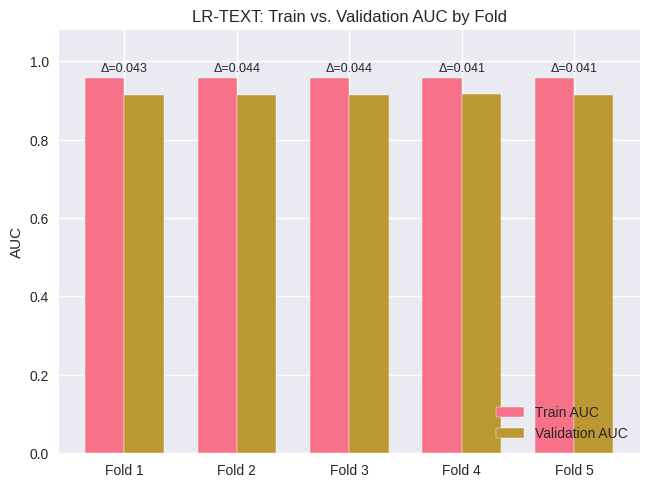


LR-TEXT — AUC gaps: mean Δ=0.0425, max Δ=0.0438


In [ ]:
#@title Ridge Test Diagnostics for Open Text

# =========================
# RUN OVERFITTING CHECK FOR LR
# =========================
# Build combined matrix without selector
X_lr_full, _, _, _ = build_features(
    okcupid_train,
    ngram_range=(1,3),
    vectorizers=lr_vectorizers,
    fit=False,
    feature_selector=None,
    scaler=lr_scaler
)
# Apply selector safely
X_lr = lr_selector.transform(X_lr_full)
y_lr = okcupid_train[target_col].values

LR_THRESHOLD = 0.5
lr_overfit_df, lr_overfit_summary = evaluate_overfitting(
    lr_final_model,
    X_lr,
    y_lr,
    threshold=LR_THRESHOLD,
    n_splits=5,
    name="LR-TEXT"
)
quick_check(lr_overfit_df, "LR-TEXT")

We can see that the model trains well and mostly generalizes the data consistently with an average drop of 4.25% for the validation set, which points there's some overfitting. Checking different p-values for feature selection showed a drop in the metrics meaning less features result in some underfitting, when using more features will result in overfitting.

-> Building features...
[LightGBM] [Info] Number of positive: 14962, number of negative: 22036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.995331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 660855
[LightGBM] [Info] Number of data points in the train set: 36998, number of used features: 7935
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.404400 -> initscore=-0.387164
[LightGBM] [Info] Start training from score -0.387164
[LightGBM] [Info] Number of positive: 14961, number of negative: 22037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.724103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661083
[LightGBM] [Info] Number of data points in the train set: 36998, number of used features: 7939
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.404373 -> initscore=-0.387276
[LightGBM] [Info] Start training f

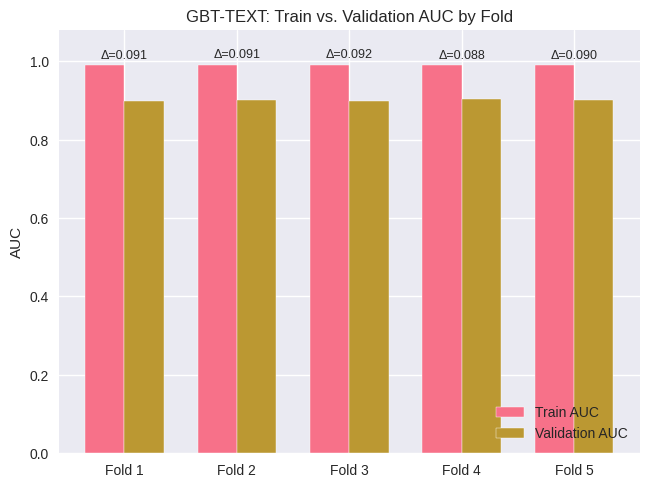


GBT-TEXT — AUC gaps: mean Δ=0.0905, max Δ=0.0918


In [ ]:
#@title GBT Test Diagnostics for Open Text

# =========================
# RUN OVERFITTING CHECK FOR GBT
# =========================
X_gbt_full, _, _, _ = build_features(
    okcupid_train,
    ngram_range=(1,3),
    vectorizers=gbt_vectorizers,
    fit=False,
    feature_selector=None,
    scaler=gbt_scaler
)
X_gbt = gbt_selector.transform(X_gbt_full)
y_gbt = okcupid_train[target_col].values

GBT_THRESHOLD = 0.5
gbt_overfit_df, gbt_overfit_summary = evaluate_overfitting(
    gbt_final_model,
    X_gbt,
    y_gbt,
    threshold=GBT_THRESHOLD,
    n_splits=5,
    name="GBT-TEXT"
)
quick_check(gbt_overfit_df, "GBT-TEXT")

We see a noticeable margin between the train and validation sets.

Trying to address it, we tried to lower significance leve of the Chi-square feature selection to lower alphas (0.05, 0.1), but the model performence went worse.

There is a trade-off between broadening the model's vocabulary and limiting it. A larger vocabulary (more features) allows the model to capture rare or less common words, which can improve classification for users who write shorter texts or use uncommon expressions. doing  reducing the number of features helps prevent overfitting.

A possible way to address the trade-off is by using dimensionality reduction techniques, that compress the feature space and reduce overfitting risk. Since our project aims for high interpretability we decided to keep the features as is.

# TEST

In this section we will run the test and analyze its results.

In [ ]:
#@title TEST - CLOSED DATA

# -------------------------
# FULL TEST PIPELINES - RIDGE & GBT
# -------------------------

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, roc_curve, confusion_matrix


# -------------------------
# Config
# -------------------------
RANDOM_STATE = 42
classes = ['0', '1']

# -------------------------
# Prepare test data
# -------------------------
X_test = okcupid_test[feature_cols].copy()
y_test = okcupid_test[target].copy()
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

===== RIDGE: TEST SET =====
         Model Threshold ROC-AUC F1-Score Accuracy
Ridge (C=0.01)    0.4625  0.8186   0.6749   0.7495


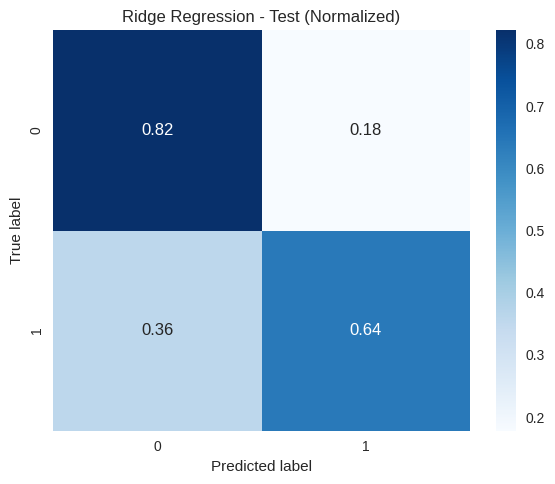


Ridge Classification Report (Test):
              precision    recall  f1-score   support

           0      0.772     0.822     0.796      6887
           1      0.710     0.643     0.675      4676

    accuracy                          0.749     11563
   macro avg      0.741     0.732     0.736     11563
weighted avg      0.747     0.749     0.747     11563



In [ ]:
#@title Ridge Test - Closed Data

# -------------------------
# RIDGE Pipeline
# -------------------------
ridge_preproc = ColumnTransformer(
    transformers=[('num', StandardScaler(), feature_cols)],
    remainder='drop'
)

ridge_final = Pipeline([
    ('prep', ridge_preproc),
    ('clf', LogisticRegression(
        penalty='l2', C=best_ridge_C, solver='lbfgs',
        max_iter=5000, n_jobs=-1, random_state=RANDOM_STATE
    ))
])

ridge_final.fit(okcupid_train[feature_cols], okcupid_train[target])
ridge_test_proba = ridge_final.predict_proba(X_test)[:, 1]
ridge_test_pred  = (ridge_test_proba >= ridge_threshold).astype(int)

ridge_auc_test = roc_auc_score(y_test, ridge_test_proba)
ridge_f1_test  = f1_score(y_test, ridge_test_pred)
ridge_acc_test = accuracy_score(y_test, ridge_test_pred)

print("===== RIDGE: TEST SET =====")
print(pd.DataFrame([{
    "Model": f"Ridge (C={best_ridge_C})",
    "Threshold": f"{ridge_threshold:.4f}",
    "ROC-AUC": f"{ridge_auc_test:.4f}",
    "F1-Score": f"{ridge_f1_test:.4f}",
    "Accuracy": f"{ridge_acc_test:.4f}"
}]).to_string(index=False))

plot_normalized_confusion_matrix(y_test, ridge_test_pred, 'Ridge Regression - Test', classes)
print("\nRidge Classification Report (Test):")
print(classification_report(y_test, ridge_test_pred, digits=3))

We can see that the accuracy of the Ridge model is higher than in the train results: 0.749 (+1.4%); while the ROC-AUC dropped: 0.819 (-0.4%).

Unlike the training results, here we see that the model performed better for males in both recall and precision. Precision is 0.772 for males versus 0.710 for females, which is a narrower gap compared to the training set. Recall is 0.822 for males versus 0.643 for females, a reversal from the training results (0.715 for males vs. 0.764 for females).

This indicates that the current model predominantly fits males better than females. The overall accuracy increased, partly reflecting the class imbalance (with more males than females), while the ROC-AUC decreased, suggesting that the model struggles more with correctly distinguishing females.


===== GBT: TEST SET =====
      Model Threshold ROC-AUC F1-Score Accuracy
GBT (tuned)    0.3711  0.8272   0.7030   0.7402


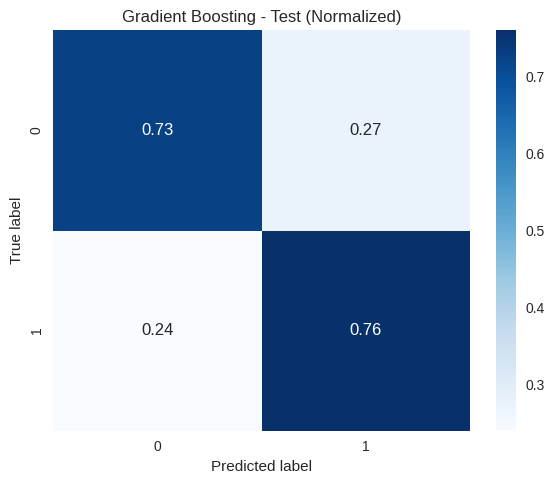


GBT Classification Report (Test):
              precision    recall  f1-score   support

           0      0.817     0.726     0.769      6887
           1      0.654     0.760     0.703      4676

    accuracy                          0.740     11563
   macro avg      0.735     0.743     0.736     11563
weighted avg      0.751     0.740     0.742     11563



In [ ]:
#@title GBT Test - Closed Data

# -------------------------
# GBT Pipeline
# -------------------------

gbt_final = Pipeline([
    ("pre", pre_tree),
    ("clf", HistGradientBoostingClassifier(
        **best_gbt_params,
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1,
        scoring='loss'
    ))
])

gbt_final.fit(okcupid_train[feature_cols], okcupid_train[target])
gbt_test_proba = gbt_final.predict_proba(X_test)[:, 1]
gbt_test_pred  = (gbt_test_proba >= gbt_threshold).astype(int)

gbt_auc_test = roc_auc_score(y_test, gbt_test_proba)
gbt_f1_test  = f1_score(y_test, gbt_test_pred)
gbt_acc_test = accuracy_score(y_test, gbt_test_pred)

print("\n===== GBT: TEST SET =====")
print(pd.DataFrame([{
    "Model": "GBT (tuned)",
    "Threshold": f"{gbt_threshold:.4f}",
    "ROC-AUC": f"{gbt_auc_test:.4f}",
    "F1-Score": f"{gbt_f1_test:.4f}",
    "Accuracy": f"{gbt_acc_test:.4f}"
}]).to_string(index=False))

plot_normalized_confusion_matrix(y_test, gbt_test_pred, 'Gradient Boosting - Test', classes)
print("\nGBT Classification Report (Test):")
print(classification_report(y_test, gbt_test_pred, digits=3))

In this model we don't really notice any major differences from the test results.

The accuracy: 0.740 (-0.1% change from test), and the ROC-AUC: 0.827 (-0.3%) almost didn't change, as well as the F1, precision and recall metrics.

Precision: 0.817 for males vs. 0.654 for females means that the model identifies males more reliably when it predicts them.

Recall: 0.726 vs. 0.760 means the model is slightly better at detecting females within group.

F1: 0.769 vs. 0.703 shows the overall balance between precision and recall which is still stronger for males.

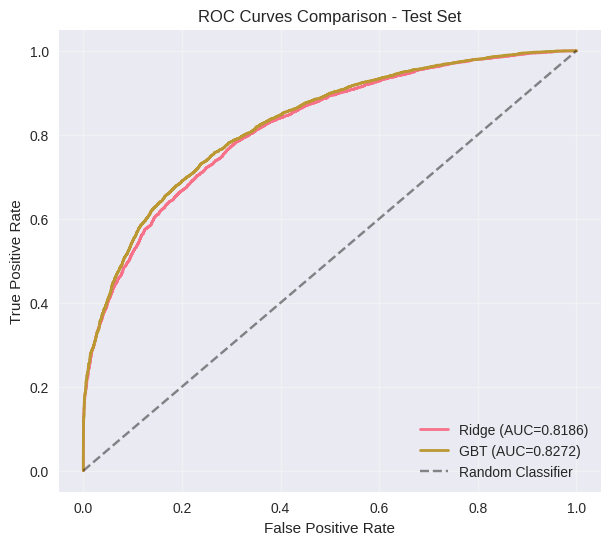

In [ ]:
#@title ROC Curves for Closed Data Models

# -------------------------
# ROC Curve Comparison
# -------------------------
plt.figure(figsize=(7,6))
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, ridge_test_proba)
fpr_gbt, tpr_gbt, _ = roc_curve(y_test, gbt_test_proba)

plt.plot(fpr_ridge, tpr_ridge, linewidth=2, label=f'Ridge (AUC={ridge_auc_test:.4f})')
plt.plot(fpr_gbt, tpr_gbt, linewidth=2, label=f'GBT (AUC={gbt_auc_test:.4f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.5, label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison - Test Set')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Though the accuracy for Ridge was better, the ROC-AUC for GBT is larger. This means that while Ridge performs slightly better at overall classification, GBT has a stronger ability to rank and separate the classes across thresholds.

Both models achieve higher precision for males compared to females.
However, their recall patterns differ: Ridge performs much better with males, whereas GBT shows a more balanced recall, with a slight advantage for females.

This trade-off suggests that Ridge is more reliable when the goal is to correctly identify males, but it struggles to capture females. In contrast, GBT provides a fairer balance between the two groups, making it more suitable if the objective is to avoid systematic bias and ensure that females are not overlooked.

In [ ]:
#@title TEST - OPEN TEXT

from sklearn.metrics import classification_report

# =========================
# TEST SET EVALUATION
# =========================
def evaluate_test(df_test, final_model, vectorizers, scaler, selector, model_name="Model"):
    X_test, _, _, _ = build_features(
        df_test,
        vectorizers=vectorizers,
        fit=False,
        feature_selector=selector,
        scaler=scaler   # <---- pass trained scaler
    )
    y_test = df_test[target_col].values

    y_pred = final_model.predict(X_test)
    y_proba = final_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{model_name} Test Performance")
    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {roc:.4f}")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}")
    print("Confusion Matrix:\n", cm)

    # --- NEW: Print classification report ---
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    return {
        'accuracy': acc, 'f1': f1, 'roc_auc': roc,
        'precision': prec, 'recall': rec,
        'y_test': y_test, 'y_pred': y_pred, 'y_proba': y_proba
    }


# -------------------------
# Normalized Confusion Matrices
# -------------------------
def plot_normalized_confusion_matrix(y_true, y_pred, title, classes):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title + ' (Normalized)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


essay_cols = [f"essay{i}_lemmatized" for i in range(10)]
numeric_cols = [f"essay{i}_wc" for i in range(10)] + ['punct_ratio', 'prompts_filled', 'total_smileys_count']
target_col = 'sex'

-> Building features...

Ridge Test Performance
Accuracy: 0.8193, F1: 0.7680, ROC AUC: 0.8940
Precision: 0.7988, Recall: 0.7395
Confusion Matrix:
 [[6016  871]
 [1218 3458]]

Classification Report:
              precision    recall  f1-score   support

           0      0.832     0.874     0.852      6887
           1      0.799     0.740     0.768      4676

    accuracy                          0.819     11563
   macro avg      0.815     0.807     0.810     11563
weighted avg      0.818     0.819     0.818     11563



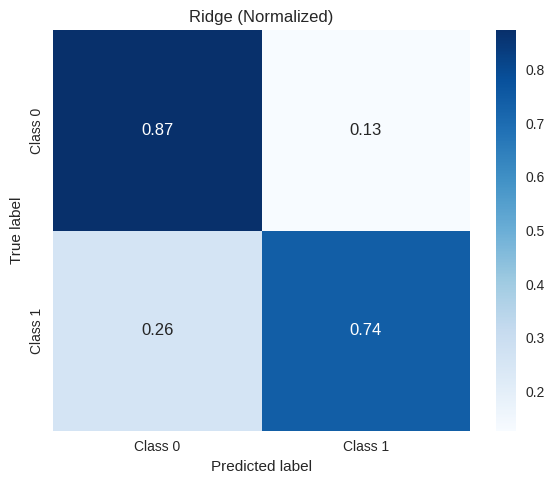

In [ ]:
#@title Ridge Test - Open Text

# =========================
# RUN TEST FOR LR (Ridge)
# =========================

lr_test_results = evaluate_test(
    okcupid_test[[target_col] + essay_cols + numeric_cols],
    lr_final_model,
    lr_vectorizers,
    lr_scaler,
    lr_selector,
    model_name="Ridge"
)

plot_normalized_confusion_matrix(lr_test_results['y_test'], lr_test_results['y_pred'], "Ridge", classes=["Class 0","Class 1"])

We can see that the accuracy of the Ridge Open Text model is higher than in the training results, at 0.819 (-2%), while the ROC-AUC dropped to 0.894 (-2%). This pattern suggests probable overfitting, which may have occurred after training on the entire training set.

The test results are consistent with the training results, the model performed better for males in both recall and precision. Precision is 0.832 for males versus 0.799 for females, a slight drop in both results compared to the training set. Recall is 0.874 for males versus 0.74, which shows a slight drop as well.

This shows that the current model predominantly fits males better than females. The slight drop in accuracy and ROC-AUC suggests possible overfitting to the full training set.

-> Building features...

GBT Test Performance
Accuracy: 0.8154, F1: 0.7610, ROC AUC: 0.8920
Precision: 0.7984, Recall: 0.7269
Confusion Matrix:
 [[6029  858]
 [1277 3399]]

Classification Report:
              precision    recall  f1-score   support

           0      0.825     0.875     0.850      6887
           1      0.798     0.727     0.761      4676

    accuracy                          0.815     11563
   macro avg      0.812     0.801     0.805     11563
weighted avg      0.814     0.815     0.814     11563



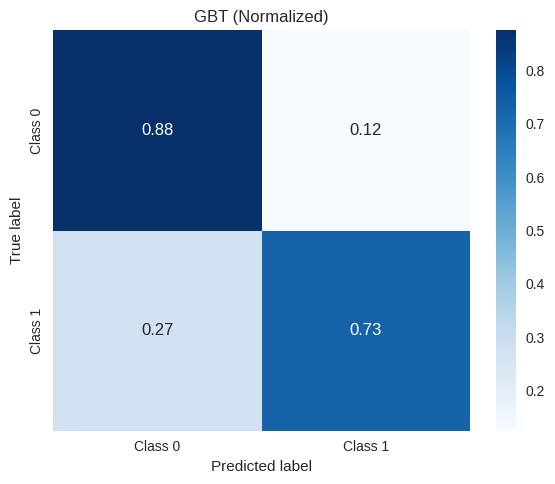

In [ ]:
#@title GBT Test - Open Text

# =========================
# RUN TEST FOR GBT
# =========================
gbt_test_results = evaluate_test(
    okcupid_test[[target_col] + essay_cols + numeric_cols],
    gbt_final_model,
    gbt_vectorizers,
    gbt_scaler,
    gbt_selector,
    model_name="GBT"
)

plot_normalized_confusion_matrix(gbt_test_results['y_test'], gbt_test_results['y_pred'], "GBT", classes=["Class 0","Class 1"])


In this model, we do not observe any major differences from the test results, likely because GBT is relatively robust to the number of features. The GBT tree-based structure makes it less sensitive to redundant or irrelevant features compared to linear models like Ridge.

The accuracy: 0.815 (-0.7% change from test), and the ROC-AUC: 0.892 (-0.8%) dropped a bit, but almost didn't change, as well as the F1, precision and recall metrics.

Precision: 0.825 for males vs. 0.798 for females means that the model identifies males and women with about the same reliability (by small margin it favors males).

Recall: 0.875 vs. 0.727 means the model is much better at detecting males within group.

F1: 0.850 vs. 0.761 shows the overall balance between precision and recall which is still stronger for males.

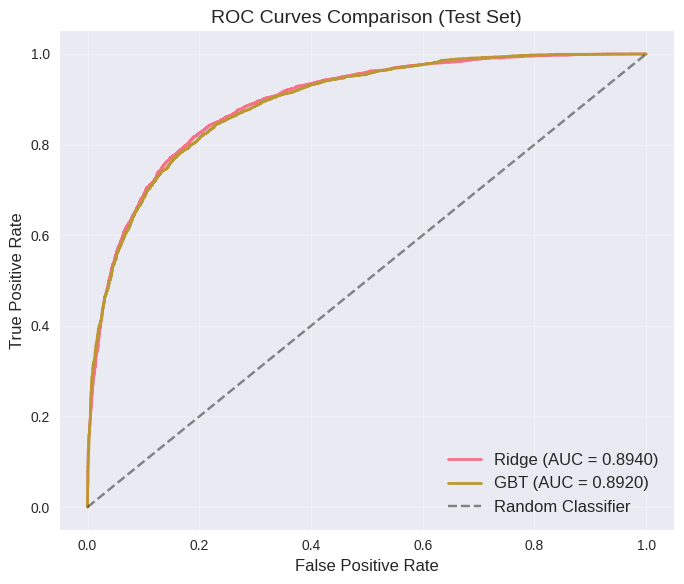


The models agree on: 88.53% of users


In [ ]:
#@title ROC Curves for Open Text Models

# -------------------------
# ROC Curves on Test
# -------------------------
plt.figure(figsize=(7, 6))
fpr_ridge, tpr_ridge, _ = roc_curve(lr_test_results['y_test'], lr_test_results['y_proba'])
fpr_gbt, tpr_gbt, _ = roc_curve(gbt_test_results['y_test'], gbt_test_results['y_proba'])

plt.plot(fpr_ridge, tpr_ridge, linewidth=2, label=f'Ridge (AUC = {lr_test_results["roc_auc"]:.4f})')
plt.plot(fpr_gbt, tpr_gbt, linewidth=2, label=f'GBT (AUC = {gbt_test_results["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison (Test Set)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =========================
# Agreement Analysis
# =========================
y_pred_ridge = lr_test_results['y_pred']
y_pred_gbt = gbt_test_results['y_pred']

# Agreement mask
agree_mask = y_pred_ridge == y_pred_gbt
pct_agree = np.mean(agree_mask) * 100
print(f"\nThe models agree on: {pct_agree:.2f}% of users")


The metrics for both model are much alike, when Ridge is slightly better (by about 0.1% in most metrics). The accuracy of ridge is slightly better (0.819 vs. 0.815) and we can see that in the ROC-AUC as well (0.894 vs. 0.892). The two models agree on 88.5% of the users, highlighting that their predictions are largely consistent with each other.

Ridge, being a regularized linear model, seems to benefit from a steadier handling of the features, while GBT's flexibility to capture nonlinear patterns doesn't give it much of an edge here.

Overall, both models are picking up the main signals from the text effectively, and the differences are so small that either model could work, though Ridge is easier to interpret.

In [ ]:
#@title Analysis by Age Group - FUNCTIONS

# -------------------------
# Function to summarize overall metrics
# -------------------------
def overall_metrics(y_true, y_pred, y_proba):
    return {
        'accuracy': round(accuracy_score(y_true, y_pred), 3),
        'f1': round(f1_score(y_true, y_pred), 3),
        'roc_auc': round(float(roc_auc_score(y_true, y_proba)), 3),
        'precision': round(precision_score(y_true, y_pred), 3),
        'recall': round(recall_score(y_true, y_pred), 3)
    }

# -------------------------
# Function to analyze by age group
# -------------------------
def analyze_by_age_group(y_true, y_pred, y_proba, age_groups, model_name="Model"):
    print(f"\n===== {model_name} Analysis by Age_Group =====")
    unique_ages = sorted(age_groups.unique())

    results = []
    for group in unique_ages:
        mask = age_groups == group
        if mask.sum() == 0:
            continue
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        y_proba_group = y_proba[mask]

        acc = accuracy_score(y_true_group, y_pred_group)
        f1 = f1_score(y_true_group, y_pred_group)
        auc = roc_auc_score(y_true_group, y_proba_group)
        err = 1 - acc
        conf = np.mean(np.maximum(y_proba_group, 1 - y_proba_group))

        print(f"Age_Group {group}: Acc={acc:.3f}, "
              f"AUC={auc:.3f}, F1={f1:.3f}, Err={err:.3f}, Conf={conf:.3f}")

        results.append((group, acc))
    return results

# -------------------------
# Function to plot combined accuracy by age group
# -------------------------
def plot_combined_accuracy(ridge_age_acc, gbt_age_acc):
    groups = [str(g) for g, _ in ridge_age_acc]
    ridge_accs = [acc for _, acc in ridge_age_acc]
    gbt_accs = [acc for _, acc in gbt_age_acc]

    x = np.arange(len(groups))
    width = 0.35

    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, ridge_accs, width, label='LR', alpha=0.8)
    plt.bar(x + width/2, gbt_accs, width, label='GBT', alpha=0.8)
    plt.xlabel("Age Group")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy by Age Group")
    plt.xticks(x, groups, rotation=45)
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:
#@title Ridge Closed Date - AGE ANALYSIS

ridge_overall = overall_metrics(y, ridge_pred, ridge_proba)
print("\n=== LR Closed Data Overall Test Metrics ===")
print(ridge_overall)
ridge_age_acc = analyze_by_age_group(y, ridge_pred, ridge_proba, age_groups, "LR")



=== LR Closed Data Overall Test Metrics ===
{'accuracy': 0.735, 'f1': 0.7, 'roc_auc': 0.823, 'precision': 0.645, 'recall': 0.764}

===== LR Analysis by Age_Group =====
Age_Group 18-24: Acc=0.740, AUC=0.820, F1=0.700, Err=0.260, Conf=0.734
Age_Group 25-29: Acc=0.740, AUC=0.826, F1=0.684, Err=0.260, Conf=0.732
Age_Group 30-34: Acc=0.740, AUC=0.830, F1=0.708, Err=0.260, Conf=0.734
Age_Group 35-39: Acc=0.731, AUC=0.819, F1=0.697, Err=0.269, Conf=0.736
Age_Group 40-49: Acc=0.723, AUC=0.819, F1=0.703, Err=0.277, Conf=0.737
Age_Group 50+: Acc=0.702, AUC=0.798, F1=0.733, Err=0.298, Conf=0.735


The model's performance is fairly consistent for younger users (ages 18-34), with accuracy around 0.740 and ROC-AUC between 0.820 and 0.830, but gradually declines for older age groups, reaching an accuracy of 0.702 and AUC of 0.798 for users aged 50+.

A possible explanation for the performance differences is the model's M/F bias: overall, the dataset is 60% male and 40% female, but the ratio shifts closer to 50/50 in older age groups. This means the model, which tends to perform better for males, may lose some of its advantage in these balanced groups.

Additional factors could include sociological or behavioral differences: older users are underrepresented in the data, making predictions more difficult, and they may also exhibit more diverse preferences, adding further variability that the model struggles to capture.

In [ ]:
#@title GBT Closed Data - AGE ANALYSIS
gbt_overall = overall_metrics(y, gbt_pred, gbt_proba)
print("\n=== GBT Closed Data Overall Test Metrics ===")
print(gbt_overall)
gbt_age_acc = analyze_by_age_group(y, gbt_pred, gbt_proba, age_groups, "GBT")


=== GBT Closed Data Overall Test Metrics ===
{'accuracy': 0.741, 'f1': 0.707, 'roc_auc': 0.83, 'precision': 0.652, 'recall': 0.772}

===== GBT Analysis by Age_Group =====
Age_Group 18-24: Acc=0.749, AUC=0.828, F1=0.711, Err=0.251, Conf=0.752
Age_Group 25-29: Acc=0.741, AUC=0.831, F1=0.685, Err=0.259, Conf=0.751
Age_Group 30-34: Acc=0.746, AUC=0.837, F1=0.716, Err=0.254, Conf=0.749
Age_Group 35-39: Acc=0.744, AUC=0.828, F1=0.709, Err=0.256, Conf=0.753
Age_Group 40-49: Acc=0.729, AUC=0.827, F1=0.708, Err=0.271, Conf=0.751
Age_Group 50+: Acc=0.709, AUC=0.808, F1=0.744, Err=0.291, Conf=0.737


The case in GBT is the same, though it succeeds to keep its success across all groups, except the 50+ one (and not just ages 18-34).

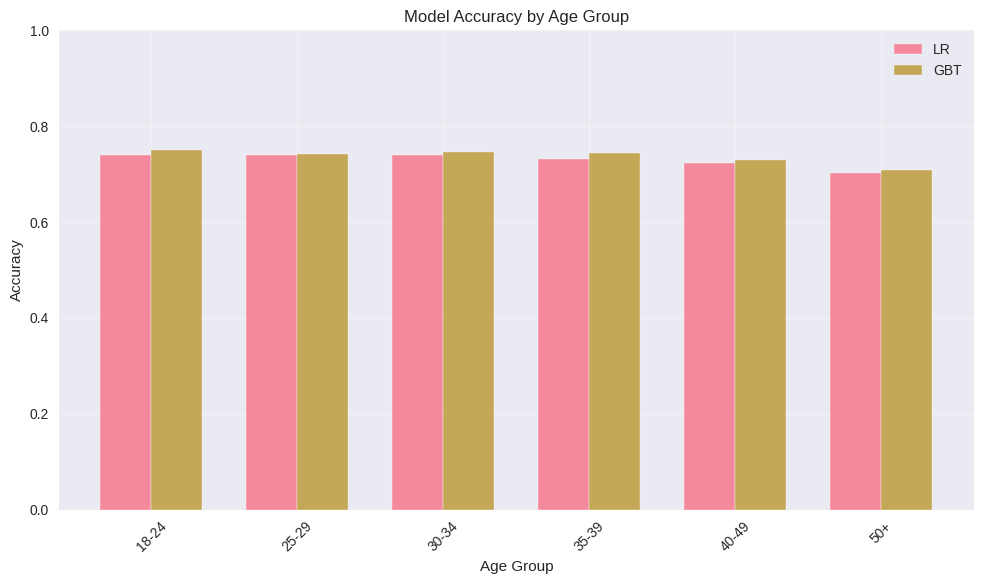

In [ ]:
#@title Age Group Performance - Open Text

plot_combined_accuracy(ridge_age_acc, gbt_age_acc)

We can see consistency through the graph for both model's success.

In [ ]:
#@title Analysis by Age Group and Word Count FUNCTIONS


# =========================
# DEMOGRAPHIC + TEXT GROUP ANALYSIS (OPEN TEXT)
# =========================

def analyze_open_text_performance(df_test, y_true, y_pred, y_proba, group_col, group_name, model_name):
    """
    Generalized performance + confidence + error analysis by group (age or word count)
    """
    results = []
    print(f"\n===== {model_name} Open Text Analysis by {group_name} =====")
    for group in sorted(group_col.dropna().unique()):
        mask = group_col == group
        if mask.sum() == 0:
            continue

        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        y_proba_group = y_proba[mask]

        if len(np.unique(y_true_group)) < 2:
            print(f"{group_name} {group}: skipped (only one class present)")
            continue

        # Metrics
        acc = accuracy_score(y_true_group, y_pred_group)
        f1 = f1_score(y_true_group, y_pred_group)
        auc = roc_auc_score(y_true_group, y_proba_group)
        prec = precision_score(y_true_group, y_pred_group)
        rec = recall_score(y_true_group, y_pred_group)

        # Confidence
        mean_conf = np.mean(np.maximum(y_proba_group, 1 - y_proba_group))
        pred_bias = y_pred_group.mean() - y_true_group.mean()

        # Errors
        errors = y_true_group != y_pred_group
        error_rate = errors.mean()
        fp_rate = ((y_true_group == 0) & (y_pred_group == 1)).mean()
        fn_rate = ((y_true_group == 1) & (y_pred_group == 0)).mean()

        result = {
            group_name: group,
            'Sample_Size': len(y_true_group),
            'Accuracy': round(acc, 3),
            'F1': round(f1, 3),
            'ROC_AUC': round(auc, 3),
            'Precision': round(prec, 3),
            'Recall': round(rec, 3),
            'Mean_Confidence': round(mean_conf, 3),
            'Prediction_Bias': round(pred_bias, 3),
            'Error_Rate': round(error_rate, 3),
            'FP_Rate': round(fp_rate, 3),
            'FN_Rate': round(fn_rate, 3)
        }

        results.append(result)

        print(f"{group_name} {group}: Acc={acc:.3f}, AUC={auc:.3f}, F1={f1:.3f}, "
              f"Err={error_rate:.3f}, Conf={mean_conf:.3f}")

    return pd.DataFrame(results)


# =========================
# MAIN ANALYSIS FUNCTION
# =========================
def evaluate_test_grouped_analysis(df_test, final_model, vectorizers, scaler, selector, model_name="Model"):
    """
    Extended grouped analysis for Ridge/GBT models on open-text scenario
    """
    # --- Build features ---
    X_test, _, _, _ = build_features(
        df_test,
        vectorizers=vectorizers,
        fit=False,
        feature_selector=selector,
        scaler=scaler
    )
    y_test = df_test[target_col].values
    y_pred = final_model.predict(X_test)
    y_proba = final_model.predict_proba(X_test)[:, 1]

    # --- Overall metrics ---
    overall_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }

    print(f"\n=== {model_name} Overall Test Metrics ===")
    print(overall_metrics)

    # --- Grouped Analysis ---
    # Age bins
    bins = [18, 25, 30, 35, 40, 50, 100]
    df_test['age_group'] = pd.cut(df_test['age'], bins=bins, right=False)

    # Word count bins
    df_test['word_group'] = df_test['total_words_filled'].apply(categorize_word_count)

    # Define desired order
    category_order = [
        '(1-99) Minimal',
        '(100-249) Brief',
        '(250-499) Moderate',
        '(500-749) Detailed',
        '(750+) Extensive'
    ]

    df_test['word_group'] = pd.Categorical(
        df_test['word_group'],
        categories=category_order,
        ordered=True
    )

    # Age analysis
    age_analysis = analyze_open_text_performance(df_test, y_test, y_pred, y_proba,
                                                 df_test['age_group'], "Age_Group", model_name)

    # Word count analysis
    word_analysis = analyze_open_text_performance(df_test, y_test, y_pred, y_proba,
                                                  df_test['word_group'], "Word_Group", model_name)

    # Clean up
    df_test.drop(columns=['age_group', 'word_group'], inplace=True)

    return overall_metrics, age_analysis, word_analysis, y_test, y_pred, y_proba

okcupid_test['total_words_filled'] = okcupid_test[[f"essay{i}_wc" for i in range(10)]].sum(axis=1)

In [ ]:
#@title Ridge Open Text - AGE, WORD COUND ANALYSIS

lr_metrics, lr_age, lr_words, y_lr, y_lr_pred, y_lr_proba = evaluate_test_grouped_analysis(
    okcupid_test,
    lr_final_model,
    lr_vectorizers,
    lr_scaler,
    lr_selector,
    model_name="LR"
)

-> Building features...

=== LR Overall Test Metrics ===
{'accuracy': 0.819337542160339, 'f1': 0.7680177679067185, 'roc_auc': np.float64(0.8939905871428336), 'precision': 0.7987987987987988, 'recall': 0.7395209580838323}

===== LR Open Text Analysis by Age_Group =====
Age_Group [18, 25): Acc=0.809, AUC=0.882, F1=0.743, Err=0.191, Conf=0.825
Age_Group [25, 30): Acc=0.836, AUC=0.907, F1=0.774, Err=0.164, Conf=0.824
Age_Group [30, 35): Acc=0.832, AUC=0.904, F1=0.781, Err=0.168, Conf=0.818
Age_Group [35, 40): Acc=0.818, AUC=0.898, F1=0.778, Err=0.182, Conf=0.811
Age_Group [40, 50): Acc=0.802, AUC=0.880, F1=0.765, Err=0.198, Conf=0.807
Age_Group [50, 100): Acc=0.762, AUC=0.859, F1=0.755, Err=0.238, Conf=0.795

===== LR Open Text Analysis by Word_Group =====
Word_Group (1-99) Minimal: Acc=0.754, AUC=0.805, F1=0.584, Err=0.246, Conf=0.761
Word_Group (100-249) Brief: Acc=0.811, AUC=0.884, F1=0.756, Err=0.189, Conf=0.813
Word_Group (250-499) Moderate: Acc=0.825, AUC=0.904, F1=0.786, Err=0.175, 

**Age:**

For Ridge (LR) on Open Text, performance is strongest for users aged 25-34, with accuracy around 0.832-0.836 and ROC-AUC between 0.904 and 0.907. Younger users (18-25) and older users (35+) show slightly lower performance, with the 50+ group having the lowest accuracy (0.762) and AUC (0.859).

It is intersting to see that even though age 35-49 groups wrote the most in their essays on average, they weren't the best classified groups. We see that age 18-24 group that wrote the least on average we're performing better in the model than the 40+ groups.   

These trends likely come from several factors: the oldest age group is underrepresented in the data, making generalization harder; older users may have more diverse writing styles and preferences; and the shifting M/F ratio, combined with the model's tendency to perform better for males, may also influence results.

Overall, Ridge performs well for younger and middle-aged users but shows reduced effectiveness for the 50+ group, highlighting a potential area for improvement.

**Word Count:**

As expected, the Minimal group (1-99 words) was the most difficult for the model to capture, with accuracy of 0.754 and ROC-AUC of 0.805 - values much closer to those observed in the closed data model, as well as a very low F1 of 0.584 showing weak balance between precision and recall compared to other groups.

Performance steadily improves as word count increases, reaching 0.860 accuracy and 0.921 ROC-AUC in the Extensive group (750+ words). This trend suggests that longer essays provide the model with richer textual information, making predictions more reliable.

Initially, we were concerned that very long essays might introduce noise or irrelevant details that could harm performance, but instead, the results indicate that more text consistently helps the model extract useful signals.

In [ ]:
#@title GBT Open Text - AGE & WORD COUNT ANALYSIS

gbt_metrics, gbt_age, gbt_words, y_gbt, y_gbt_pred, y_gbt_proba = evaluate_test_grouped_analysis(
    okcupid_test,
    gbt_final_model,
    gbt_vectorizers,
    gbt_scaler,
    gbt_selector,
    model_name="GBT"
)

-> Building features...

=== GBT Overall Test Metrics ===
{'accuracy': 0.8153593358125054, 'f1': 0.7609985447218179, 'roc_auc': np.float64(0.8920215533586728), 'precision': 0.7984496124031008, 'recall': 0.7269033361847733}

===== GBT Open Text Analysis by Age_Group =====
Age_Group [18, 25): Acc=0.794, AUC=0.880, F1=0.722, Err=0.206, Conf=0.816
Age_Group [25, 30): Acc=0.830, AUC=0.904, F1=0.763, Err=0.170, Conf=0.816
Age_Group [30, 35): Acc=0.832, AUC=0.901, F1=0.777, Err=0.168, Conf=0.812
Age_Group [35, 40): Acc=0.813, AUC=0.896, F1=0.772, Err=0.187, Conf=0.806
Age_Group [40, 50): Acc=0.805, AUC=0.882, F1=0.768, Err=0.195, Conf=0.805
Age_Group [50, 100): Acc=0.778, AUC=0.861, F1=0.769, Err=0.222, Conf=0.786

===== GBT Open Text Analysis by Word_Group =====
Word_Group (1-99) Minimal: Acc=0.763, AUC=0.822, F1=0.586, Err=0.237, Conf=0.745
Word_Group (100-249) Brief: Acc=0.815, AUC=0.886, F1=0.754, Err=0.185, Conf=0.803
Word_Group (250-499) Moderate: Acc=0.821, AUC=0.901, F1=0.781, Err=0.1

**Age:**

For GBT on Open Text, performance peaks in the 25-34 age range, with accuracy of about 0.830 - 0.832 and ROC-AUC values of 0.901 - 0.904.

Younger users (18-25), that write less on average, show slightly lower performance (accuracy 0.794, AUC 0.880), while results gradually decline for older groups.

The 50+ group has the lowest scores, with accuracy of 0.778 and AUC of 0.861.

These trends suggest that GBT, like Ridge, handles younger and middle-aged users well but struggles more with older groups - likely due to their smaller representation in the data, more balanced M/F ratio, and potentially more diverse writing styles and preferences.

**Word Count:**

For GBT, performance also improves as the word count increases.

The Minimal group (1-99 words) is the hardest to classify, with accuracy of 0.763, ROC-AUC of 0.822, and a low F1 of 0.586.

Accuracy, AUC, and F1 scores steadily increase with longer essays, reaching 0.842 accuracy, 0.916 AUC, and 0.796 F1 for the Extensive group (750+ words).

These results suggest that GBT works much better when users write longer texts, since it can pick up on more meaningful patterns, though the improvement starts to level off once the essays get very long.

In [ ]:
#@title Comparison Plot FUNCTION

# =========================
# COMPARISON PLOTS
# =========================
def compare_group_performance(df_lr, df_gbt, group_col="Age_Group", metric="Accuracy"):
    """Compare Ridge vs GBT side by side"""
    comparison = pd.merge(
        df_lr[[group_col, metric]].rename(columns={metric: 'LR'}),
        df_gbt[[group_col, metric]].rename(columns={metric: 'GBT'}),
        on=group_col,
        how='outer'
    )

    x = np.arange(len(comparison))
    width = 0.35
    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, comparison['LR'], width, label='LR', alpha=0.8)
    plt.bar(x + width/2, comparison['GBT'], width, label='GBT', alpha=0.8)
    plt.xticks(x, comparison[group_col], rotation=45)
    plt.ylabel(metric)
    plt.title(f"{metric} by {group_col} for Open Text")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return comparison

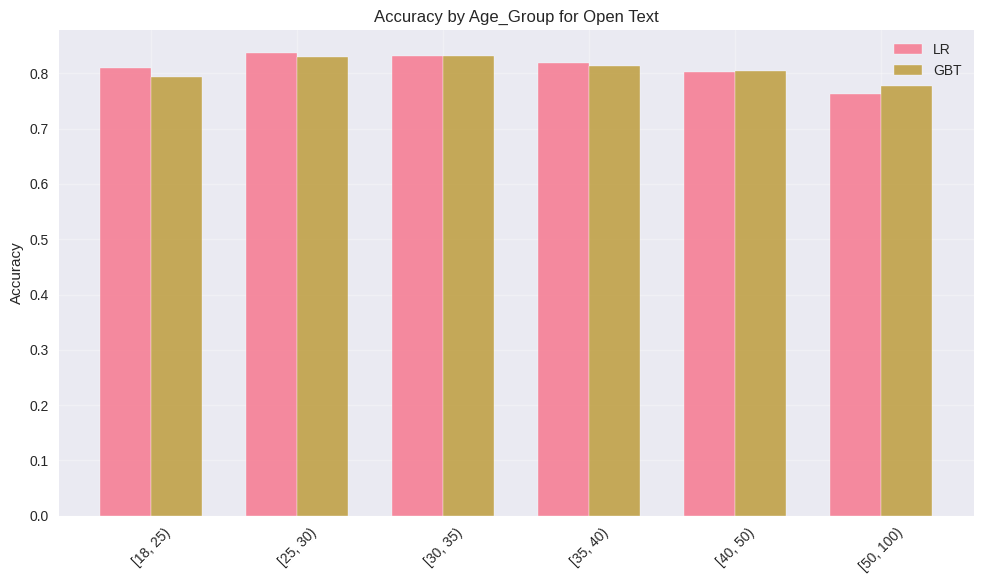

,Age_Group,LR,GBT
0,"[18, 25)",0.809,0.794
1,"[25, 30)",0.836,0.830
2,"[30, 35)",0.832,0.832
3,"[35, 40)",0.818,0.813
4,"[40, 50)",0.802,0.805
5,"[50, 100)",0.762,0.778


In [ ]:
#@title Age Group Performance - Open Text

compare_group_performance(lr_age, gbt_age, "Age_Group", "Accuracy")

We can see that Ridge (LR) achieves slightly higher accuracy in younger age groups, while GBT performs better for older users (40+). A likely reason is that GBT has higher recall for females, and since older age groups have a higher proportion of females, this allows GBT to capture more true positives, while male precision is pretty similar between the models.

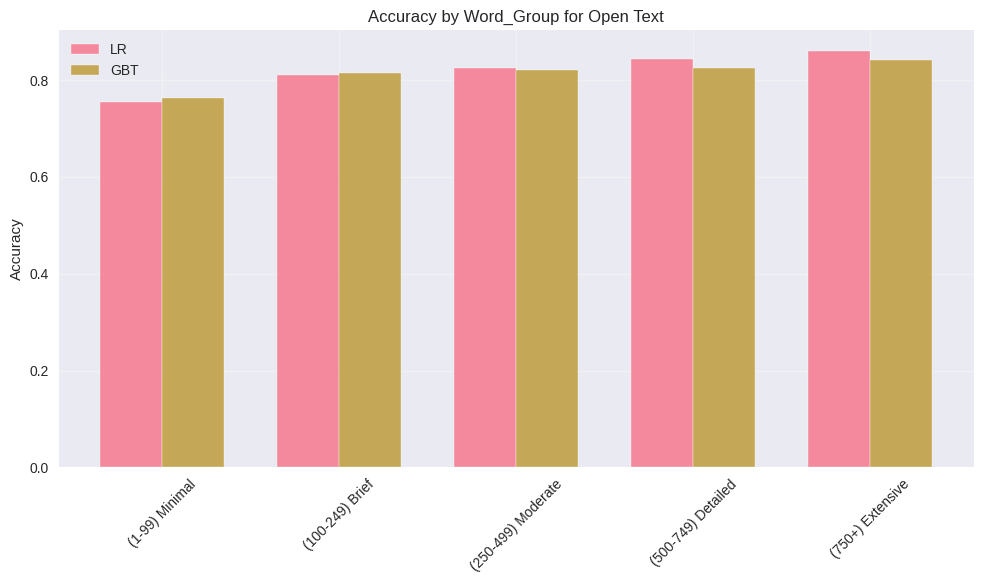

,Word_Group,LR,GBT
0,(1-99) Minimal,0.754,0.763
1,(100-249) Brief,0.811,0.815
2,(250-499) Moderate,0.825,0.821
3,(500-749) Detailed,0.844,0.826
4,(750+) Extensive,0.860,0.842


In [ ]:
#@title Word Count Performance - Open Text

compare_group_performance(lr_words, gbt_words, "Word_Group", "Accuracy")

We can see that GBT handles shorter texts (under 250 words) slightly better, while Ridge (LR) performs slightly better on longer texts.

This may be because GBT, as a tree-based model, can extract useful patterns even from limited text, making it more effective when input is short.

Ridge, on the other hand, is better with the longer essays, where linear relationships between features become more reliable and easier to capture.

# In Conclusion

In this project, we analyzed OKCupid data, focusing on both categorical (demographic) and textual features, with preprocessing and feature selection applied. We compared two models, Gradient Boosted Trees (GBT) and Ridge Regression, and found that despite their methodological differences, both models produced similar results in the two scenarios (categorical-only vs. text-only).

Our analysis shows that gender can be predicted from text with 81-82% accuracy, primarily through gender-linked tendencies such as specific words (e.g., "sassy", "lipstick", "makeup" for females; "computer", "construction" for males), hobbies (baking vs. sports), verbs (e.g., "baking" for women), and physical descriptions (e.g., "petite", "short", "small" vs. "beard", "handsome").

Categorical features also provided predictive power: dietary habits, opinions about astrology, and higher education were more indicative of females, while males were more likely to mention their income. Other patterns were that women more often described themselves as "curvy" and men as "athletic", and certain professions were more common within each gender. Nonetheless, the 74% accuracy in the categorical scenario indicates significant overlap between genders, as women can engage in traditionally male-associated activities (e.g., motorcycling) and men in traditionally female-associated ones (e.g., baking).

It is important to note that model performance depends on the underlying data. The gender ratio in the dataset (approximately 60/40) influenced results, and as this dataset comes from a dating platform, user behavior and self-presentation likely affect text patterns — women may emphasize femininity and men masculinity — so predictions could differ with other types of text, such as formal documents.

The methods applied here could be extended to other fields and problems, including sentiment analysis of customer reviews or social media posts, predicting demographic or behavioral traits from textual surveys, health informatics for patient outcomes, and marketing personalization or recommendation systems.

Despite our progress, we still face knowledge gaps regarding the underlying structure of the data, including limited insight into causal relationships between features and gender, and the influence of platform-specific behavior on text patterns. To address these gaps, future work could involve more advanced modeling approaches such as causal inference or hierarchical models, using more diverse datasets, and integrating domain knowledge about human behavior.

Key concepts that were particularly beneficial include feature engineering for both categorical and textual data, regularization to prevent overfitting, model evaluation metrics like accuracy, F1, and ROC-AUC, and text vectorization methods such as TF-IDF and n-grams. Measures that supported model analysis effectively included stratified train-test splits to maintain gender balance, cross-validation for robust performance assessment, feature selection to reduce dimensionality, and comparing multiple models to validate results across methodologies.

Finally, several blind spots were identified in our solution process. Our reliance on platform-specific text patterns may limit generalizability. Interactions between textual and categorical features were largely unexplored, and subtler aspects of language, such as emotional tone, sarcasm, or context-specific meanings, were not effectively captured due to the limitations of the TF-IDF method.